# ML4N - Adversarial Attacks on Tabular Data Classifiers (group 34)

In [ ]:
!pip install kmodes tensorflow tqdm scipy keras-tuner

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import math
import copy

RANDOM_STATE = 50
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

In [3]:
from functools import reduce
import operator

math.prod = lambda x: reduce(operator.mul, x, 1)

## 1 Data exploration and preprocessing

### 1.2 Data Preprocessing

In [4]:
columns = [
    "status_existing_checking_account",
    "duration_month",
    "credit_history",
    "purpose",
    "credit_amount",
    "savings_account_bonds",
    "present_employment_since",
    "installment_rate_perc_disposable_income",
    "personal_status_sex",
    "other_debtors_guarantors",
    "present_residence_since",
    "property",
    "age_years",
    "other_installment_plans",
    "housing",
    "number_existing_credits_bank",
    "job",
    "number_people_liable_provide_maintenance",
    "telephone",
    "foreign_worker",
    "label"
]

categorical_features = [
    "status_existing_checking_account",
    "credit_history",
    "purpose",
    "savings_account_bonds",
    "present_employment_since",
    "personal_status_sex",
    "other_debtors_guarantors",
    "property",
    "other_installment_plans",
    "housing",
    "job",
    "telephone",
    "foreign_worker"
]
non_categorical_features = list(set(columns).difference(categorical_features + ['label']))

translation =  {
    # status existing checking account (conto corrente)
    "A11": "negative", "A12": "low", "A13": "high", "A14": "not_present",
    # credit history
    "A30": "no_cred", "A31": "paid_back", "A32": "on_pair", "A33": "delay", "A34": "critical",
    # loan purpose
    "A40": "car_new", "A41": "car_used", "A42": "furniture", "A43": "radio/tv", "A44": "domestic", "A45": "repairs", "A46": "education", "A47": "vacation", "A48": "retraining", "A49" : "business", "A410": "other",
    # saving account (conto risparmio)
    "A61": "low", "A62": "medium", "A63": "med_high", "A64": "high", "A65": "unknown",
    # present employment since
    "A71": "unemployed", "A72": "less_1year", "A73": "less_4years", "A74": "less_7years", "A75": "more_7years",
    # personal status and sex
    "A91": "male_div", "A92": "female", "A93": "male_single", "A94": "male_married", "A95": "female_single",
    # other debtors or guarantors
    "A101": "none", "A102": "co-applicant", "A103": "guarantor",
     # property
    "A121": "real_estate", "A122": "building/society/savings/life_ins", "A123": "car/others", "A124": "unknown/no_prop",
    # other installment plans (piani rateali)
    "A141": "bank", "A142": "store", "A143": "none",
    # housing
    "A151": "rent", "A152": "own", "A153": "for_free",
    # job
    "A171": "unemp/unskilled", "A172": "unskilled_resident", "A173": "skilled_empl/off", "A174": "management/self_emp",
    # telephone
    "A191": "none", "A192": "yes",
    # foreign worker
    "A201": "yes", "A202": "no"
}

df = pd.read_csv(
    'dataset/german.data',
    delimiter=' ',
    header=None,
    names=columns
)
df

status_existing_checking_account  duration_month credit_history purpose  \
0                                A11               6            A34     A43   
1                                A12              48            A32     A43   
2                                A14              12            A34     A46   
3                                A11              42            A32     A42   
4                                A11              24            A33     A40   
..                               ...             ...            ...     ...   
995                              A14              12            A32     A42   
996                              A11              30            A32     A41   
997                              A14              12            A32     A43   
998                              A11              45            A32     A43   
999                              A12              45            A34     A41   

     credit_amount savings_account_bonds present_employment_since  \
0             1169                   A65                      A75   
1             5951                   A61                      A73   
2             2096                   A61                      A74   
3             7882                   A61                      A74   
4             4870                   A61                      A73   
..             ...                   ...                      ...   
995           1736                   A61                      A74   
996           3857                   A61                      A73   
997            804                   A61                      A75   
998           1845                   A61                      A73   
999           4576                   A62                      A71   

     installment_rate_perc_disposable_income personal_status_sex  \
0                                          4                 A93   
1                                          2                 A92   
2                                          2                 A93   
3                                          2                 A93   
4                                          3                 A93   
..                                       ...                 ...   
995                                        3                 A92   
996                                        4                 A91   
997                                        4                 A93   
998                                        4                 A93   
999                                        3                 A93   

    other_debtors_guarantors  ...  property age_years  \
0                       A101  ...      A121        67   
1                       A101  ...      A121        22   
2                       A101  ...      A121        49   
3                       A103  ...      A122        45   
4                       A101  ...      A124        53   
..                       ...  ...       ...       ...   
995                     A101  ...      A121        31   
996                     A101  ...      A122        40   
997                     A101  ...      A123        38   
998                     A101  ...      A124        23   
999                     A101  ...      A123        27   

     other_installment_plans housing number_existing_credits_bank   job  \
0                       A143    A152                            2  A173   
1                       A143    A152                            1  A173   
2                       A143    A152                            1  A172   
3                       A143    A153                            1  A173   
4                       A143    A153                            2  A173   
..                       ...     ...                          ...   ...   
995                     A143    A152                            1  A172   
996                     A143    A152                            1  A174   
997                     A143    A152             

The following processing operations are performed
1. One-Hot encoding of categorical features
2. MinMax Normalization in [0,1] range

In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [6]:
df_processed = df.copy()
enc = OneHotEncoder()
enc.fit(df[categorical_features])
df_processed.drop(categorical_features, axis=1, inplace=True)
df_processed[enc.get_feature_names_out(categorical_features)] = enc.transform(df[categorical_features]).toarray()

mms = MinMaxScaler()
df_processed.loc[:, df_processed.columns != 'label'] = \
    mms.fit_transform(df_processed.loc[:, df_processed.columns != 'label'])

categorical_features_hotencoded = df_processed.columns.tolist()
categorical_features_hotencoded = list(set(categorical_features_hotencoded).difference(non_categorical_features + ["label"]))

df_processed

duration_month  credit_amount  installment_rate_perc_disposable_income  \
0          0.029412       0.050567                                 1.000000   
1          0.647059       0.313690                                 0.333333   
2          0.117647       0.101574                                 0.333333   
3          0.558824       0.419941                                 0.333333   
4          0.294118       0.254209                                 0.666667   
..              ...            ...                                      ...   
995        0.117647       0.081765                                 0.666667   
996        0.382353       0.198470                                 1.000000   
997        0.117647       0.030483                                 1.000000   
998        0.602941       0.087763                                 1.000000   
999        0.602941       0.238032                                 0.666667   

     present_residence_since  age_years  number_existing_credits_bank  \
0                   1.000000   0.857143                      0.333333   
1                   0.333333   0.053571                      0.000000   
2                   0.666667   0.535714                      0.000000   
3                   1.000000   0.464286                      0.000000   
4                   1.000000   0.607143                      0.333333   
..                       ...        ...                           ...   
995                 1.000000   0.214286                      0.000000   
996                 1.000000   0.375000                      0.000000   
997                 1.000000   0.339286                      0.000000   
998                 1.000000   0.071429                      0.000000   
999                 1.000000   0.142857                      0.000000   

     number_people_liable_provide_maintenance  label  \
0                                         0.0      1   
1                                         0.0      2   
2                                         1.0      1   
3                                         1.0      1   
4                                         1.0      2   
..                                        ...    ...   
995                                       0.0      1   
996                                       0.0      1   
997                                       0.0      1   
998                                       0.0      2   
999                                       0.0      1   

     status_existing_checking_account_A11  \
0                                     1.0   
1                                     0.0   
2                                     0.0   
3                                     1.0   
4                                     1.0   
..                                    ...   
995                                   0.0   
996                                   1.0   
997                                   0.0   
998                                   1.0   
999                                   0.0   

     status_existing_checking_account_A12  ...  housing_A152  housing_A153  \
0                                     0.0  ...           1.0           0.0   
1                                     1.0  ...           1.0           0.0   
2                                     0.0  ...           1.0           0.0   
3                                     0.0  ...           0.0           1.0   
4                                     0.0  ...           0.0           1.0   
..                                    ...  ...           ...           ...   
995                                   0.0  ...           1.0           0.0   
996                                   0.0  ...           1.0           0.0   
997                                   0.0  ...           1.0           0.0   
998                                   0.0  ...           0.0           1.0   
999                                   1.0  ...           1.0           0.0   

     job_A171  job_A172  job

#### Train-Test split

In [7]:
from sklearn.model_selection import train_test_split

X, X_test, y, y_test = train_test_split(
    df_processed.loc[:, df_processed.columns != 'label'],
    df_processed['label'],
    train_size=0.8,
    stratify=df_processed['label'],
    random_state=RANDOM_STATE
)

### 1.3 Exploratory Data Analysis

In [7]:
print(non_categorical_features)

enc.categories_

['duration_month', 'installment_rate_perc_disposable_income', 'number_existing_credits_bank', 'credit_amount', 'number_people_liable_provide_maintenance', 'present_residence_since', 'age_years']


[array(['A11', 'A12', 'A13', 'A14'], dtype=object),
 array(['A30', 'A31', 'A32', 'A33', 'A34'], dtype=object),
 array(['A40', 'A41', 'A410', 'A42', 'A43', 'A44', 'A45', 'A46', 'A48',
        'A49'], dtype=object),
 array(['A61', 'A62', 'A63', 'A64', 'A65'], dtype=object),
 array(['A71', 'A72', 'A73', 'A74', 'A75'], dtype=object),
 array(['A91', 'A92', 'A93', 'A94'], dtype=object),
 array(['A101', 'A102', 'A103'], dtype=object),
 array(['A121', 'A122', 'A123', 'A124'], dtype=object),
 array(['A141', 'A142', 'A143'], dtype=object),
 array(['A151', 'A152', 'A153'], dtype=object),
 array(['A171', 'A172', 'A173', 'A174'], dtype=object),
 array(['A191', 'A192'], dtype=object),
 array(['A201', 'A202'], dtype=object)]

_Non categorical features distribution and mean value analysis_

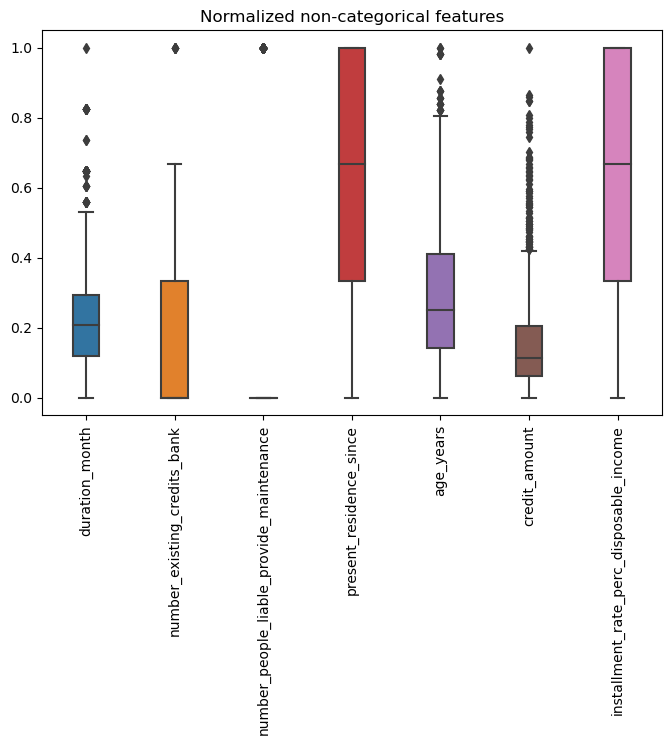

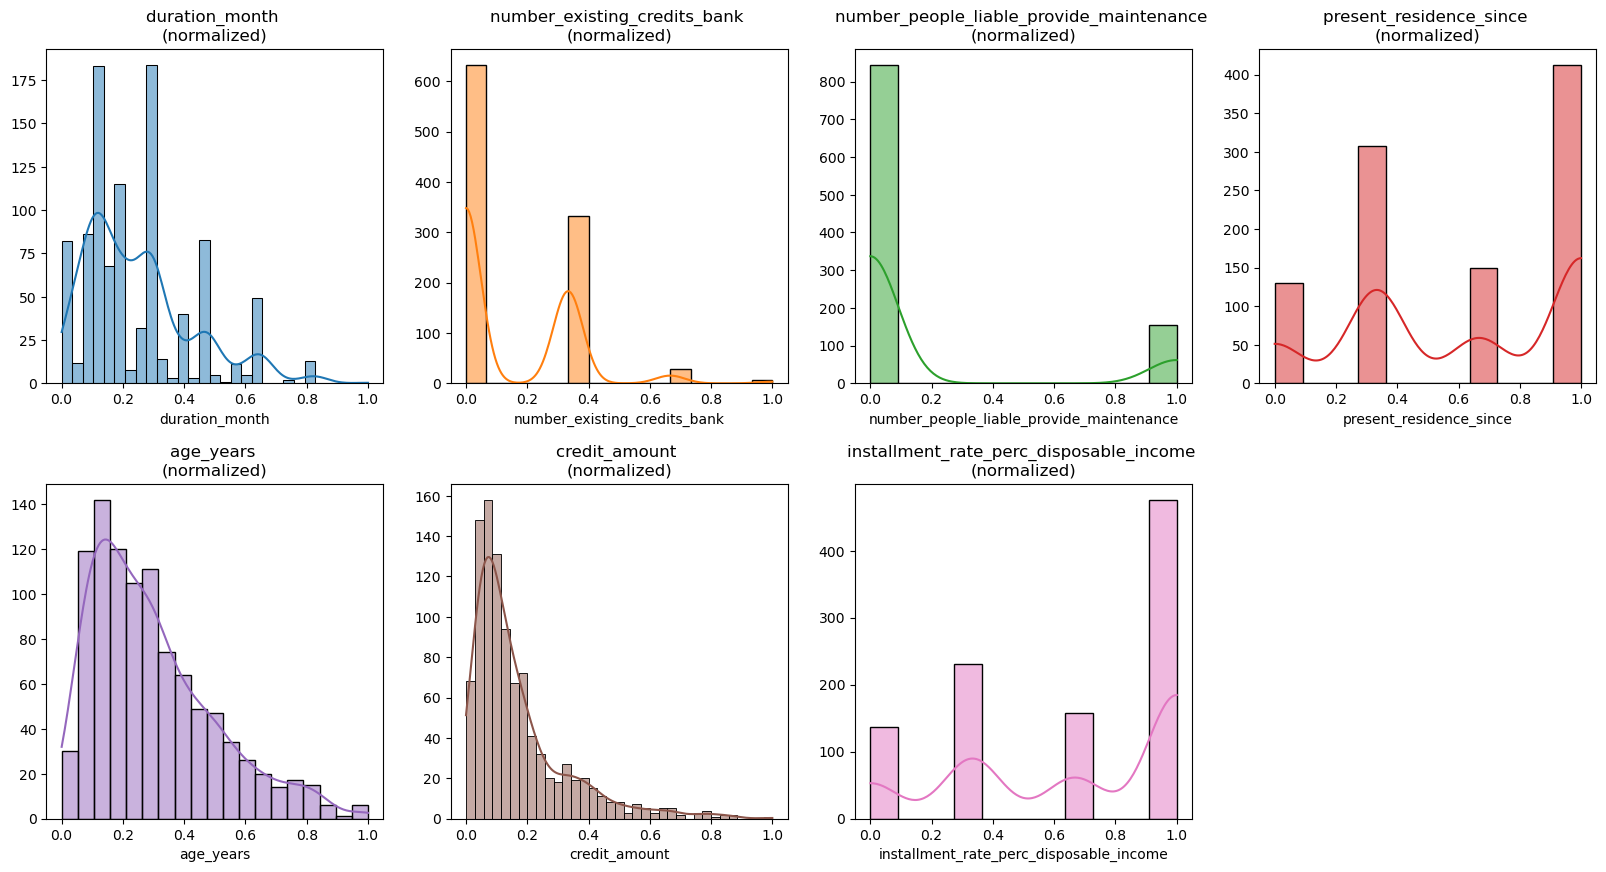

In [93]:
plt.figure(figsize=(8,5))
sns.boxplot(df_processed.loc[:,non_categorical_features], width=0.3)
plt.title('Normalized non-categorical features')
plt.xticks(rotation=90)
plt.show()

fig, axs = plt.subplots(2,4, figsize=(20,10))
for i, col in enumerate(non_categorical_features):
    ax = axs[i // 4][i % 4]
    sns.histplot(df_processed.loc[:,col], ax=ax, kde=True, color=sns.color_palette()[i])
    ax.set_title(f"{col} \n(normalized)")
    ax.set_ylabel("")
axs[1][3].remove()
plt.subplots_adjust(hspace=0.3)
plt.show()

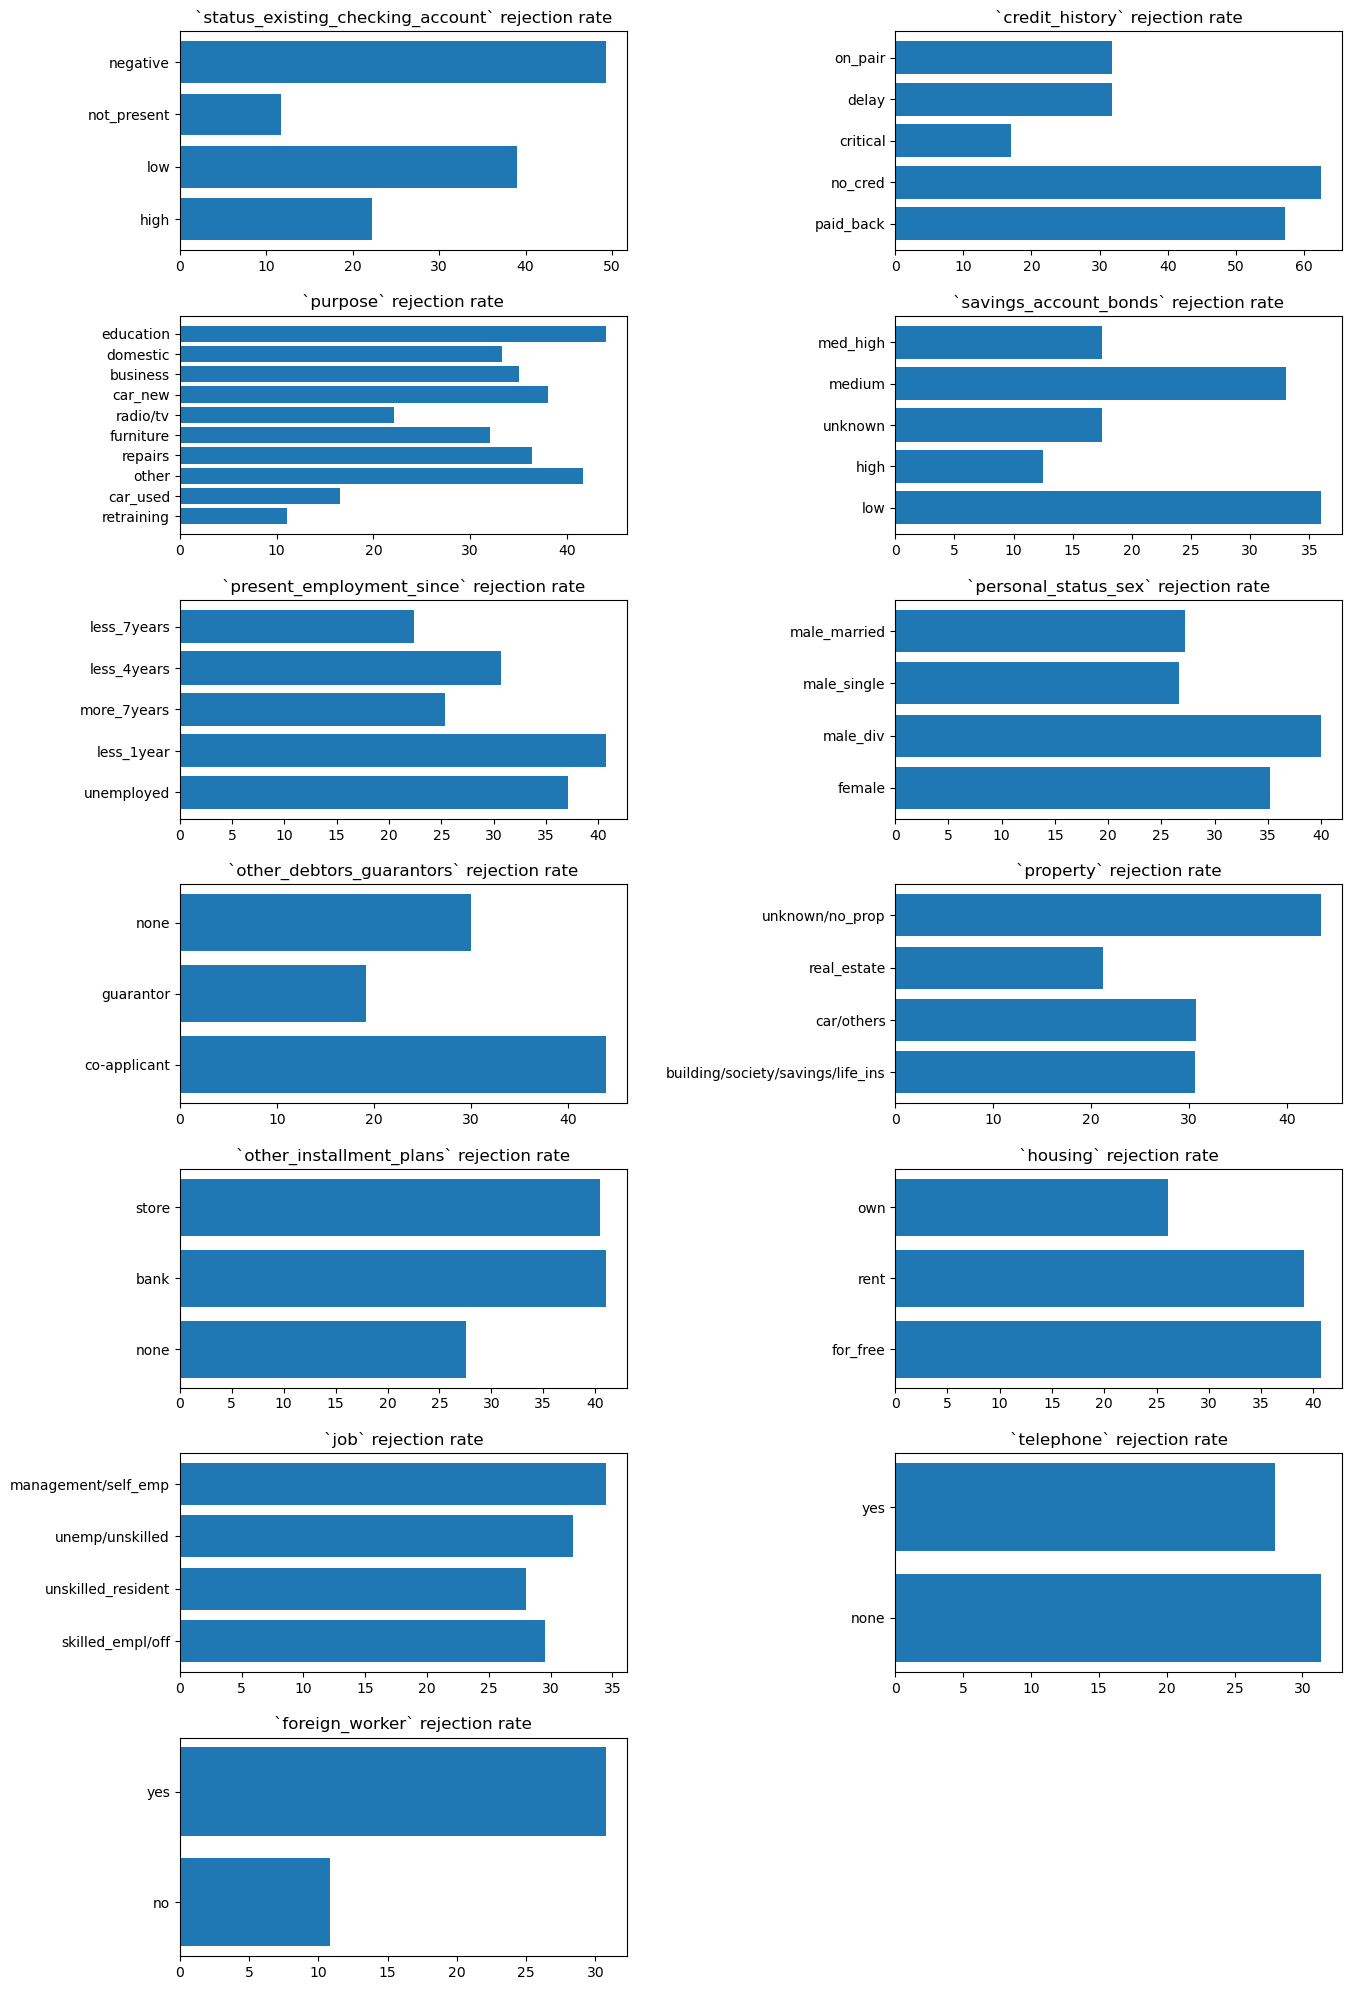

In [94]:
rejection_rates = {}
for col in categorical_features_hotencoded:
    tmp = df_processed[df_processed[col] == 1]
    tot = tmp.size
    neg = tmp[tmp["label"] == 2].size
    rate = neg/tot * 100
    rejection_rates[col] = rate

fig, axs = plt.subplots(len(categorical_features)//2+1,2, figsize=(15,25))
for i, col in enumerate(categorical_features):
    rr = list(filter(lambda x: x[0].startswith(col), rejection_rates.items()))
    axs[i//2][i%2].barh(y=[translation[x[0].split(col)[1][1:]] for x in rr], width=[x[1] for x in rr])
    axs[i//2][i%2].set_title(f"`{col}` rejection rate")
plt.subplots_adjust(hspace=.3, wspace=.6)
axs[-1][-1].remove()
plt.show()

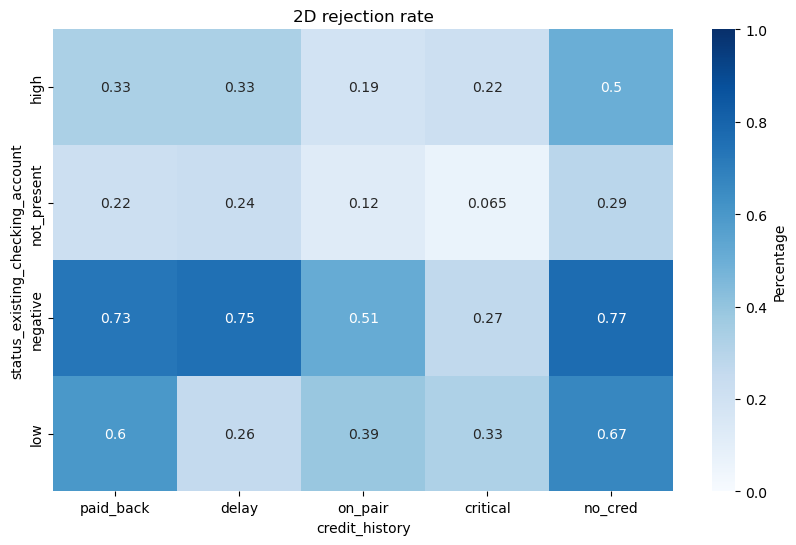

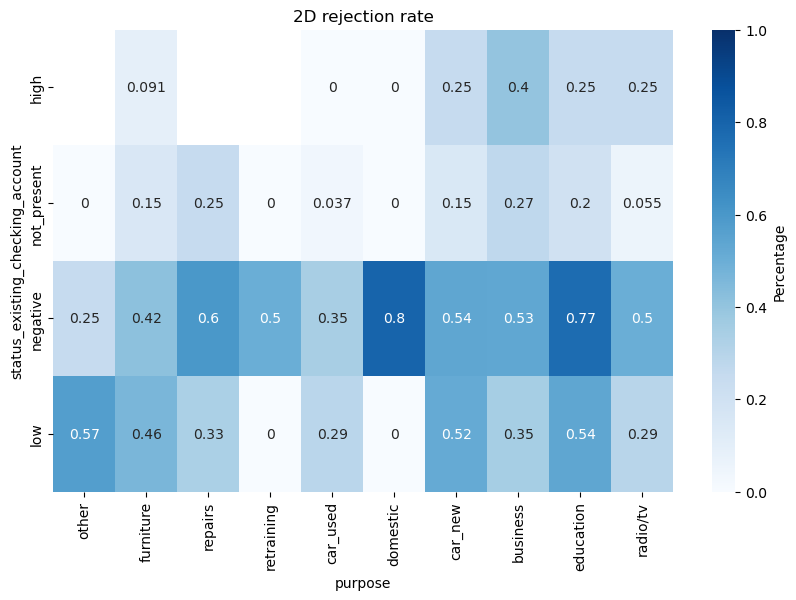

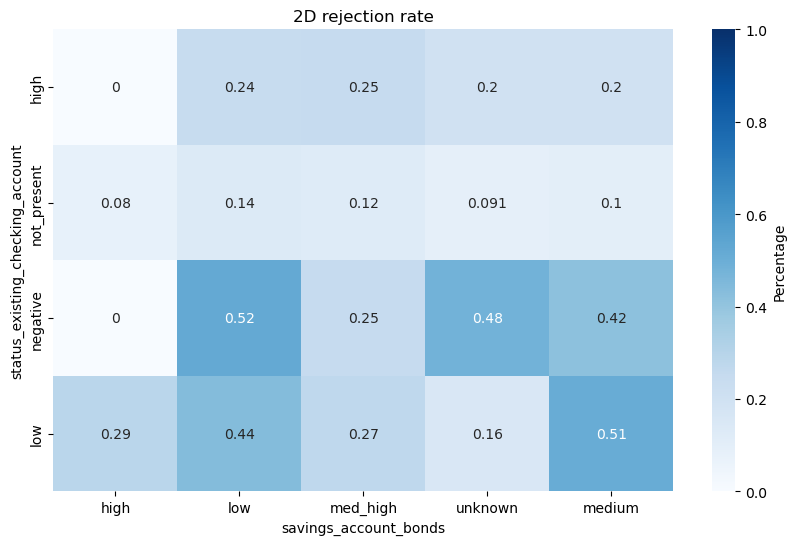

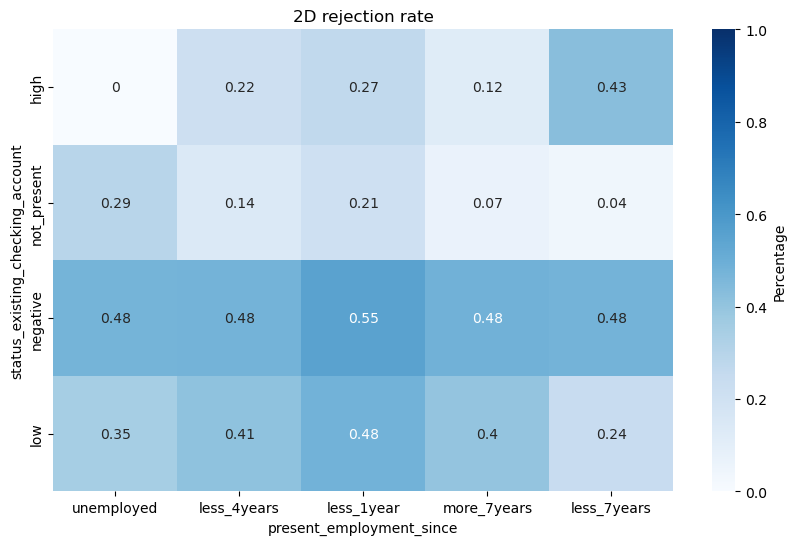

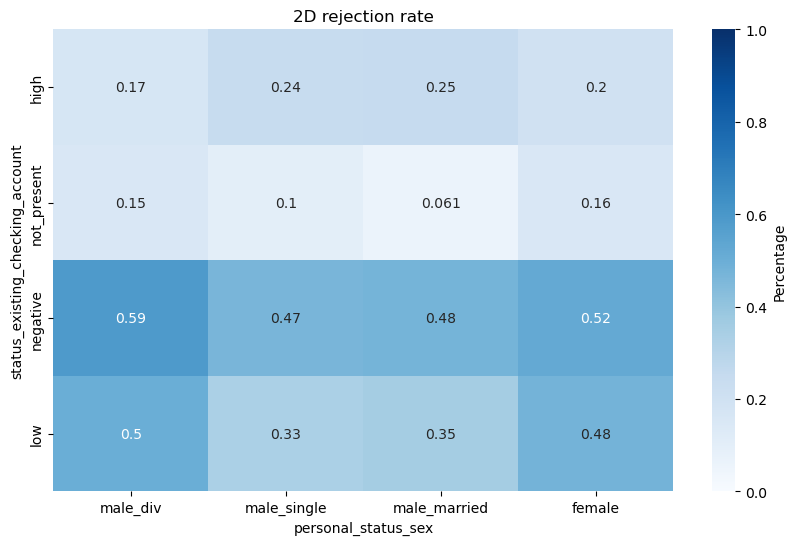

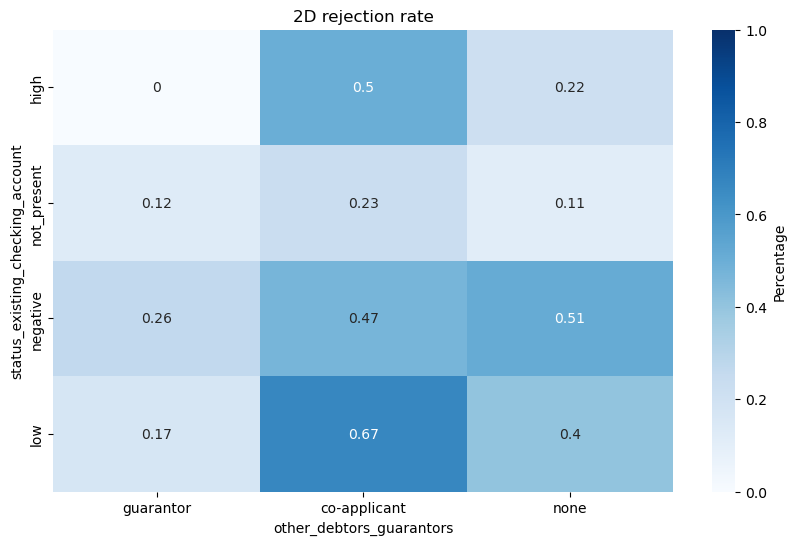

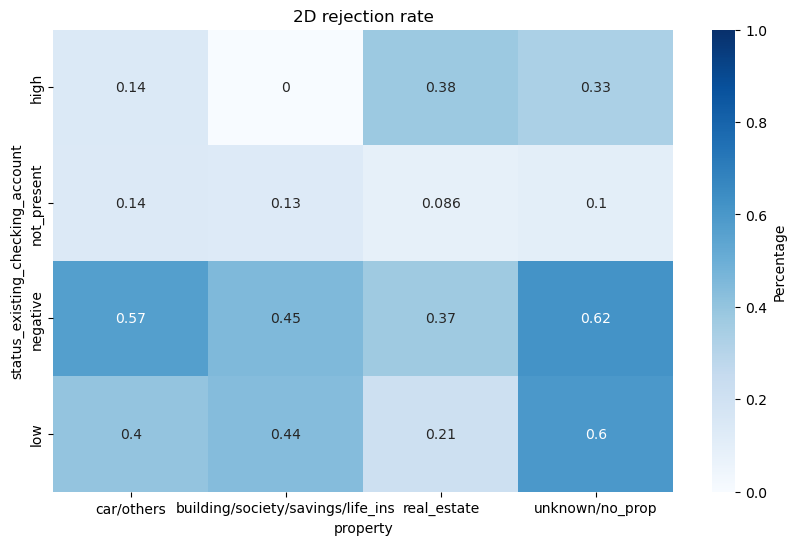

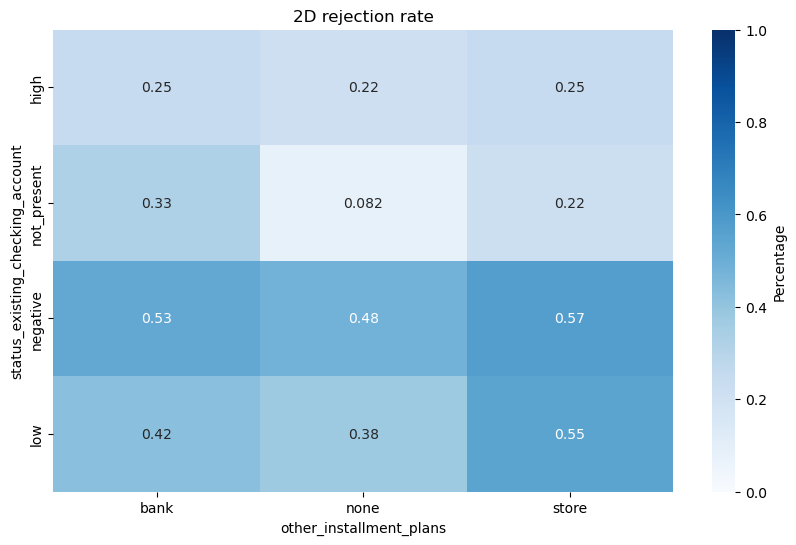

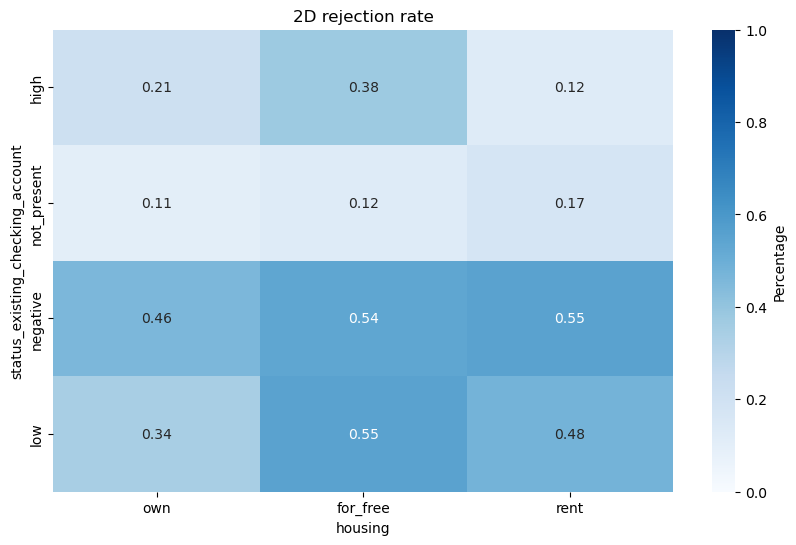

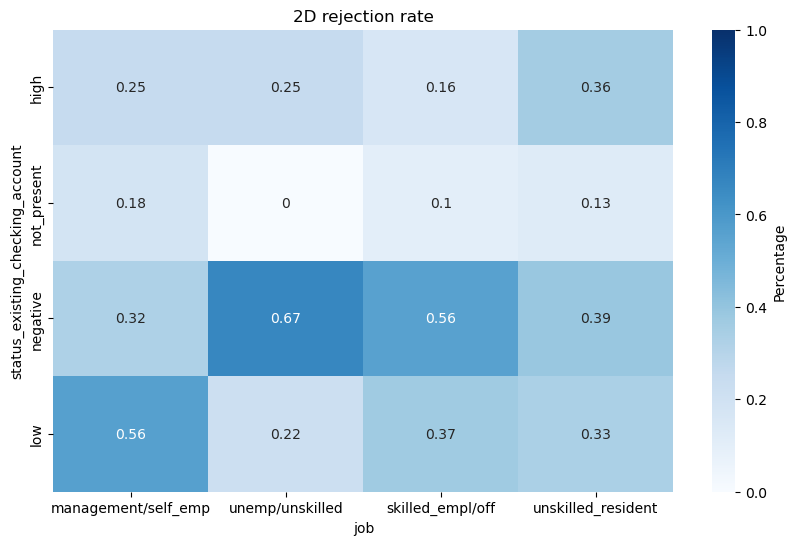

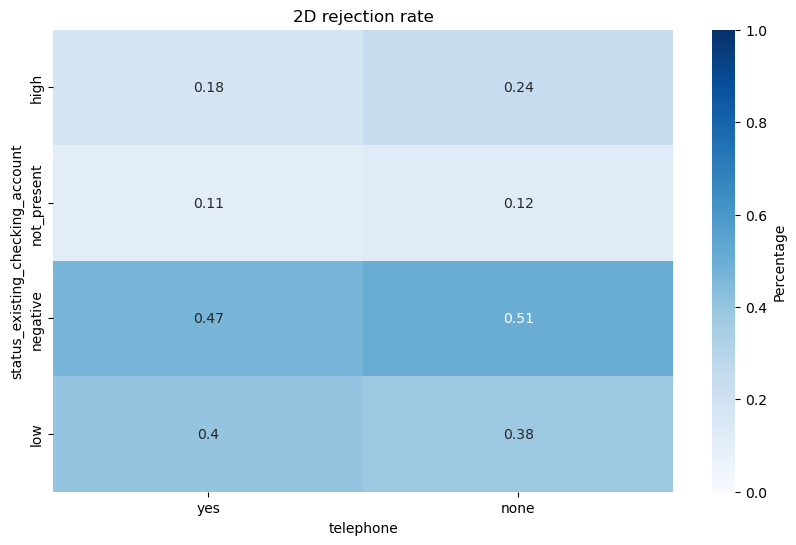

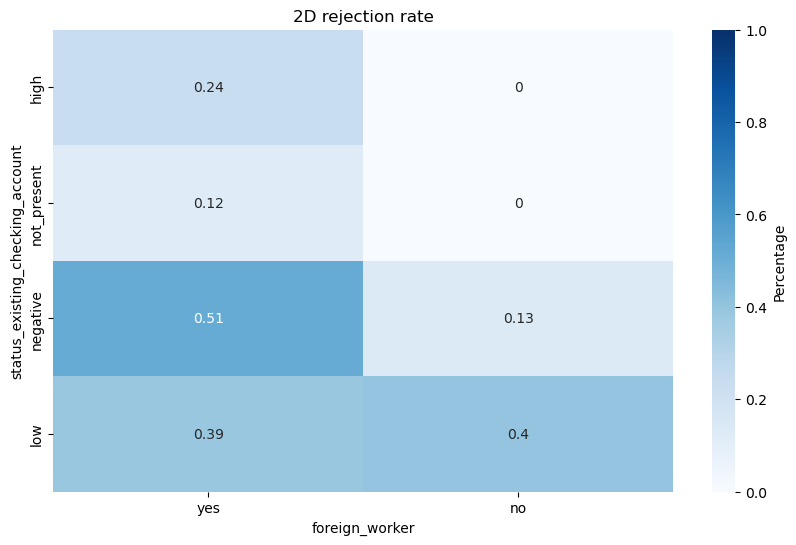

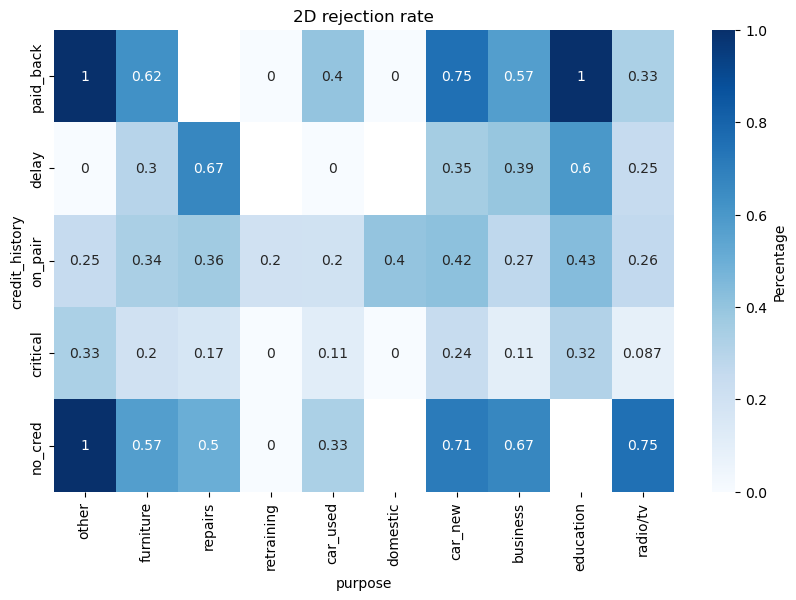

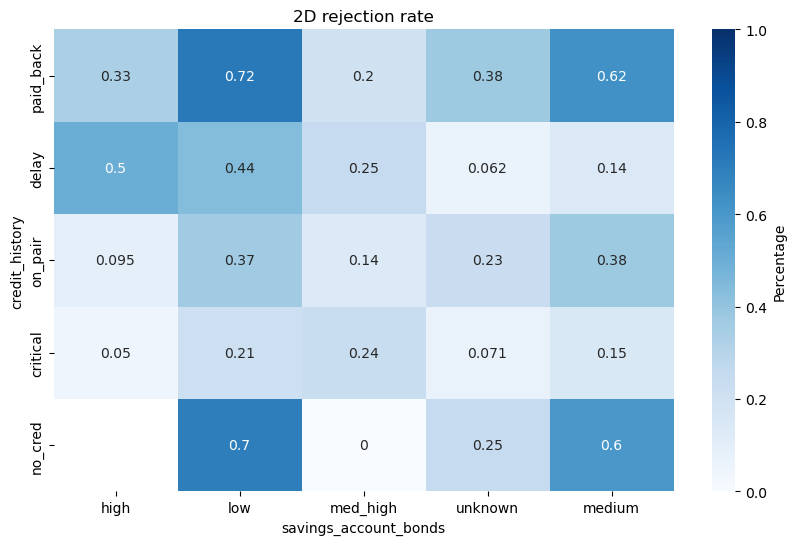

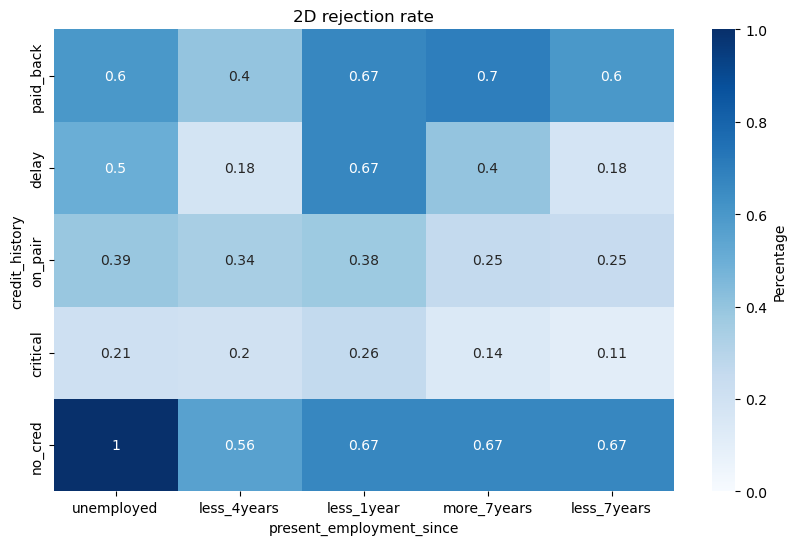

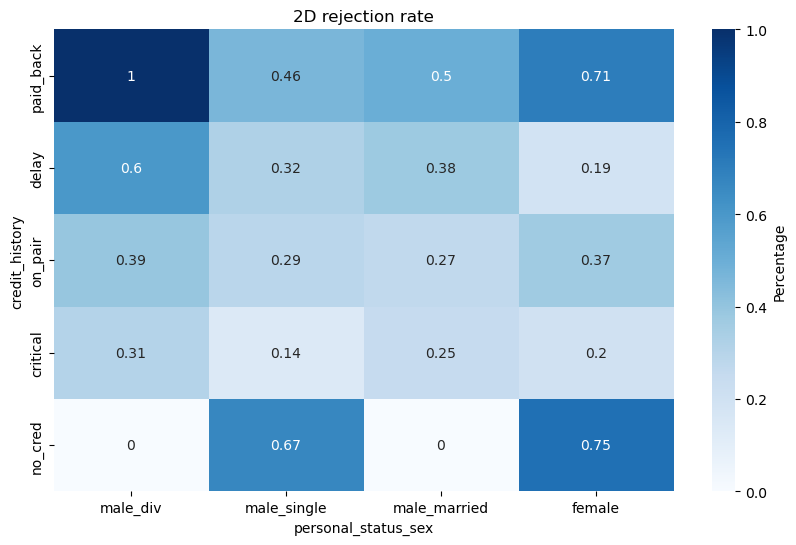

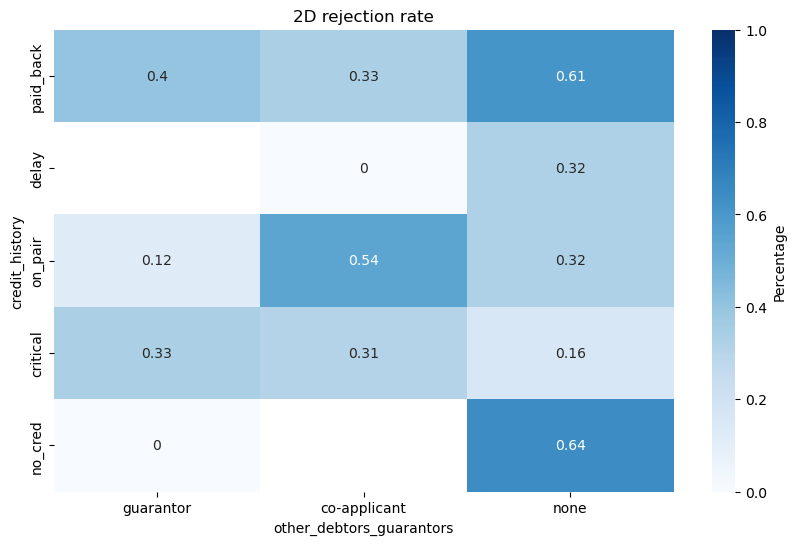

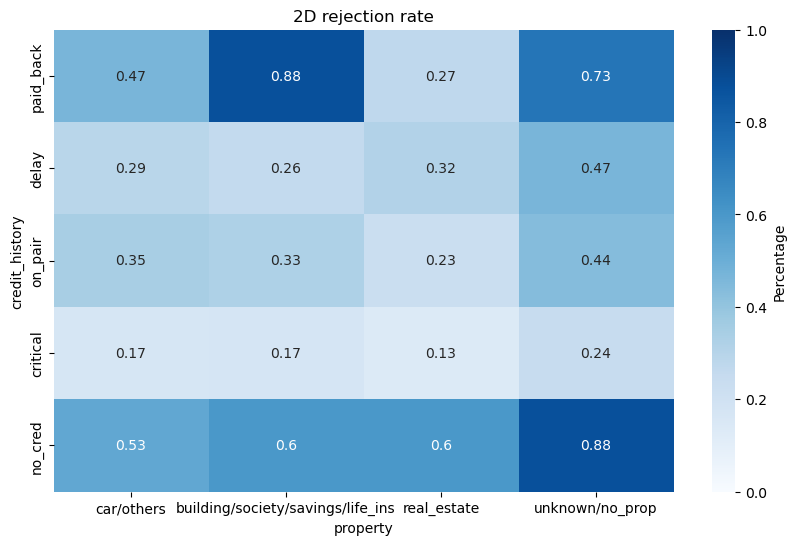

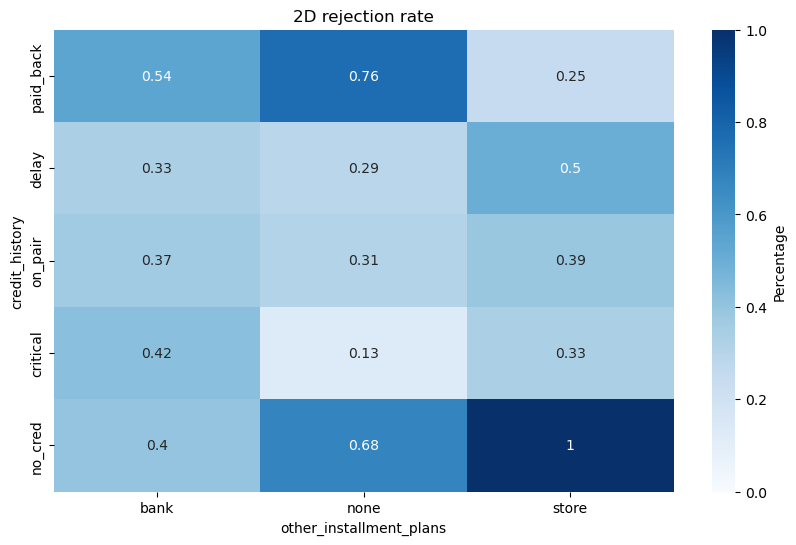

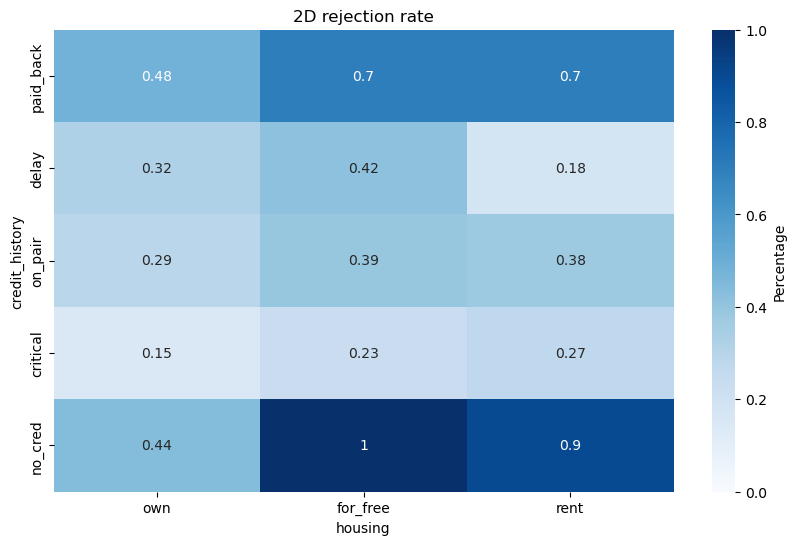

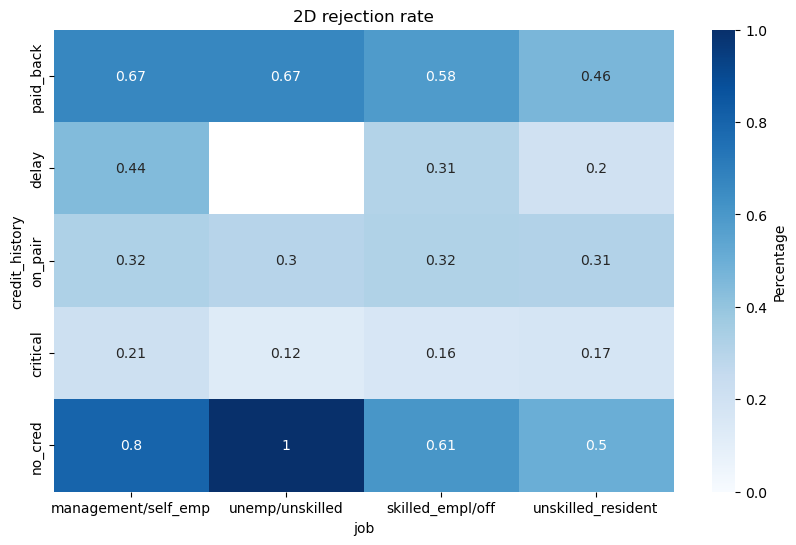

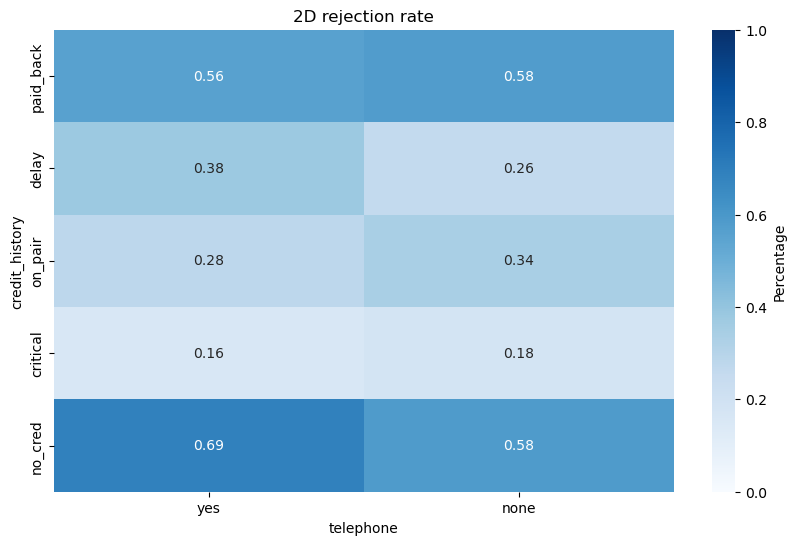

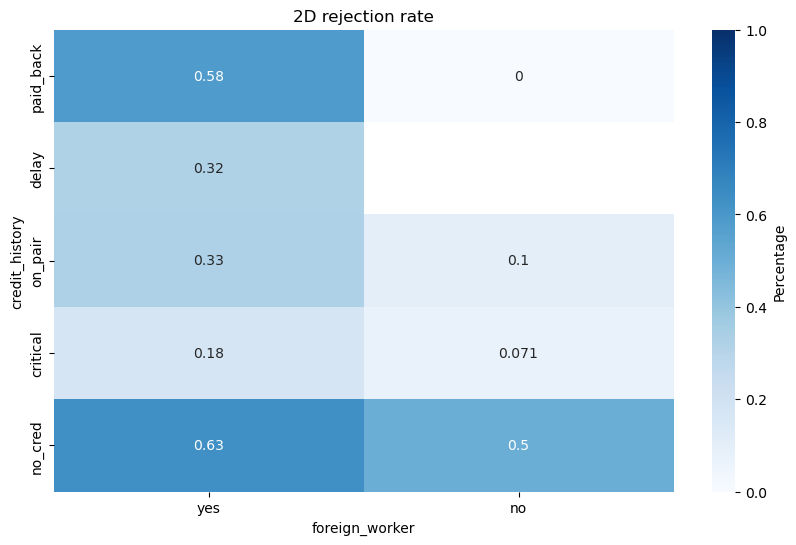

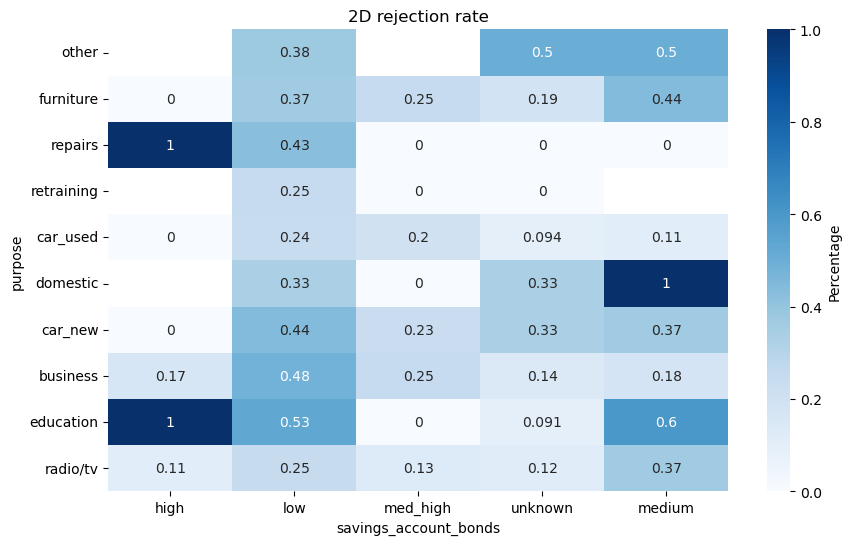

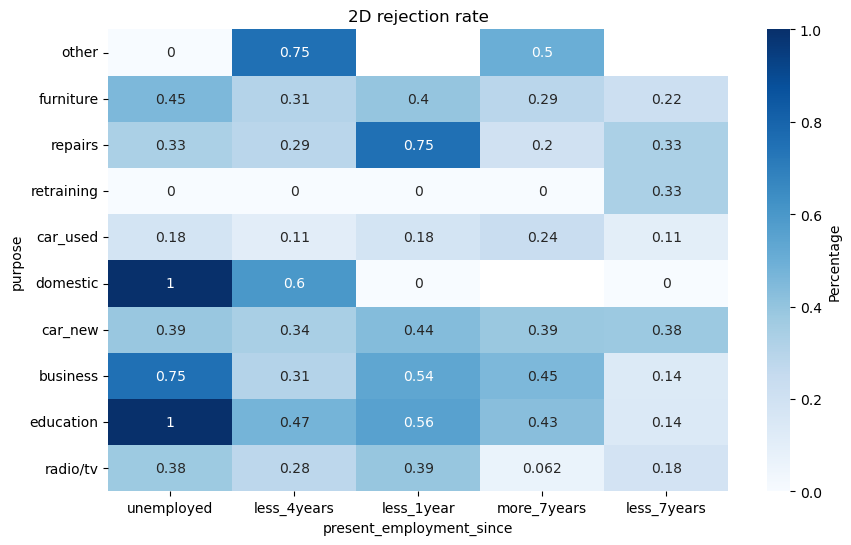

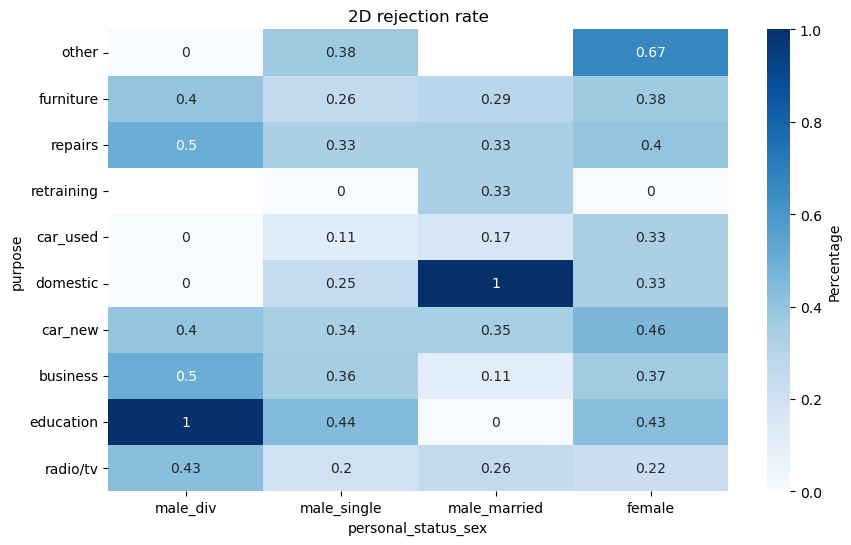

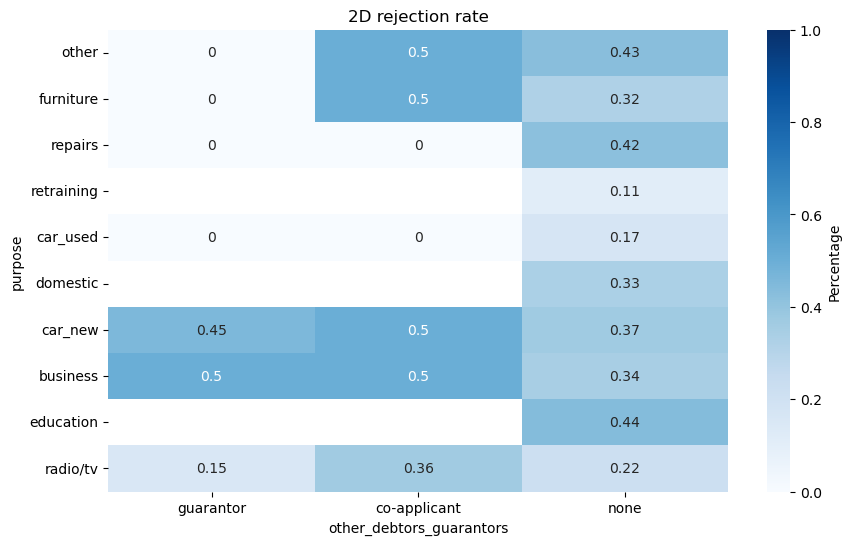

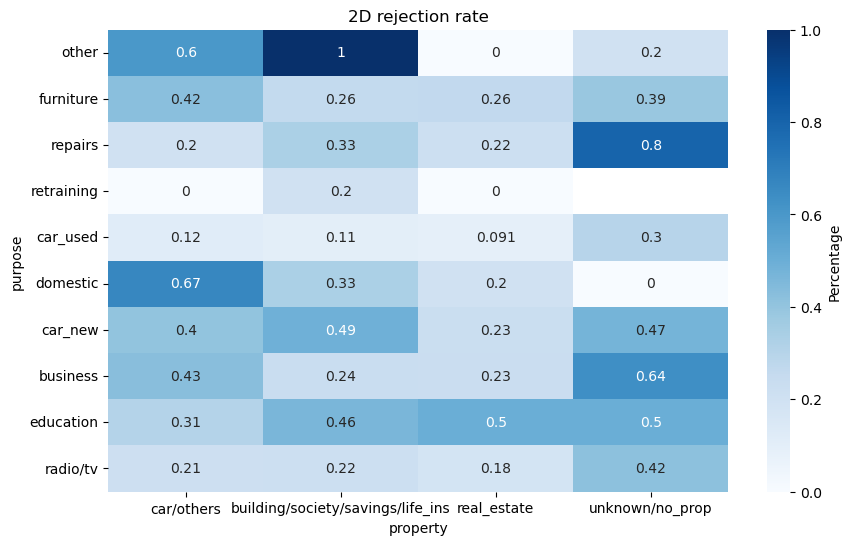

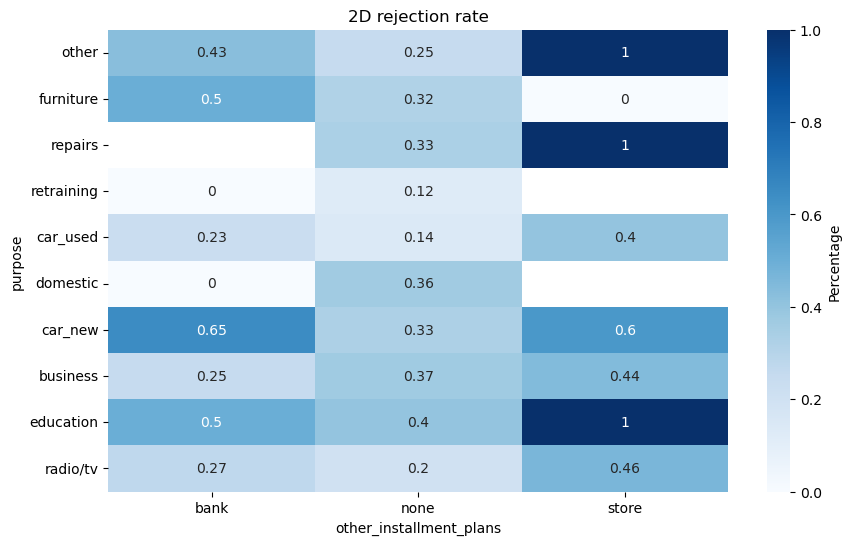

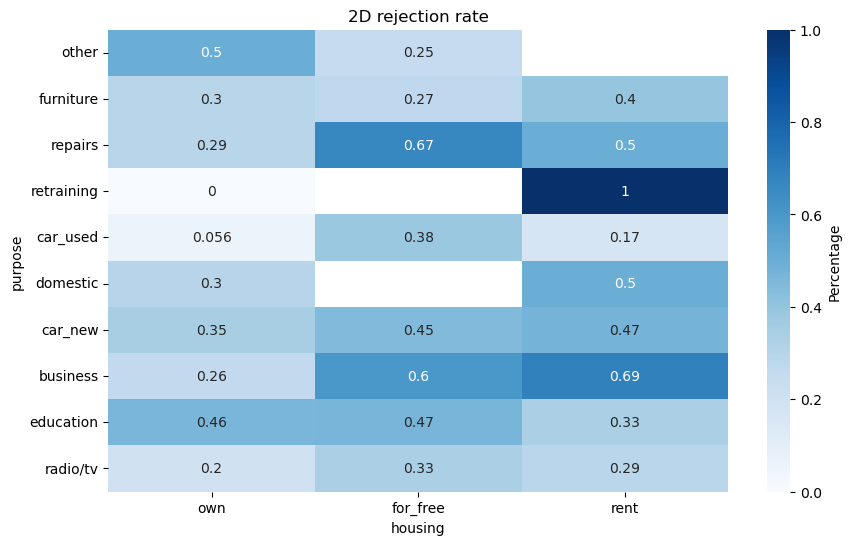

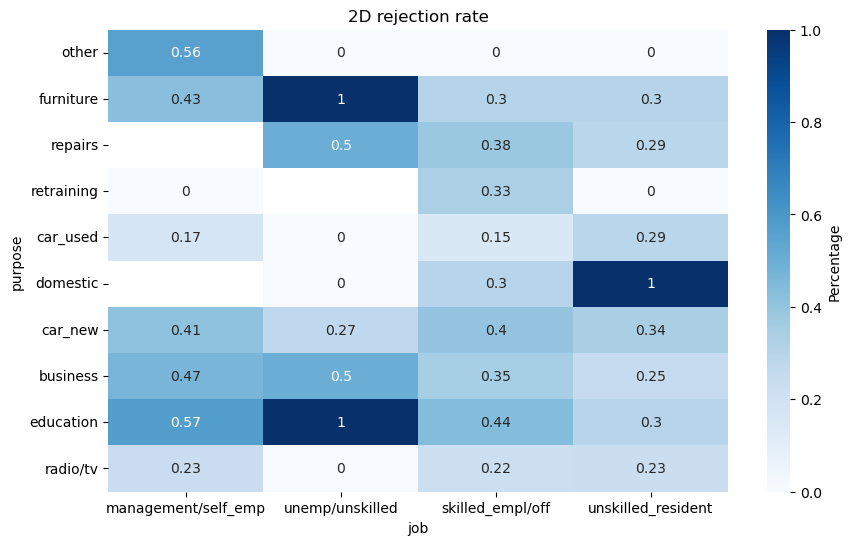

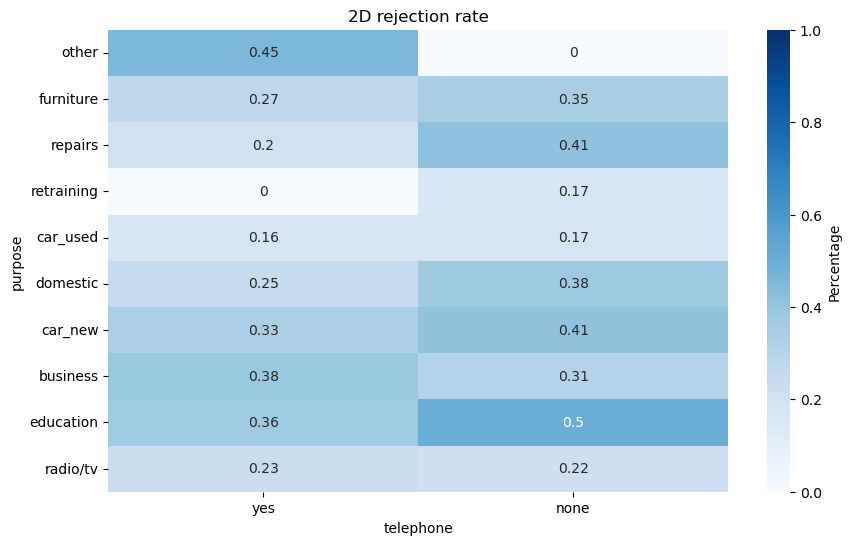

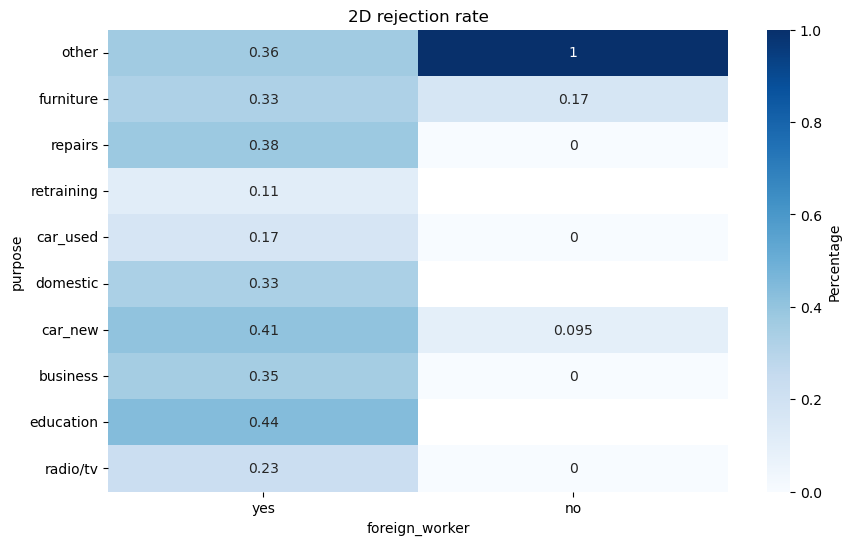

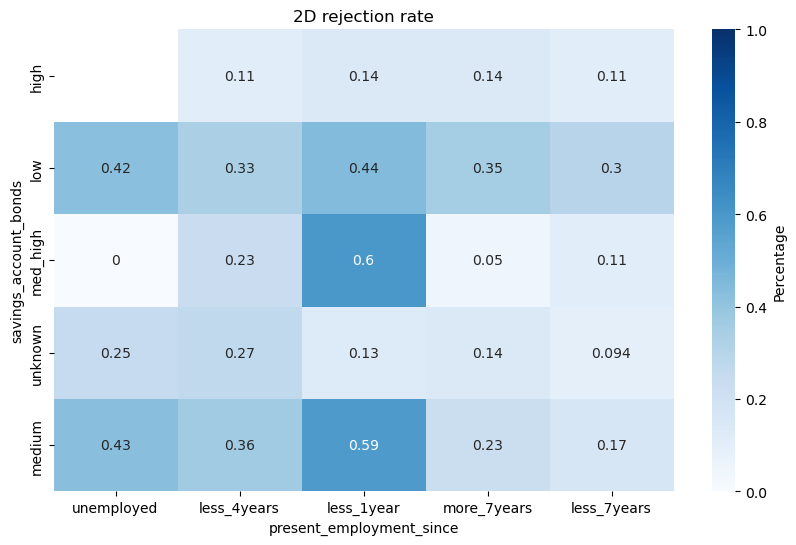

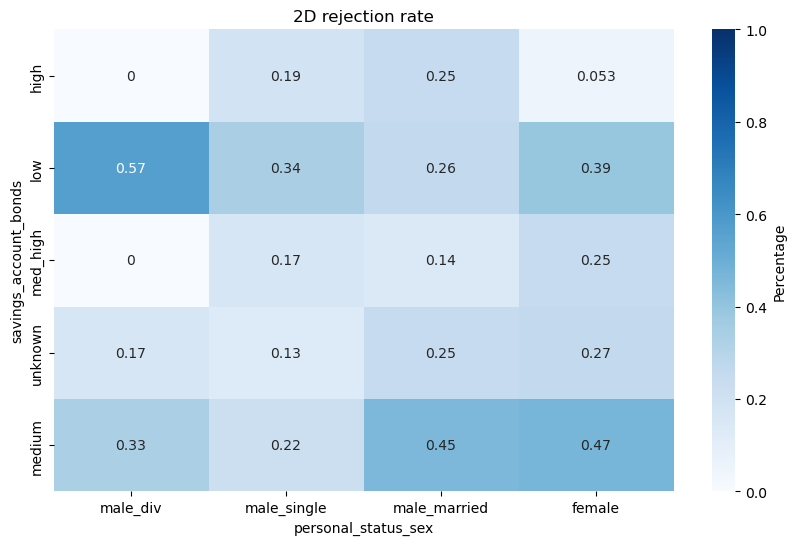

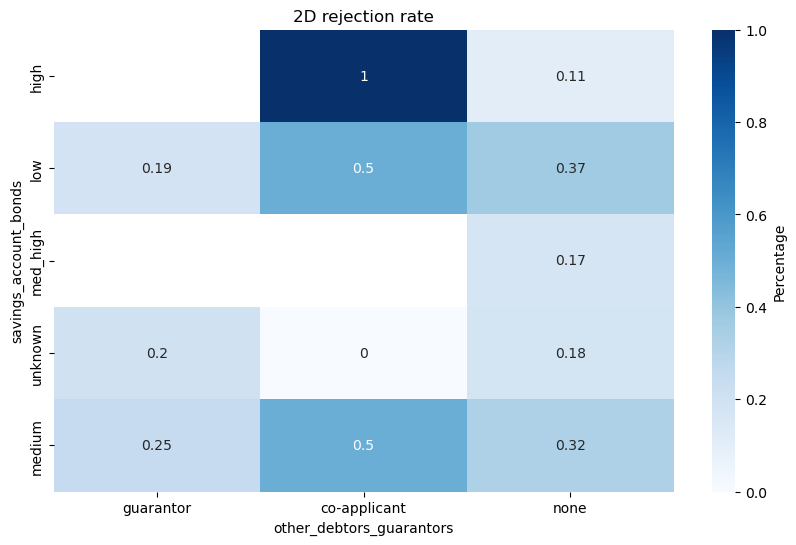

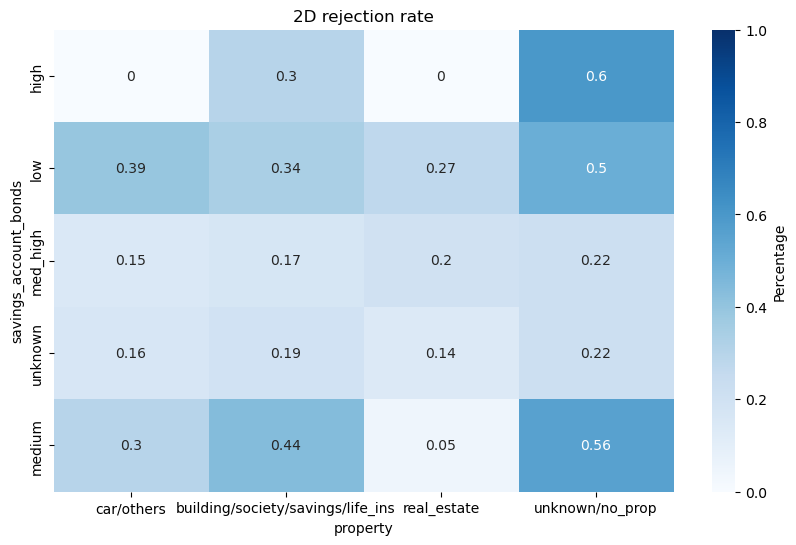

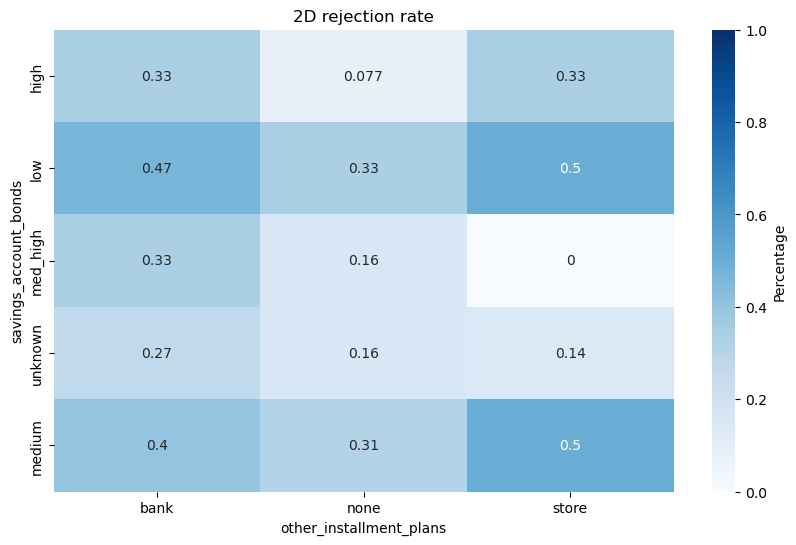

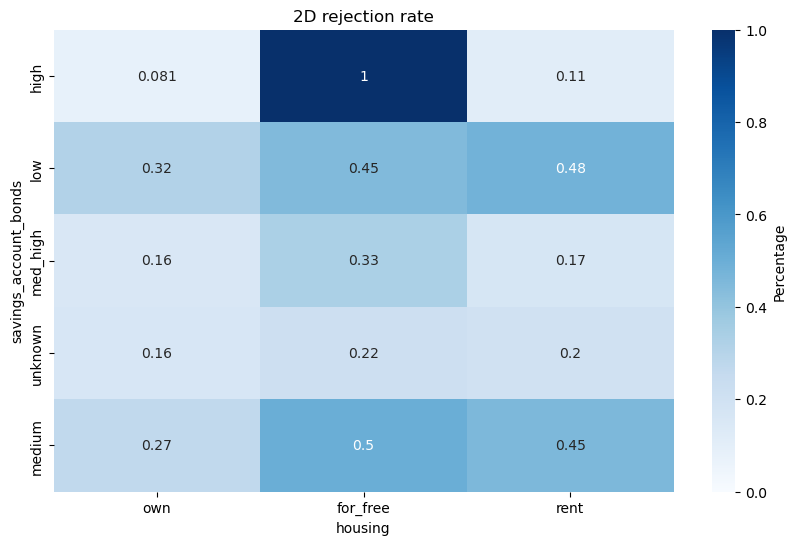

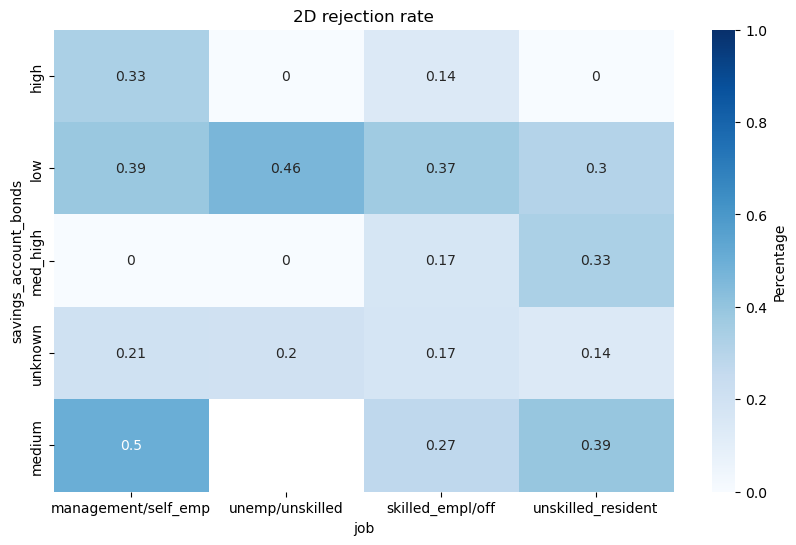

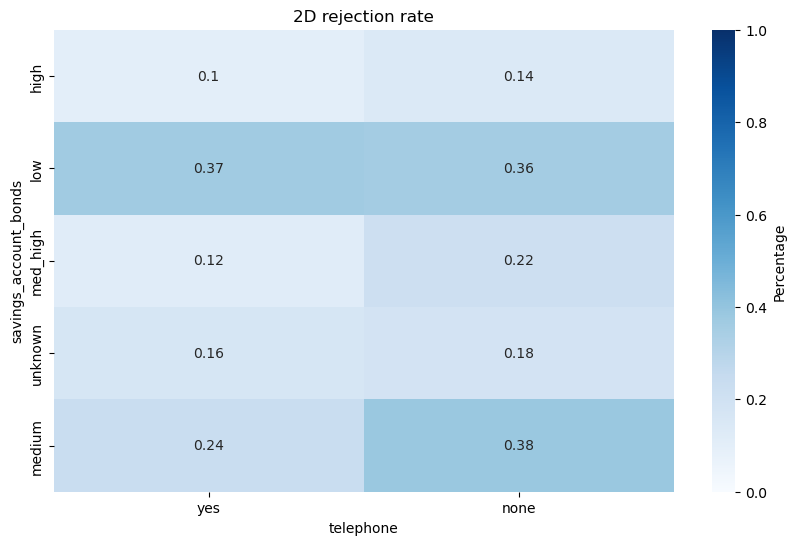

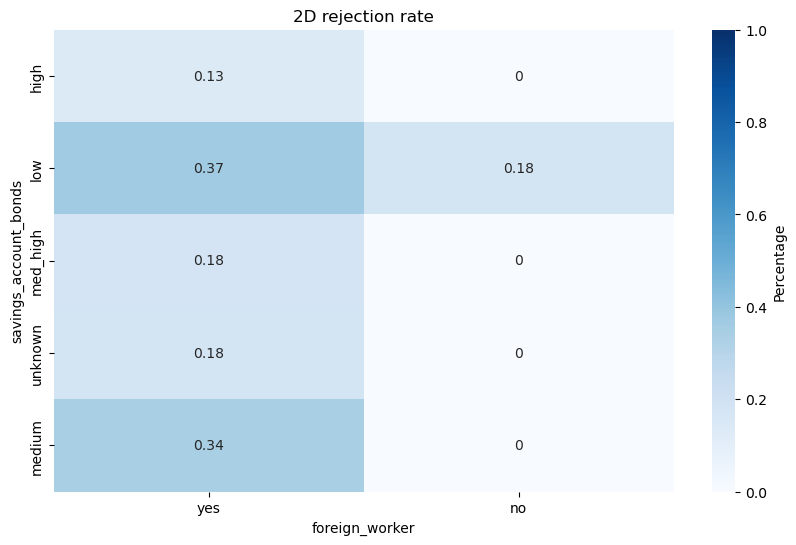

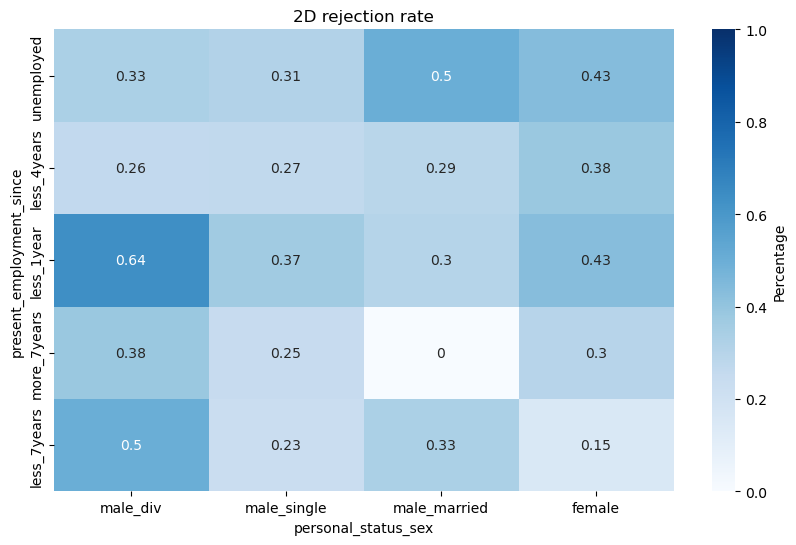

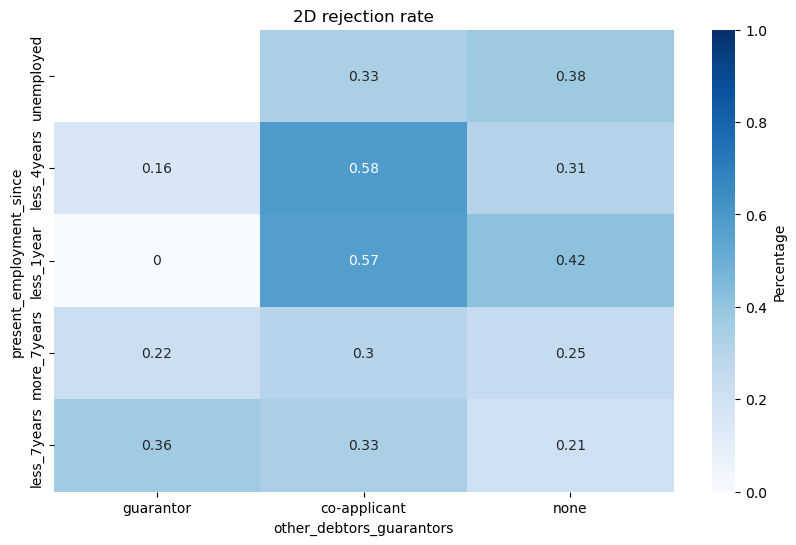

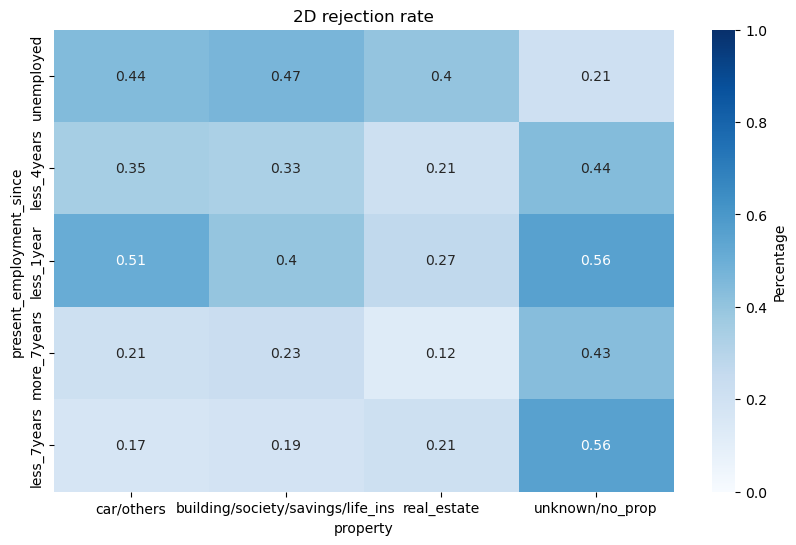

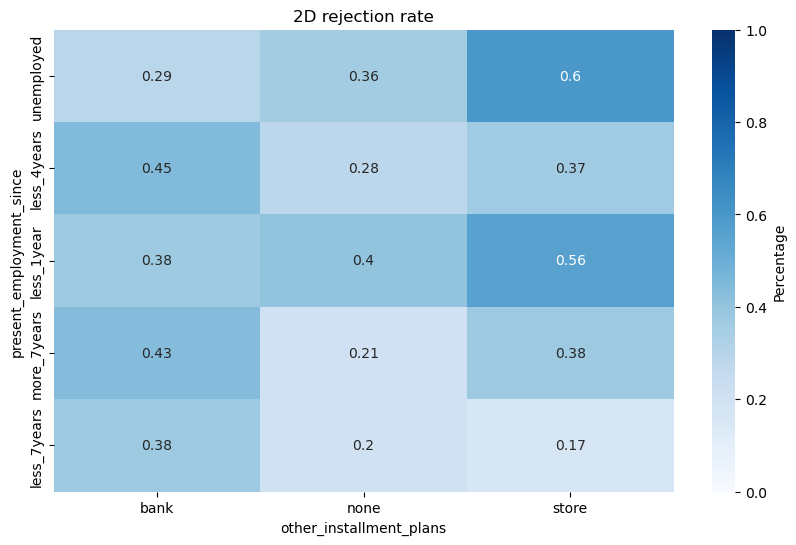

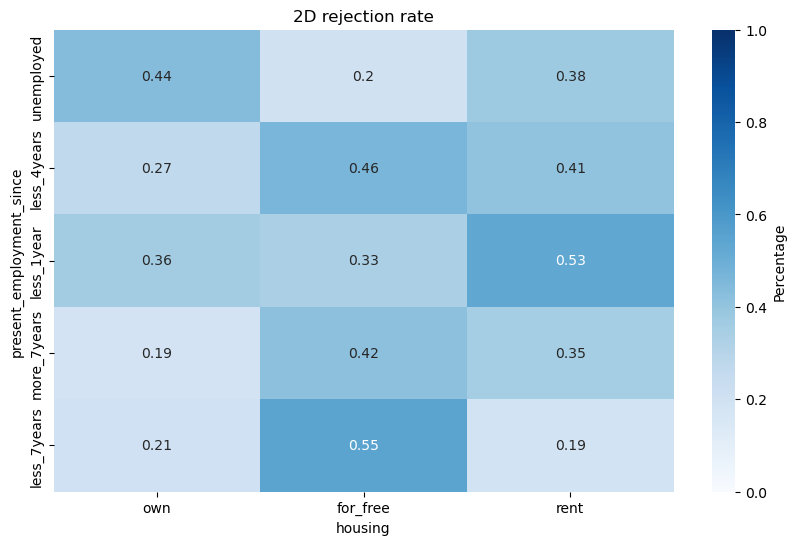

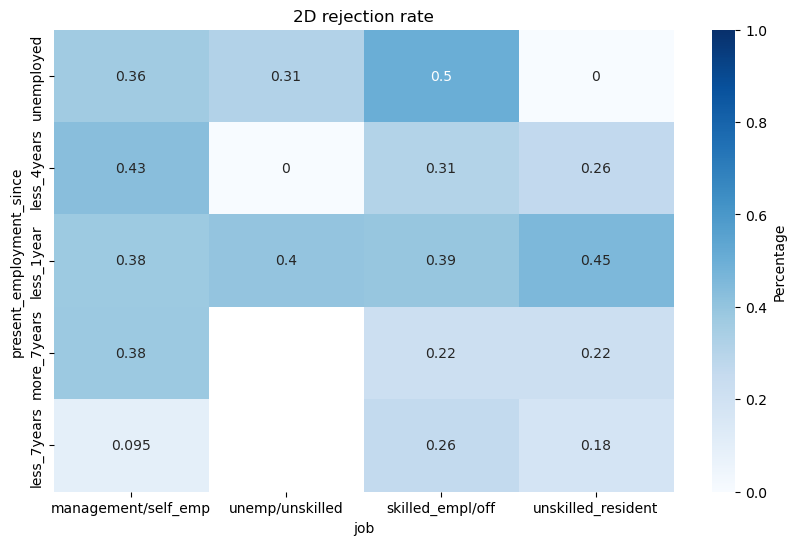

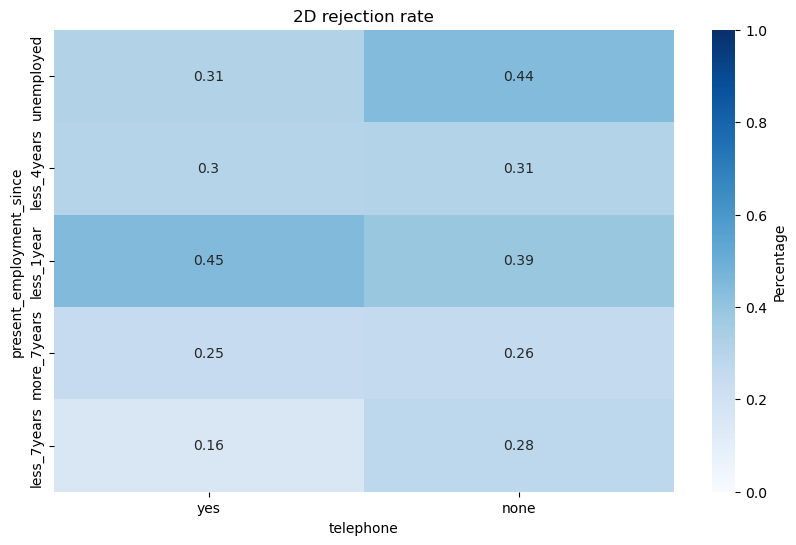

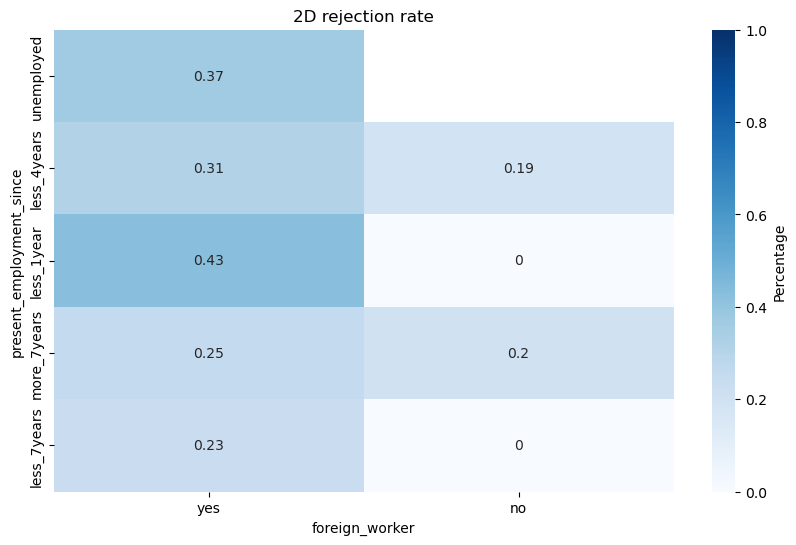

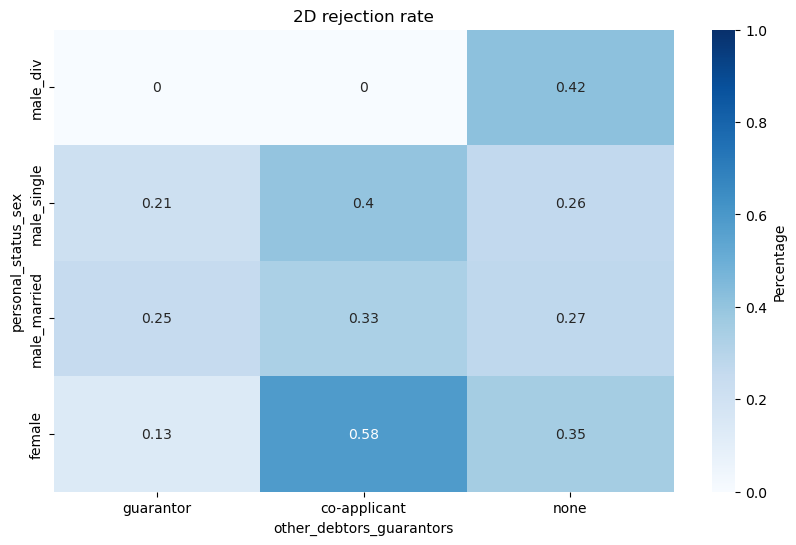

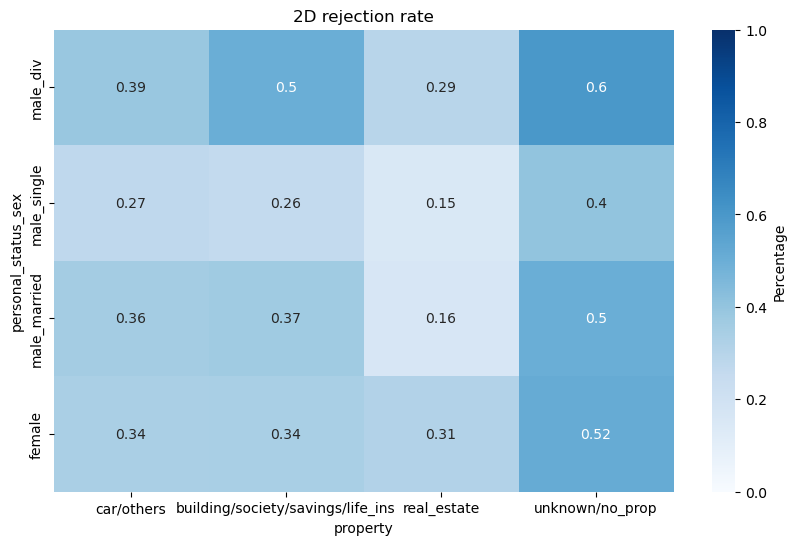

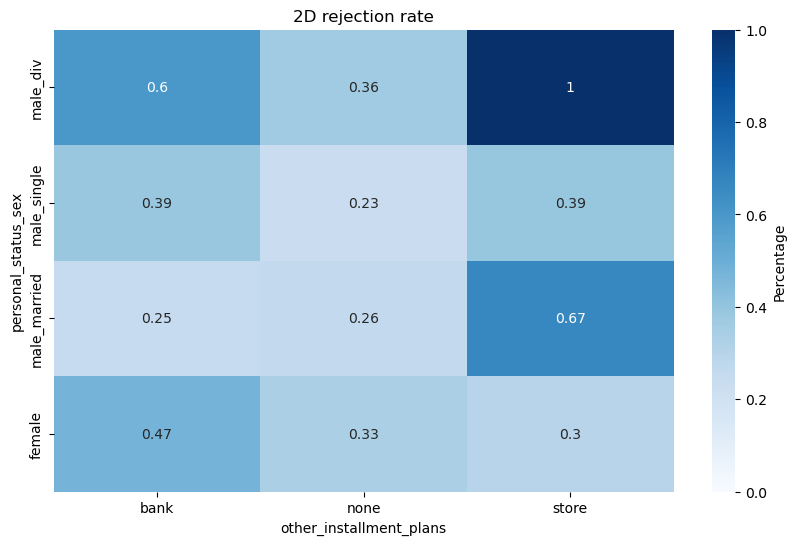

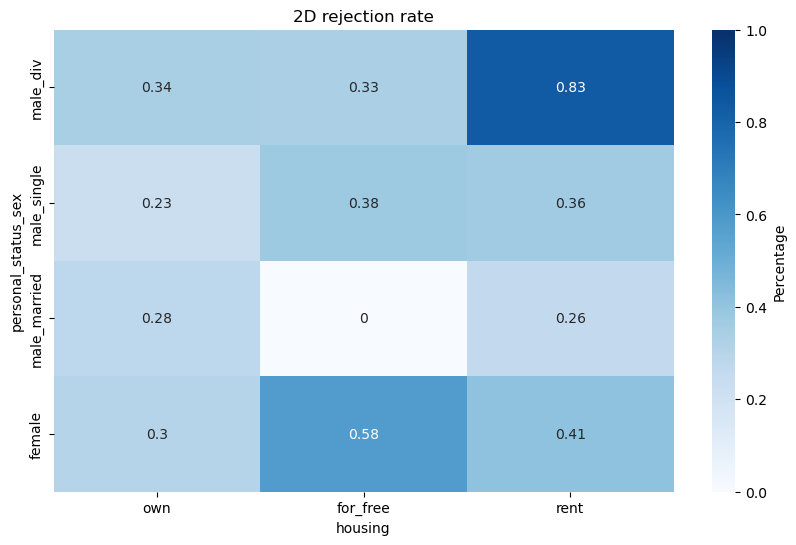

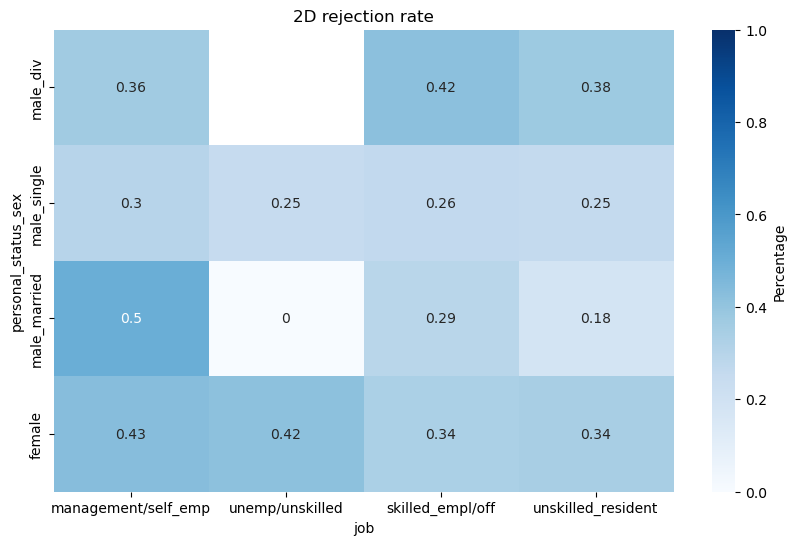

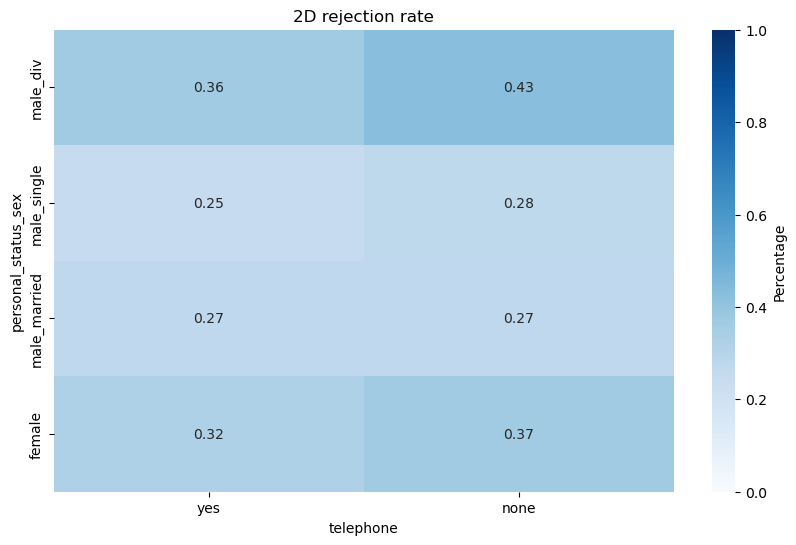

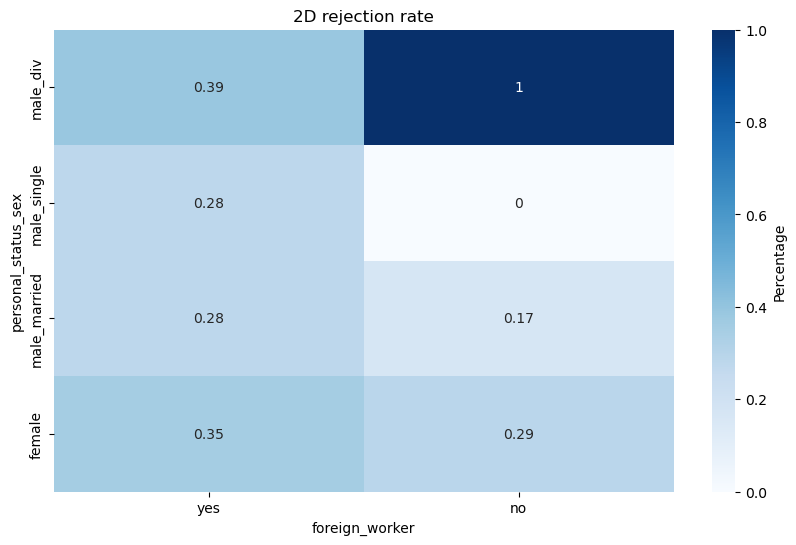

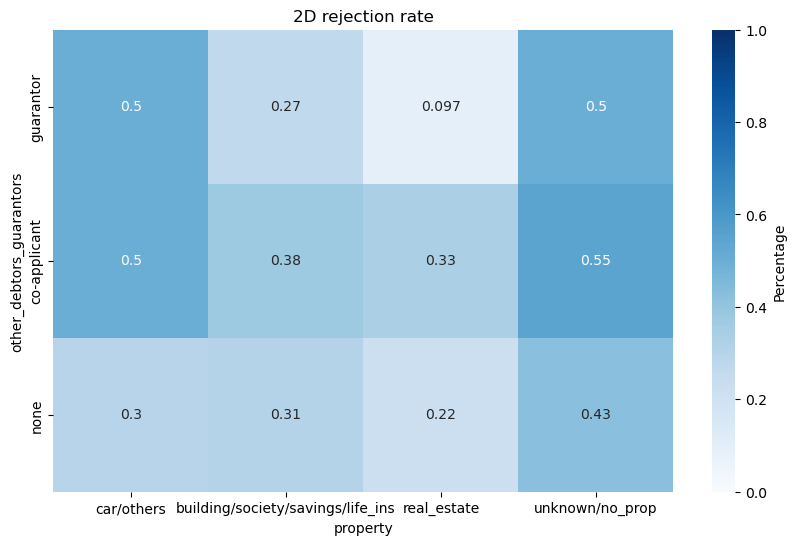

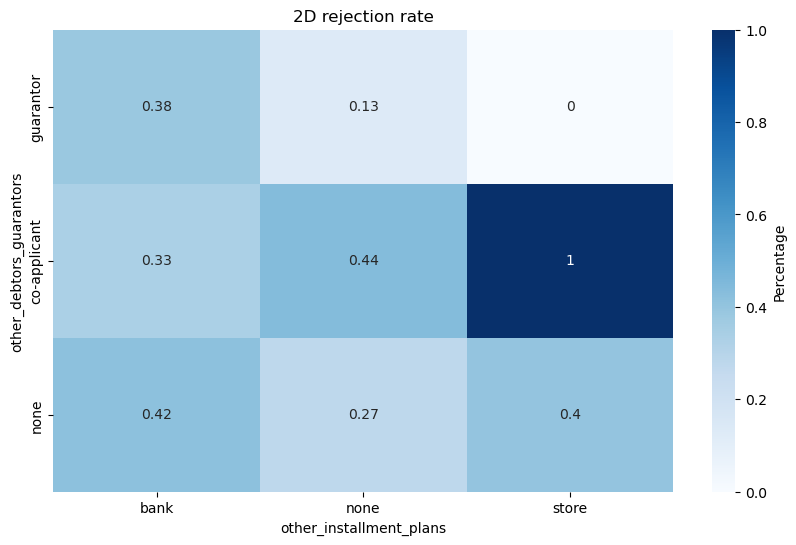

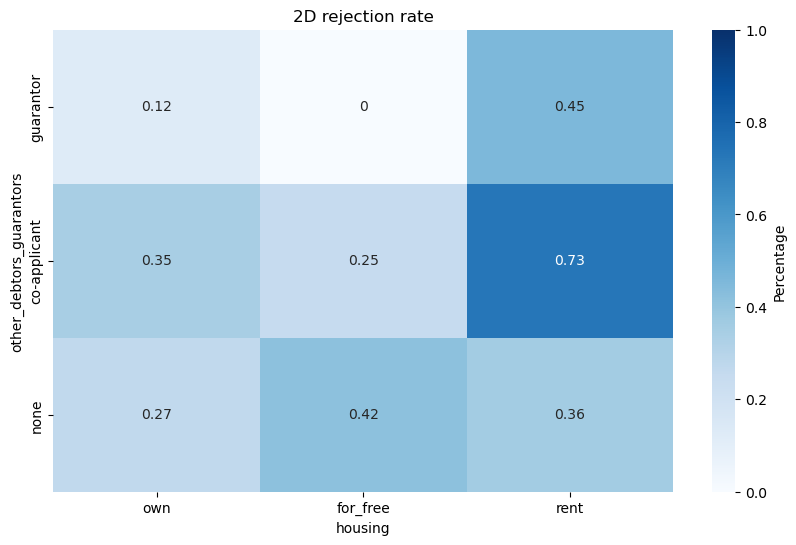

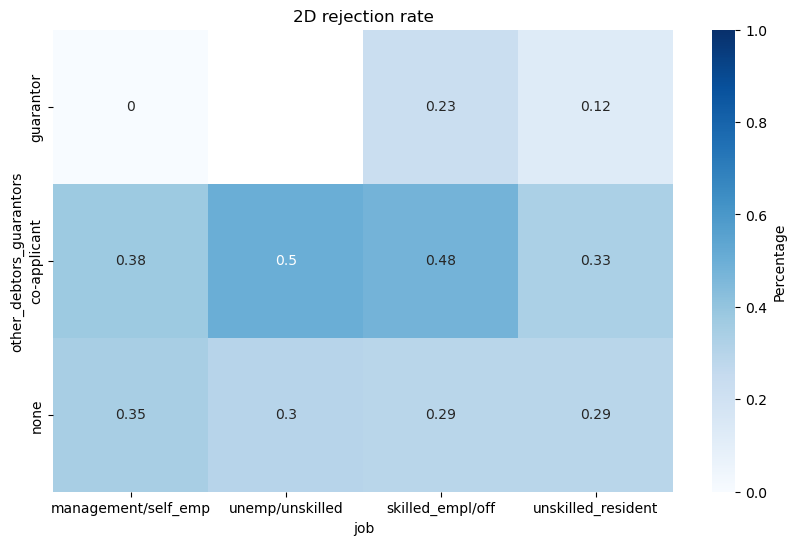

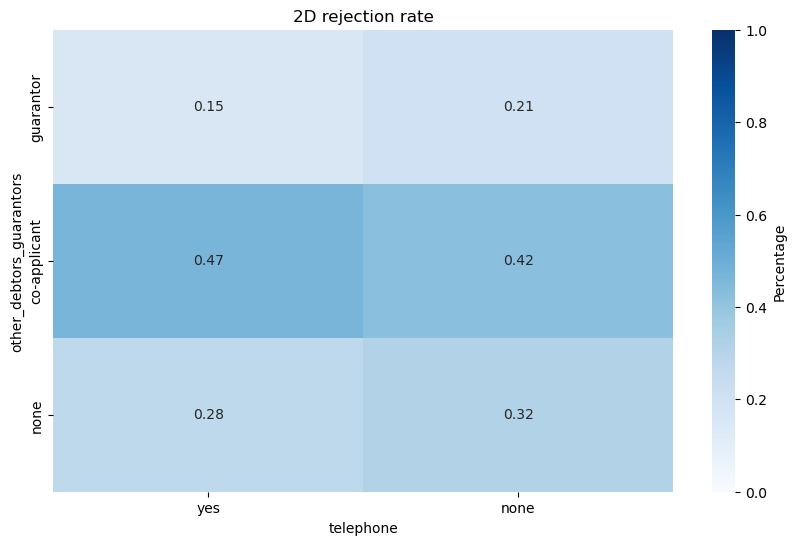

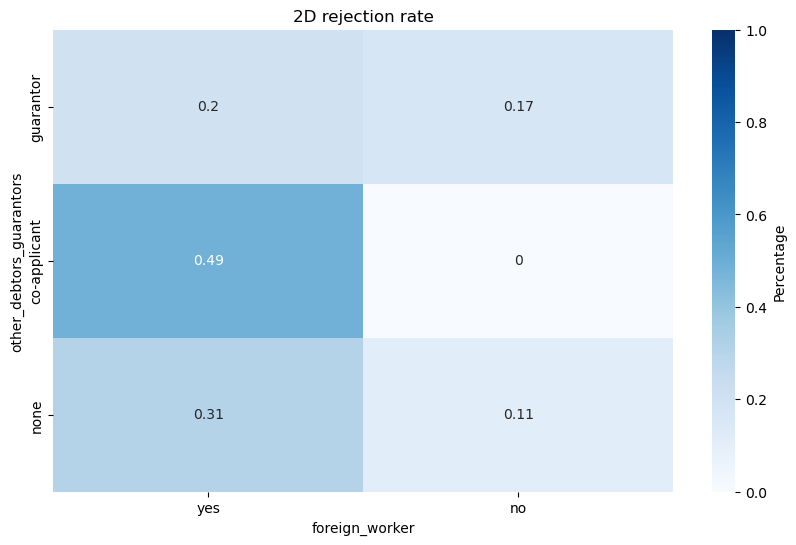

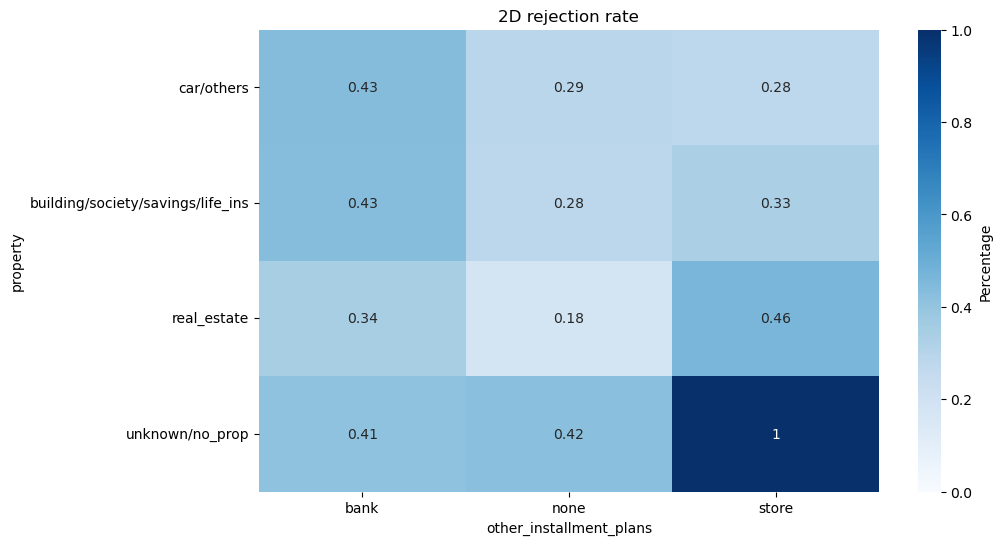

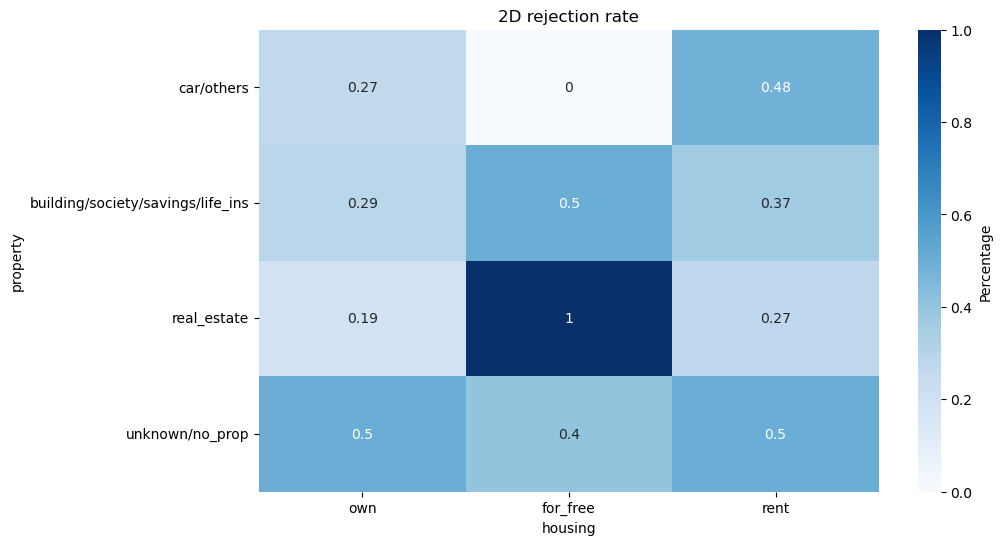

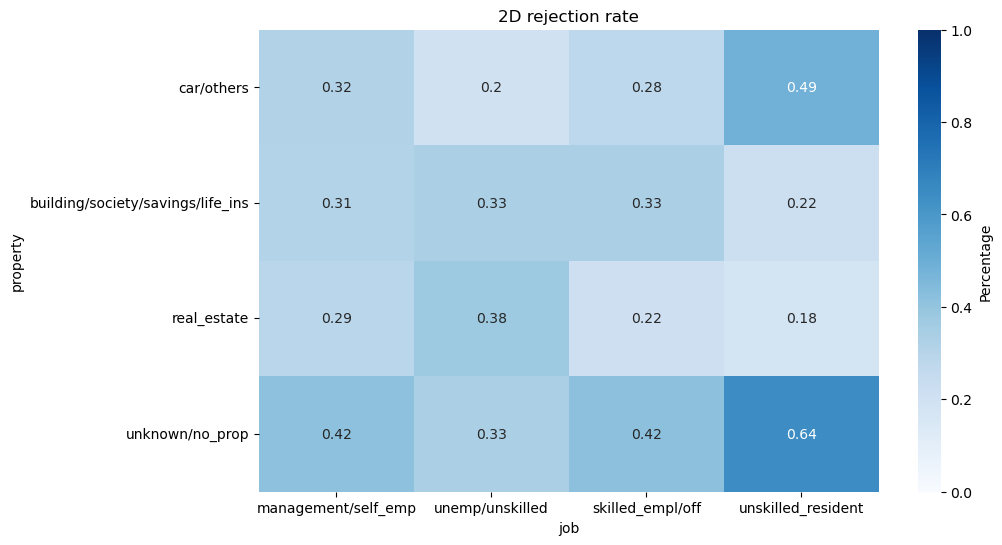

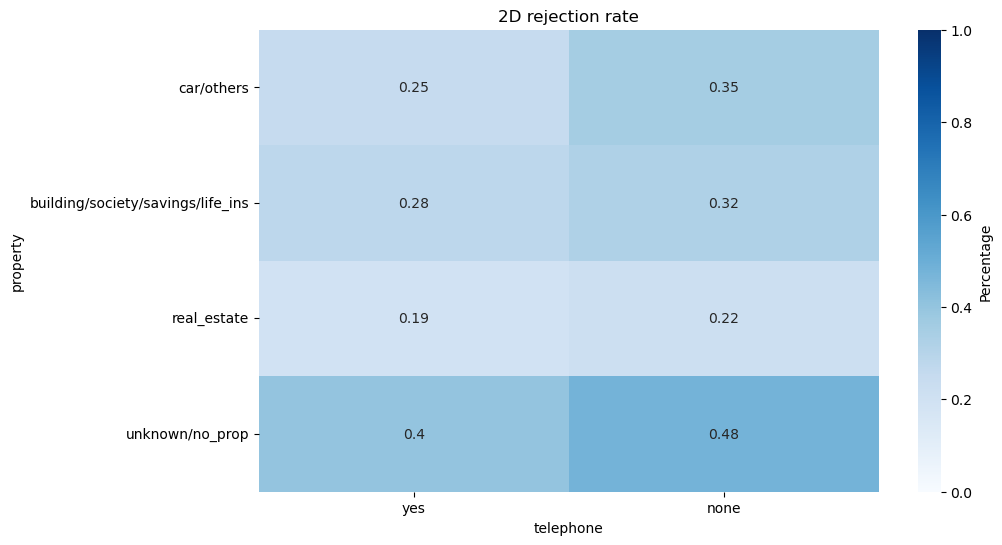

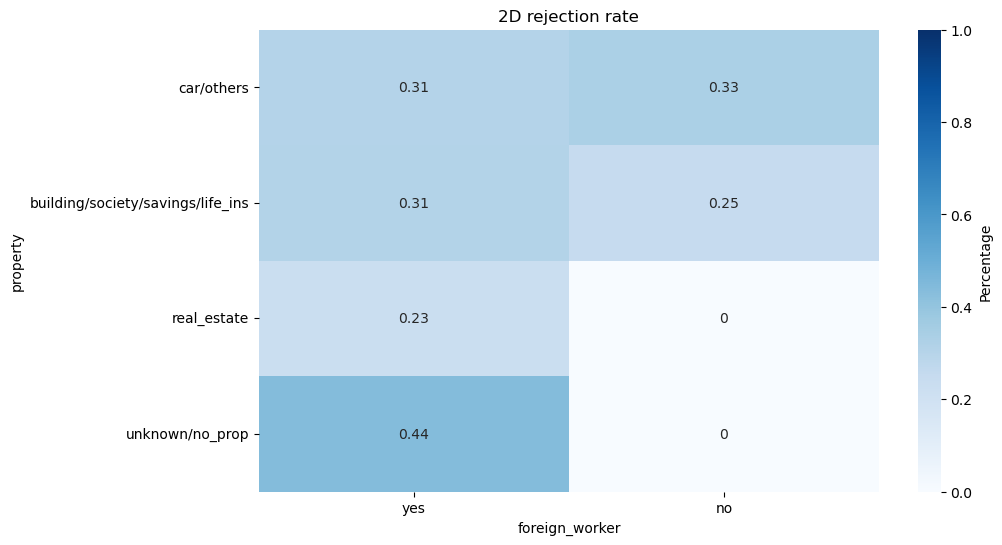

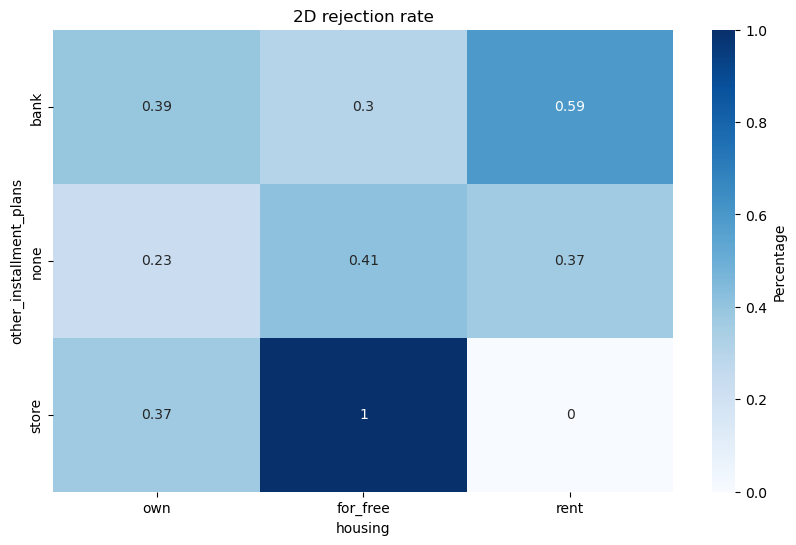

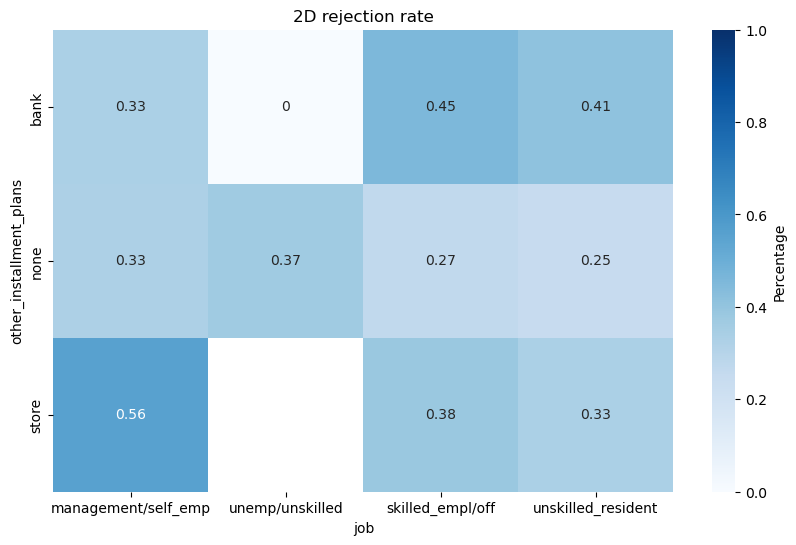

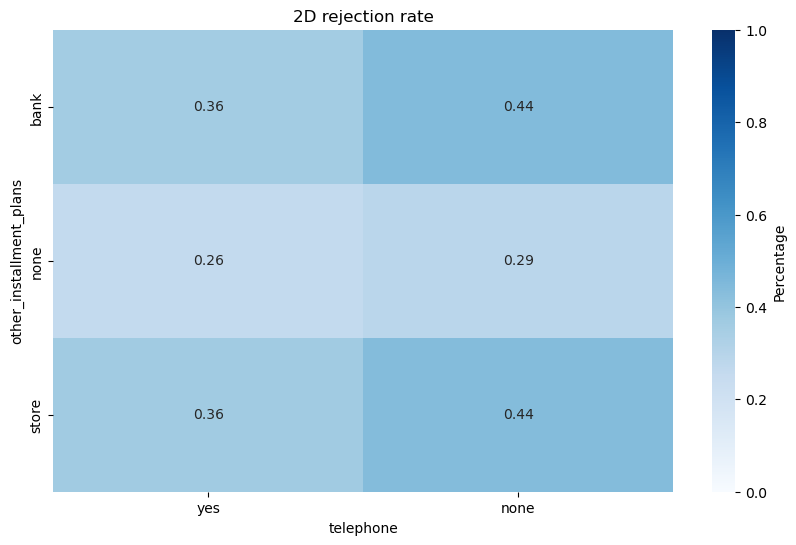

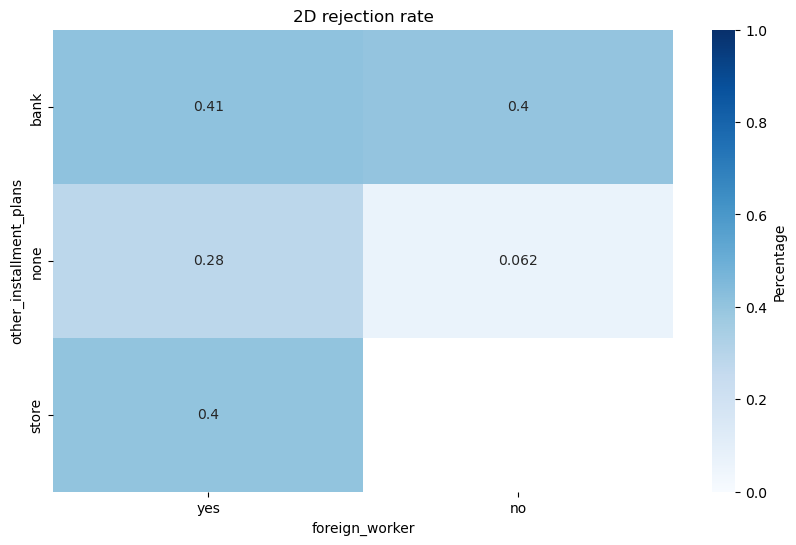

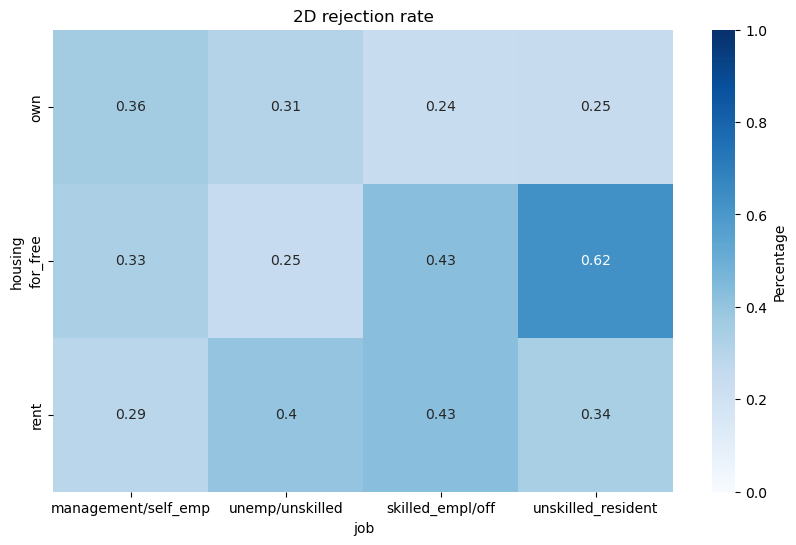

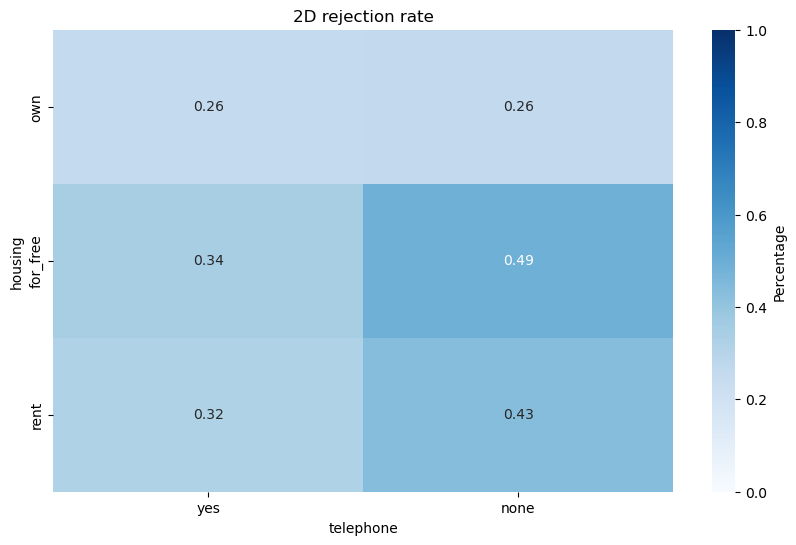

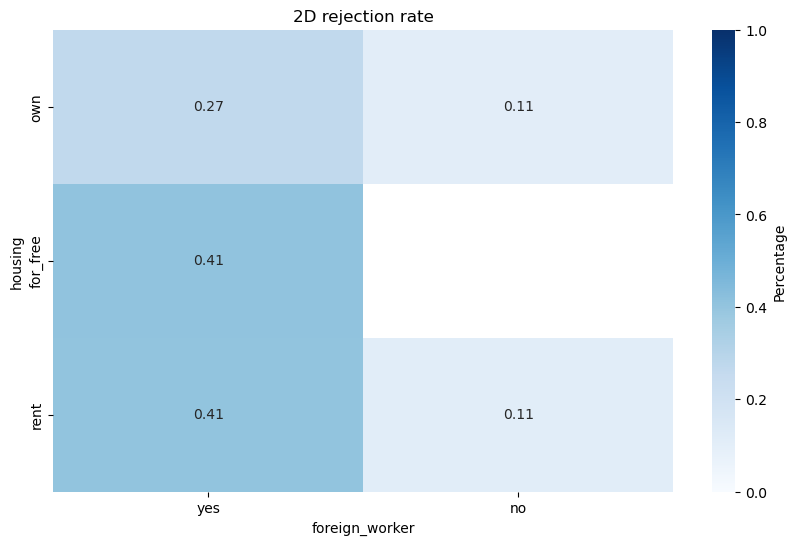

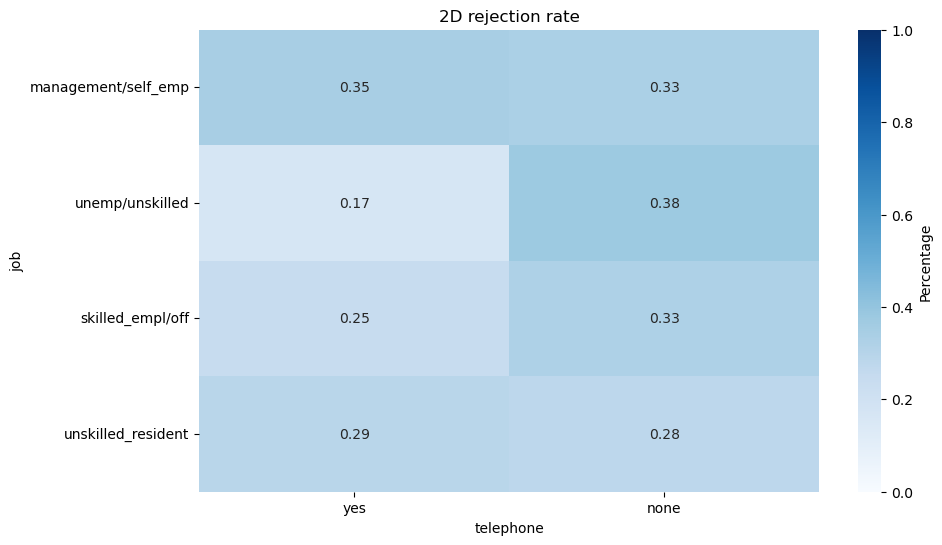

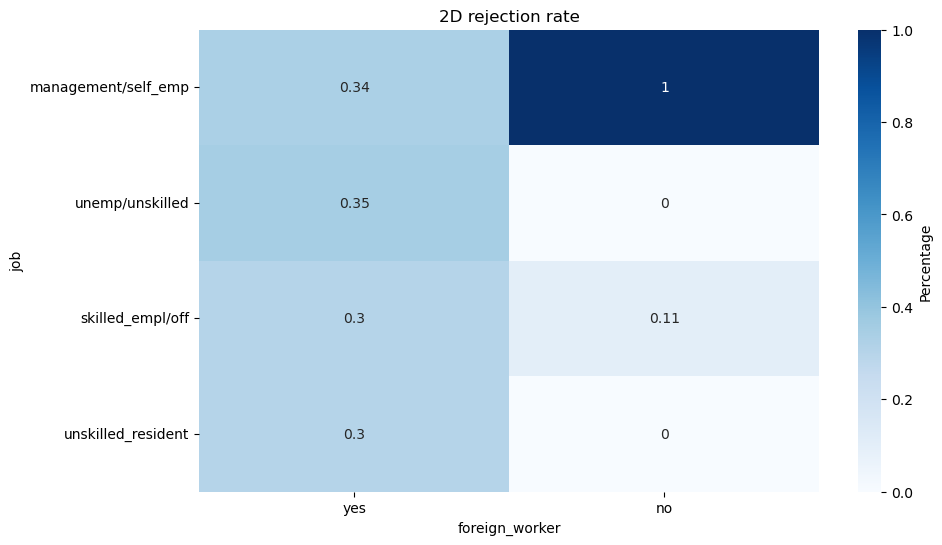

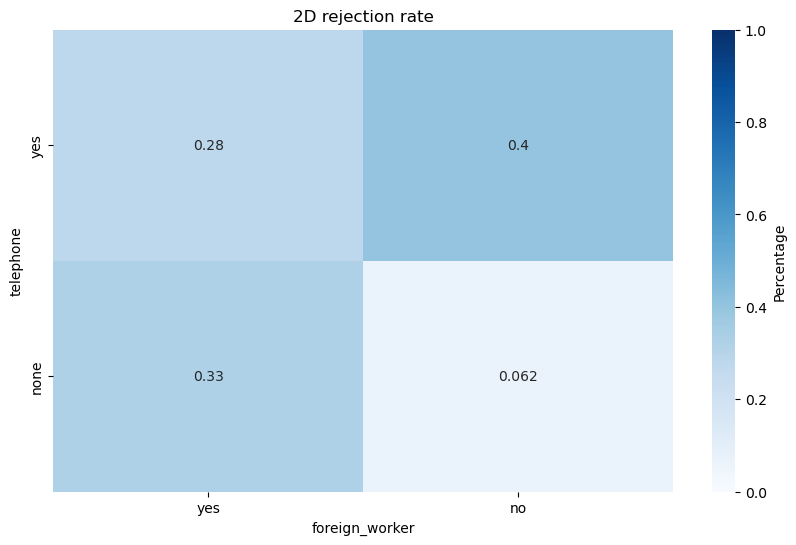

In [13]:
from itertools import combinations

for col1,col2 in combinations(categorical_features, r=2):
    col1_types = list(filter(lambda x: x.startswith(col1), categorical_features_hotencoded))
    col2_types = list(filter(lambda x: x.startswith(col2), categorical_features_hotencoded))
    rejection_rates_2d = pd.DataFrame(index=col1_types, columns=col2_types)
    for cc1 in col1_types:
        for cc2 in col2_types:
            tmp = df_processed.loc[(df_processed[cc1] == 1) & (df_processed[cc2] == 1),:]
            tot = tmp.size
            if tot == 0:
                continue
            neg = tmp[tmp["label"] == 2].size
            rate = neg/tot * 100
            rejection_rates_2d.loc[cc1,cc2] = rate / 100
    rejection_rates_2d.rename(
        index=lambda x: translation[x.split(col1)[1][1:]], inplace=True
    )
    rejection_rates_2d.rename(
        columns=lambda x: translation[x.split(col2)[1][1:]], inplace=True
    )
    rejection_rates_2d = rejection_rates_2d.astype(np.float64)
    plt.figure(figsize=(10,6))
    sns.heatmap(rejection_rates_2d, cmap='Blues', annot=True, vmin=.0, vmax=1, cbar_kws={'label': 'Percentage'})
    plt.title(f'2D rejection rate')
    plt.xlabel(col2)
    plt.ylabel(col1)
    plt.show()
    

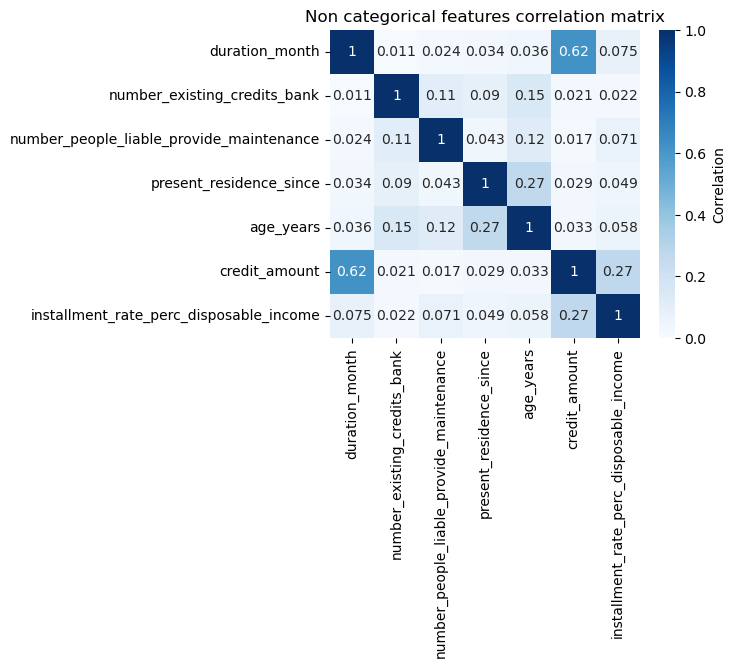

In [95]:
corr_matrix = df[non_categorical_features].corr().abs()
plt.figure(figsize=(5,4))
sns.heatmap(corr_matrix, cmap='Blues', annot=True, vmin=.0, vmax=1, cbar_kws={'label':'Correlation'})
plt.title('Non categorical features correlation matrix')
plt.show()

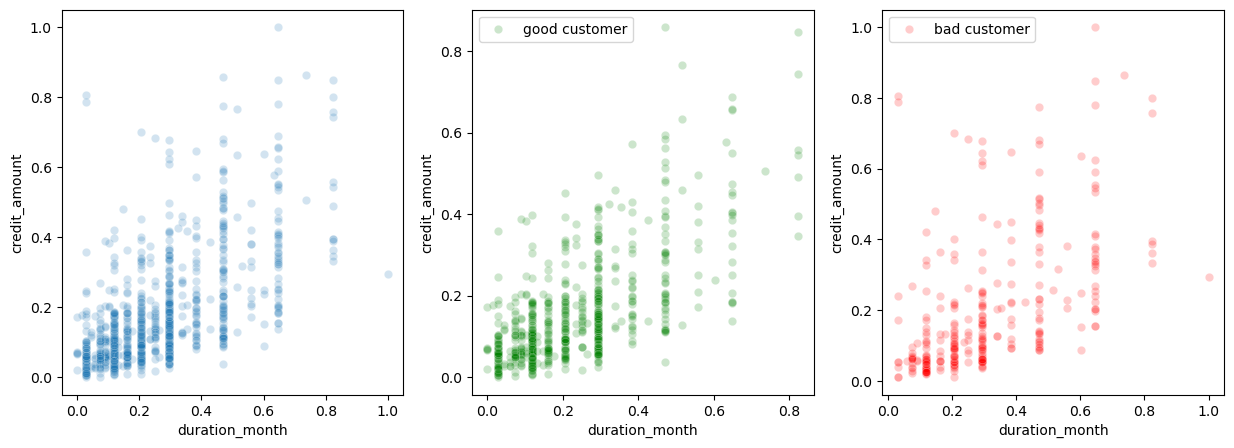

In [96]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
sns.scatterplot(df_processed, y='credit_amount',x='duration_month', alpha=.2, ax=axs[0])
sns.scatterplot(df_processed[df_processed['label'] == 1], y='credit_amount',x='duration_month', alpha=.2, color='green', ax=axs[1], label='good customer')
sns.scatterplot(df_processed[df_processed['label'] == 2], y='credit_amount',x='duration_month', alpha=.2, color='red', ax=axs[2], label='bad customer')
plt.show()

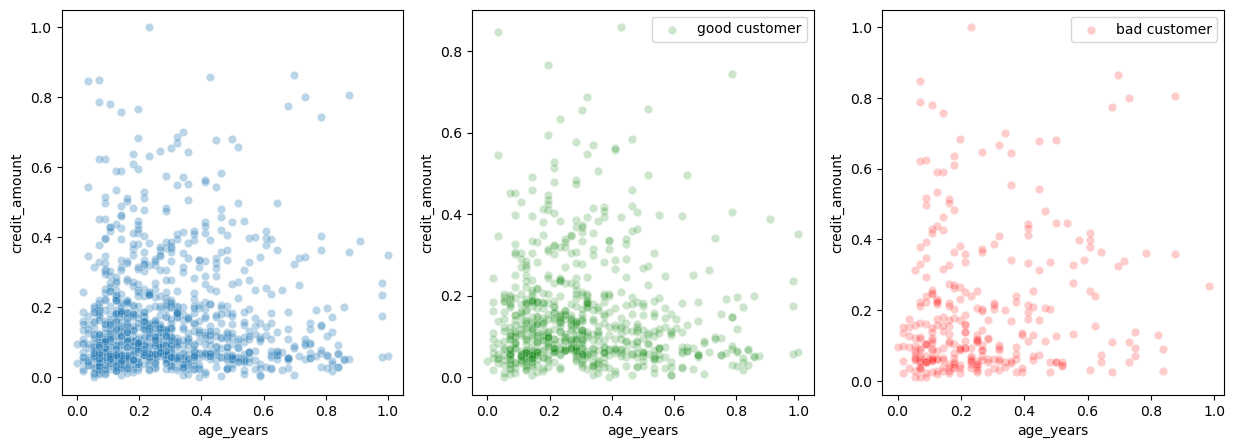

In [97]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
sns.scatterplot(df_processed, y='credit_amount',x='age_years', alpha=.3, ax=axs[0])
sns.scatterplot(df_processed[df_processed['label'] == 1], y='credit_amount',x='age_years', alpha=.2, color='green', ax=axs[1], label='good customer')
sns.scatterplot(df_processed[df_processed['label'] == 2], y='credit_amount',x='age_years', alpha=.2, color='red', ax=axs[2], label='bad customer')
plt.show()

## 2 Unsupervised exploration and clustering

### 2.1 Dimensionality reduction for data visualization

#### Principal Component Analysis

In [99]:
from sklearn.decomposition import PCA

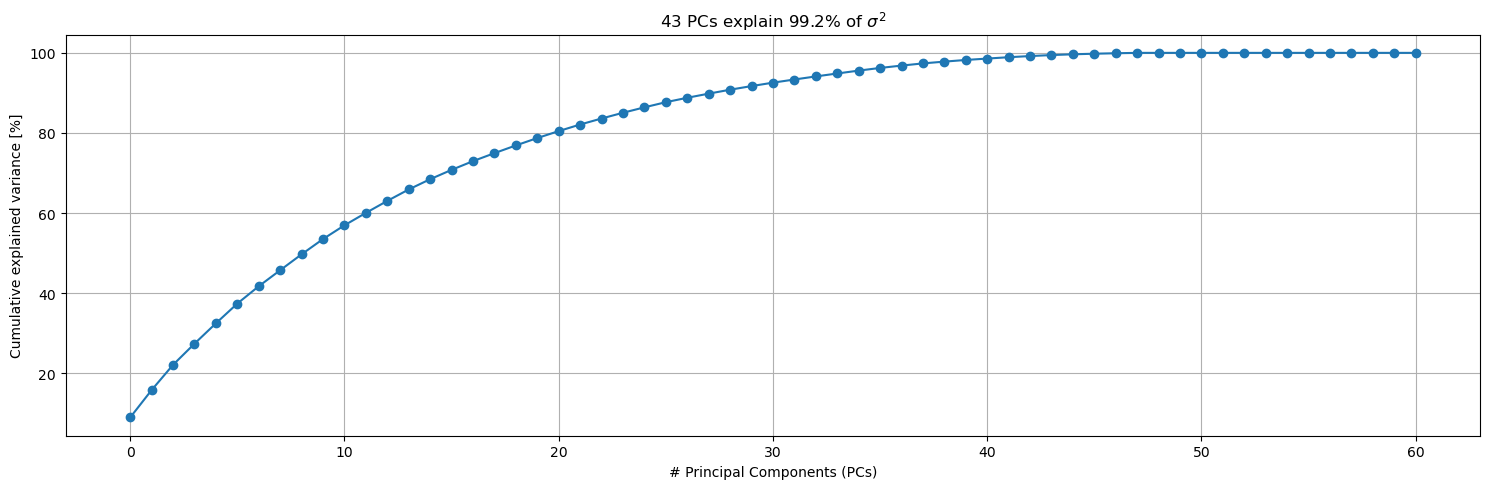

In [100]:
pca = PCA(random_state = GROUP_NUMBER)
features = df_processed.columns.tolist()
features.remove("label")
pca.fit(df_processed[features])

explained_variance = pca.explained_variance_ratio_
perc_cumul_exp_var = np.cumsum(explained_variance) * 100

plt.figure(figsize=(15, 5))
plt.plot(perc_cumul_exp_var, marker='o')
plt.xlabel('# Principal Components (PCs)')
plt.ylabel('Cumulative explained variance [%]')
plt.grid()
plt.title(f'43 PCs explain {round(perc_cumul_exp_var[42], 2)}% of $\sigma^2$')
plt.tight_layout()
plt.show()

By looking at the plot we select choose 43 as a possible number of PCs to select

In [101]:
pca = PCA(n_components=43, random_state=GROUP_NUMBER)

pca.fit(df_processed[features])
pca_result = pca.transform(df_processed[features])

df_pca = pd.DataFrame(pca_result, columns=[f"pc_{i}" for i in range(43)])
df_pca['label'] = df_processed['label']
df_pca

pc_0      pc_1      pc_2      pc_3      pc_4      pc_5      pc_6  \
0    1.093896 -0.671381  0.071017  0.303321  0.084118 -0.110836 -0.417682   
1   -1.416504  0.091914 -0.554413 -0.452032 -0.045156  0.024576 -0.116422   
2   -0.057365 -1.337976  0.891651 -0.151722  0.760248  0.422291 -0.351408   
3   -0.338916  0.466398  1.126655  0.462158 -1.028936 -0.841165 -0.381969   
4    0.126734  0.099974  1.483677  0.675505 -0.634900 -0.680912 -0.411220   
..        ...       ...       ...       ...       ...       ...       ...   
995 -1.110720 -0.061561 -0.003418 -0.086625  0.626471  0.668443 -0.488642   
996  0.324920  1.041201  0.087038 -0.856791  0.197064 -0.279203 -0.891673   
997 -0.014915 -0.808939 -0.476231  0.140822 -0.916645 -0.492958  0.034228   
998  0.572306  0.895386  0.367433  0.039532 -0.977372 -0.702488 -1.093898   
999  0.340852 -0.624195 -0.134619  0.239113 -0.214860 -0.231714  1.296259   

         pc_7      pc_8      pc_9  ...     pc_34     pc_35     pc_36  \
0   -0.405371 -0.494935  1.206839  ...  0.052407 -0.051767 -0.047520   
1   -0.824051  0.472686  0.642354  ... -0.052833 -0.002902  0.209375   
2   -0.055940 -0.264468 -0.330179  ...  0.686248  0.123963  0.066528   
3    0.710006 -0.219607  0.283009  ... -0.204123 -0.155147 -0.789908   
4   -0.133550  1.048460 -0.340213  ... -0.306462 -0.046090 -0.072256   
..        ...       ...       ...  ...       ...       ...       ...   
995  0.089493 -0.819155 -0.394127  ... -0.062367 -0.020371  0.041994   
996  0.673756 -0.135778 -0.094908  ...  0.296768 -0.260133  0.221969   
997 -0.701504 -1.033103 -0.417114  ...  0.093690  0.084741 -0.024112   
998 -0.798148  0.352825  0.164899  ... -0.165448 -0.000030 -0.012743   
999 -0.038549  0.605814  0.071686  ... -0.036124 -0.193325  0.047610   

        pc_37     pc_38     pc_39     pc_40     pc_41     pc_42  label  
0   -0.016265 -0.176023 -0.229730  0.257222 -0.096840 -0.016339      1  
1   -0.016502  0.097444  0.409955  0.022784  0.073513  0.032875      2  
2    0.166973 -0.031675  0.116573  0.029484 -0.296427 -0.161382      1  
3    0.084449 -0.544072  0.558166  0.062337  0.042896 -0.074917      1  
4   -0.078165 -0.108399 -0.092325  0.176682 -0.040676  0.046013      2  
..        ...       ...       ...       ...       ...       ...    ...  
995  0.019686  0.031693  0.017673 -0.079988 -0.048000  0.033705      1  
996  0.018994  0.021738 -0.048504 -0.062509 -0.014422  0.156565      1  
997 -0.082296  0.018459 -0.073524 -0.070119 -0.026942 -0.003834      1  
998 -0.094626  0.020943  0.189848 -0.246600  0.089896  0.025258      2  
999 -0.064254  0.223209  0.369208 -0.155785 -0.268316 -0.295142      1  

[1000 rows x 44 columns]

#### t-SNE visualization

In [126]:
from sklearn.manifold import TSNE

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


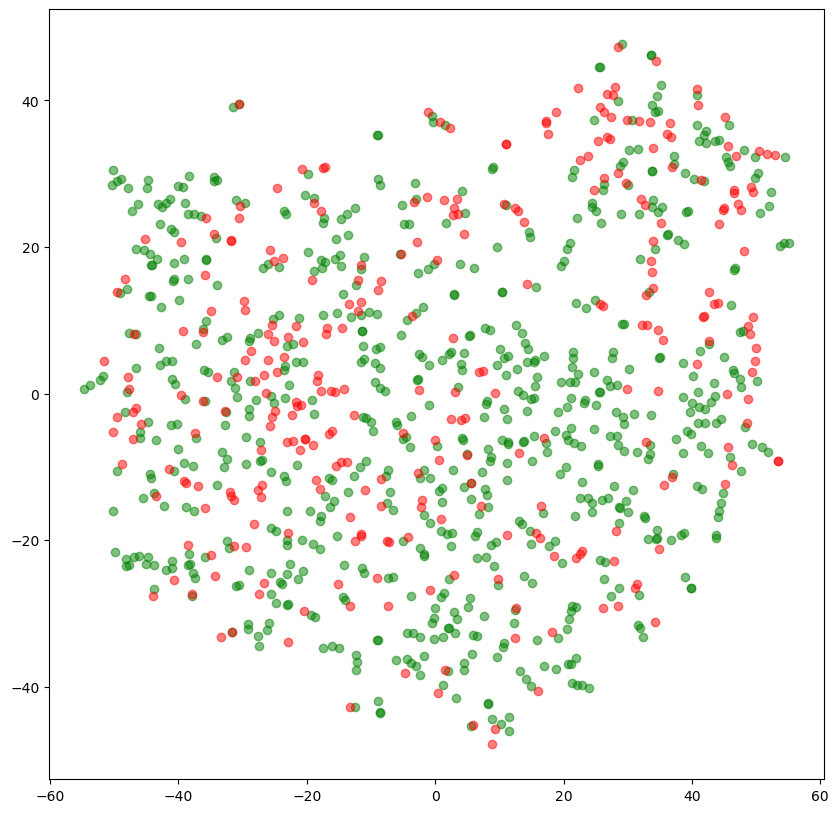

In [127]:
tsne = TSNE(
    n_components=2,
    learning_rate='auto',
    perplexity=15,
    random_state=RANDOM_STATE,
    init='pca'
)
X_nembed = tsne.fit_transform(df_processed[features])

plt.figure(figsize=(10,10))
plt.scatter(X_nembed[df_processed['label'] == 1,0], X_nembed[df_processed['label'] == 1,1], color='green', alpha=.5)
plt.scatter(X_nembed[df_processed['label'] == 2,0], X_nembed[df_processed['label'] == 2,1], color='red', alpha=.5)

plt.show()

### 2.2 Unsupervised Data Analysis

#### k-Means clustering (on PCA transformed data)

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, rand_score

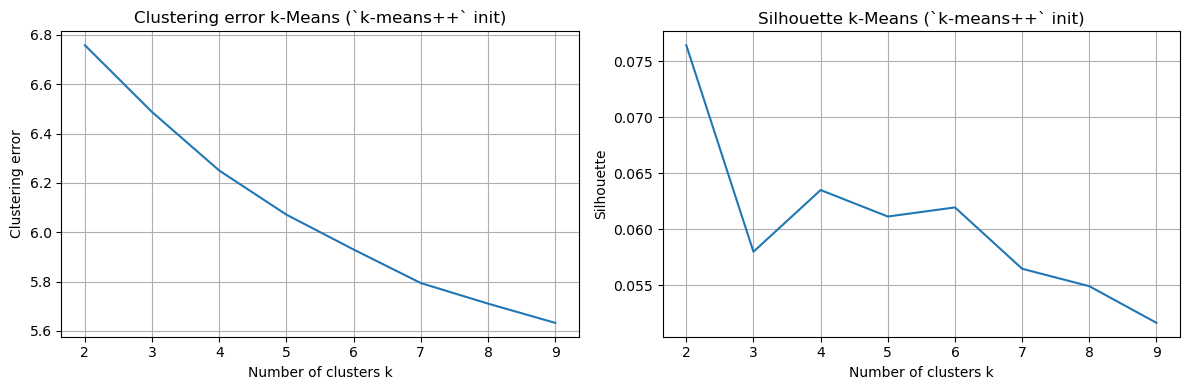

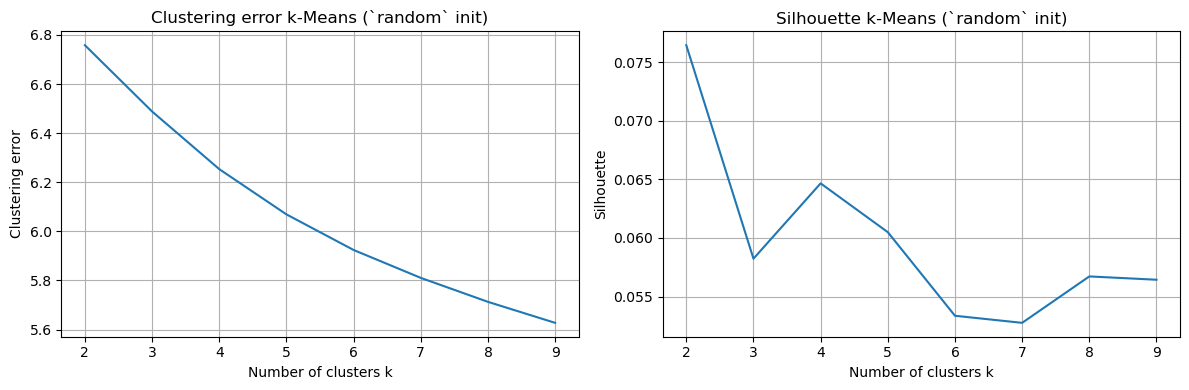

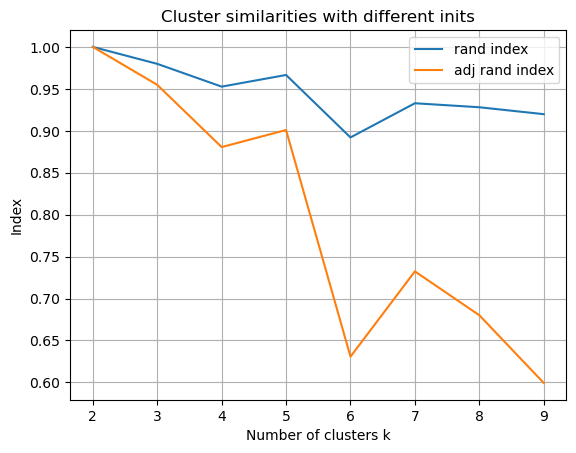

In [19]:
kmeans_sizes = list(range(2,10))
kmeans_errors = [[],[]]
kmeans_silhouettes = [[],[]]
kmeans_rand_scores = []
kmeans_adj_rand_scores = []
_pca_clustering_X = df_pca.loc[:, df_pca.columns != 'label']

for k in kmeans_sizes:
    # k-means with greedy k-means++ init
    km_1 = KMeans(n_clusters=k, init='k-means++', n_init=12)
    km_1.fit(_pca_clustering_X)
    kmeans_errors[0].append(km_1.inertia_ / len(_pca_clustering_X))
    kmeans_silhouettes[0].append(silhouette_score(_pca_clustering_X, km_1.labels_))
    # k-means with random init
    km_2 = KMeans(n_clusters=k, init='random', n_init=12)
    km_2.fit(_pca_clustering_X)
    kmeans_errors[1].append(km_2.inertia_ / len(_pca_clustering_X))
    kmeans_silhouettes[1].append(silhouette_score(_pca_clustering_X, km_2.labels_))
    # clustering comparison
    kmeans_rand_scores.append(rand_score(km_1.labels_, km_2.labels_))
    kmeans_adj_rand_scores.append(adjusted_rand_score(km_1.labels_, km_2.labels_))
    
fig, axs = plt.subplots(1,2, figsize=(12,4))
axs[0].plot(kmeans_sizes, kmeans_errors[0])
axs[0].set_xlabel("Number of clusters k")
axs[0].set_ylabel("Clustering error")
axs[0].set_title('Clustering error k-Means (`k-means++` init)')
axs[0].grid()
axs[1].plot(kmeans_sizes, kmeans_silhouettes[0])
axs[1].set_xlabel("Number of clusters k")
axs[1].set_ylabel("Silhouette")
axs[1].set_title('Silhouette k-Means (`k-means++` init)')
axs[1].grid()
plt.tight_layout()
plt.show()
# seems best for 5

fig, axs = plt.subplots(1,2, figsize=(12,4))
axs[0].plot(kmeans_sizes, kmeans_errors[1])
axs[0].set_xlabel("Number of clusters k")
axs[0].set_ylabel("Clustering error")
axs[0].set_title('Clustering error k-Means (`random` init)')
axs[0].grid()
axs[1].plot(kmeans_sizes, kmeans_silhouettes[1])
axs[1].set_xlabel("Number of clusters k")
axs[1].set_ylabel("Silhouette")
axs[1].set_title('Silhouette k-Means (`random` init)')
axs[1].grid()
plt.tight_layout()
plt.show()
# seems best for 4 or 8

plt.figure()
plt.plot(kmeans_sizes, kmeans_rand_scores, label='rand index')
plt.plot(kmeans_sizes, kmeans_adj_rand_scores, label='adj rand index')
plt.xlabel("Number of clusters k")
plt.ylabel("Index")
plt.title('Cluster similarities with different inits')
plt.legend()
plt.grid()
plt.show()

k-Means - n_clusters=5
Cluster 0 (165) - 0.73 purity of 1
Cluster 1 (186) - 0.56 purity of 1
Cluster 2 (285) - 0.78 purity of 1
Cluster 3 (241) - 0.76 purity of 1
Cluster 4 (123) - 0.57 purity of 1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  # This is added back by InteractiveShellApp.init_path()


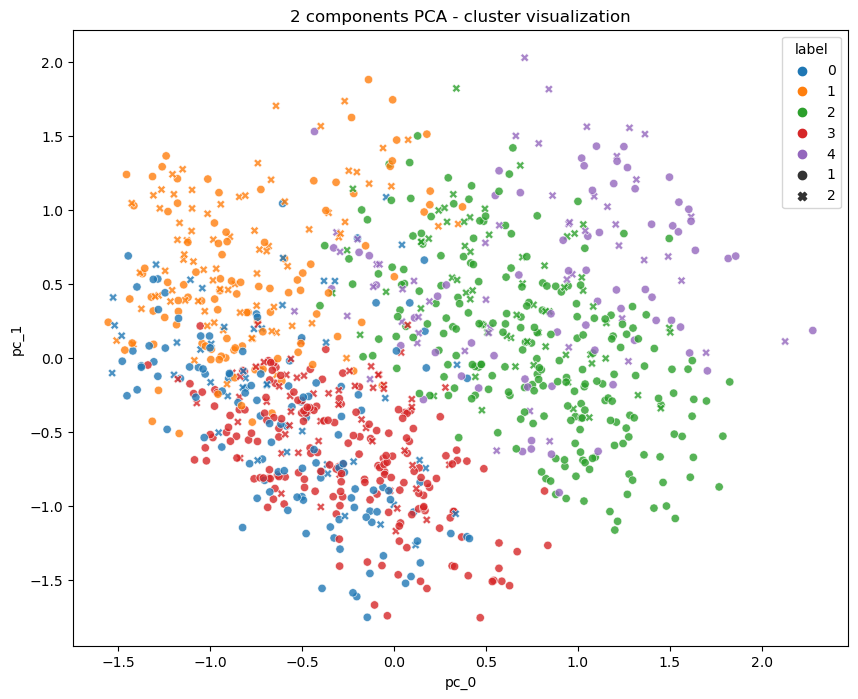

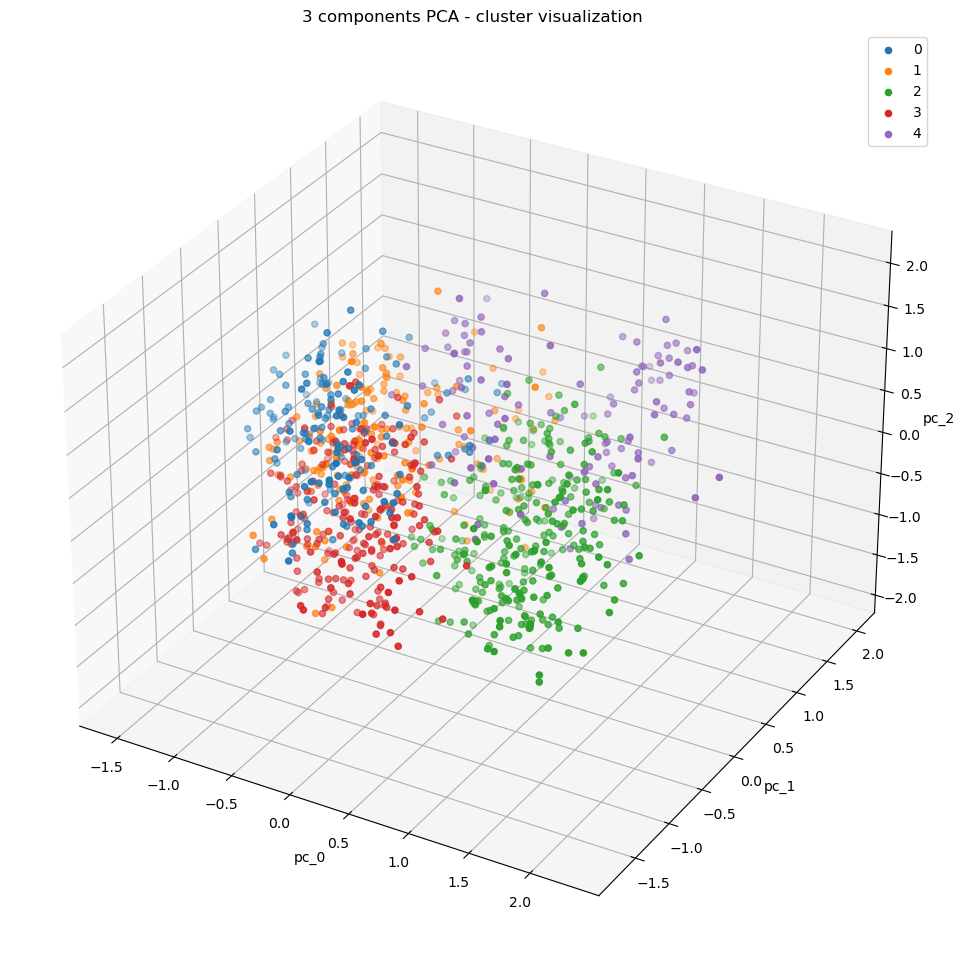

In [37]:
print("k-Means - n_clusters=5")
km = KMeans(n_clusters=5, init='k-means++', n_init=12)
km.fit(_pca_clustering_X)

cluster_sizes = np.bincount(km.labels_)
purity = np.bincount(km.labels_[df_pca['label'] == 1]) / cluster_sizes
print("\n".join(["Cluster %d (%d) - %.2f purity of 1" % (i,cluster_sizes[i],_) for i,_ in enumerate(purity)]))

# 2d visualization
plt.figure(figsize=(10,8))
sns.scatterplot(_pca_clustering_X, x='pc_0', y='pc_1', hue=km.labels_, style=df_pca['label'], alpha=.8, palette=sns.color_palette())
plt.title('2 components PCA - cluster visualization')
plt.xlabel('pc_0')
plt.ylabel('pc_1')
plt.show()

# 3d visualization
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')
for k in set(km.labels_):
    ax.scatter(_pca_clustering_X.loc[km.labels_ == k, 'pc_0'],_pca_clustering_X.loc[km.labels_ == k, 'pc_1'],_pca_clustering_X.loc[km.labels_ == k, 'pc_2'],label=k)
ax.legend()
ax.set_xlabel('pc_0')
ax.set_ylabel('pc_1')
ax.set_zlabel('pc_2')
ax.set_title('3 components PCA - cluster visualization')
plt.show()

#### DBSCAN clustering (on PCA transformed data)

In [123]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

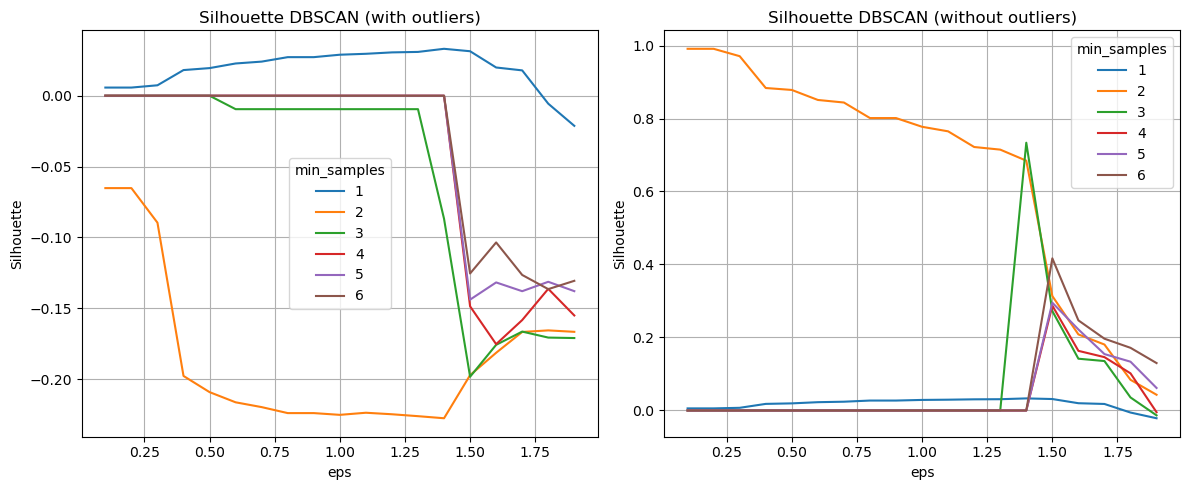

In [125]:
dbscan_nsamples_sizes = list(range(1,7))
dbscan_eps_sizes = np.arange(.1, 2, .1)
_pca_clustering_X = df_pca.loc[:, df_pca.columns != 'label']

fig, axs = plt.subplots(1,2, figsize=(12,5))
for s in dbscan_nsamples_sizes:
    dbscan_silhouettes = []
    dbscan_silhouettes_cleaned = []
    for e in dbscan_eps_sizes:
        dbscan = DBSCAN(eps=e, min_samples=s)
        dbscan.fit(_pca_clustering_X)
        
        dbscan_silhouettes.append(silhouette_score(_pca_clustering_X, dbscan.labels_) if len(set(dbscan.labels_)) > 1 else 0)
        dbscan_silhouettes_cleaned.append(silhouette_score(_pca_clustering_X[dbscan.labels_ != -1], dbscan.labels_[dbscan.labels_ != -1]) if len(set(dbscan.labels_[dbscan.labels_ != -1])) > 1 else 0 )
        
    axs[0].plot(dbscan_eps_sizes, dbscan_silhouettes, label=f'{s}')
    axs[1].plot(dbscan_eps_sizes, dbscan_silhouettes_cleaned, label=f'{s}')

axs[0].set_title('Silhouette DBSCAN (with outliers)')
axs[0].set_xlabel('eps')
axs[0].set_ylabel('Silhouette')
axs[0].legend(title='min_samples')
axs[0].grid()
axs[1].set_title('Silhouette DBSCAN (without outliers)')
axs[1].set_xlabel('eps')
axs[1].set_ylabel('Silhouette')
axs[1].legend(title='min_samples')
axs[1].grid()
plt.tight_layout()
plt.show()

DBSCAN - eps=1.6, min_samples=3
Cluster 1 (13) - 0.69 purity of 1
Cluster 2 (3) - 0.00 purity of 1
Cluster 3 (6) - 0.67 purity of 1
Cluster 4 (49) - 0.92 purity of 1
Cluster 5 (7) - 0.86 purity of 1
Cluster 6 (9) - 1.00 purity of 1
Cluster 7 (13) - 0.77 purity of 1
Cluster 8 (14) - 0.79 purity of 1
Cluster 9 (4) - 0.50 purity of 1
Cluster 10 (3) - 0.67 purity of 1
Cluster 11 (3) - 0.00 purity of 1
Cluster 12 (4) - 1.00 purity of 1
Cluster 13 (4) - 1.00 purity of 1
Cluster 14 (3) - 1.00 purity of 1
Cluster 15 (4) - 1.00 purity of 1
Cluster 16 (3) - 1.00 purity of 1
Cluster 17 (3) - 1.00 purity of 1
Cluster 18 (3) - 0.00 purity of 1
Cluster 19 (3) - 0.67 purity of 1
Outliers: 849 - 0.68 purity of 1


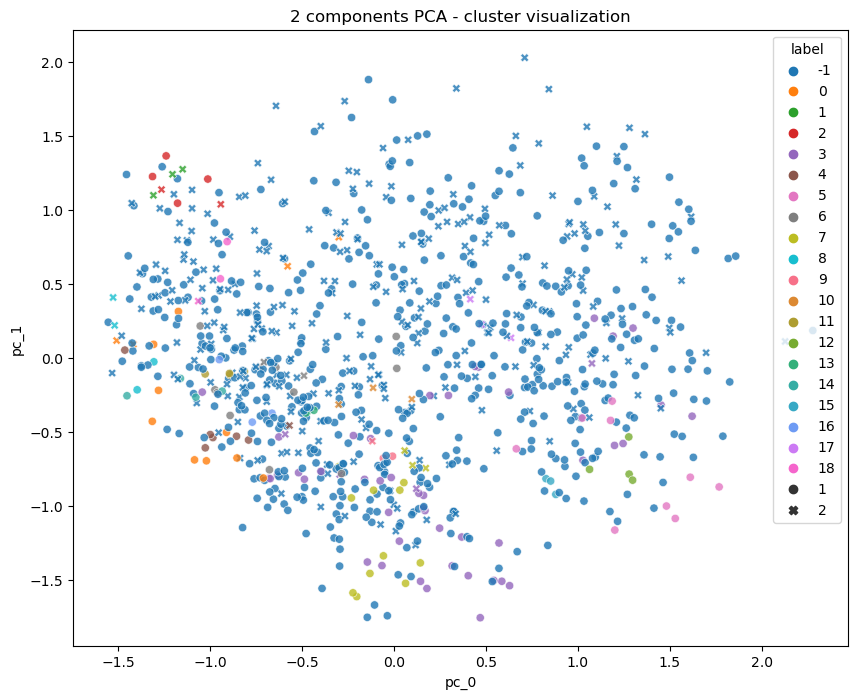

In [126]:
print(f"DBSCAN - eps=1.6, min_samples=3")
dbscan = DBSCAN(eps=1.6, min_samples=3)
dbscan.fit(_pca_clustering_X)

cluster_sizes = np.bincount(dbscan.labels_[dbscan.labels_ != -1])
outliers = (dbscan.labels_ == -1).sum()
purity = np.bincount(dbscan.labels_[(dbscan.labels_ != -1) & (df_pca['label'] == 1)]) / cluster_sizes
print("\n".join(["Cluster %d (%d) - %.2f purity of 1" % (i+1,cluster_sizes[i],_) for i,_ in enumerate(purity)]))
print("Outliers: %d - %.2f purity of 1" % (outliers, abs(dbscan.labels_[(dbscan.labels_ == -1) & (df_pca['label'] == 1)].sum()) / outliers))

# 2d visualization
plt.figure(figsize=(10,8))
sns.scatterplot(_pca_clustering_X, x='pc_0', y='pc_1', hue=dbscan.labels_, style=df_pca['label'], alpha=.8, palette=sns.color_palette() + sns.color_palette('husl',10))
plt.title('2 components PCA - cluster visualization')
plt.xlabel('pc_0')
plt.ylabel('pc_1')
plt.show()

#### k-Prototypes clustering (on mixed data)

In [119]:
from kmodes.kprototypes import KPrototypes
from kmodes.util.dissim import euclidean_dissim, jaccard_dissim_binary
from sklearn.metrics import silhouette_score

def custom_distance_metric(a_num, a_cat, b_num, b_cat, g):
    return euclidean_dissim(a_num, b_num) + g * jaccard_dissim_binary(a_cat, b_cat)

In [120]:
# dataset for clustering (no label feature)
clustering_X = df_processed.loc[:,df_processed.columns != 'label']

_non_categorical_indexer = clustering_X.columns.get_indexer(non_categorical_features).tolist()
_categorical_indexer = clustering_X.columns.get_indexer(categorical_features_hotencoded).tolist()
# precompute distance matrix following k-prototypes internal implementation
_gamma = 0.5 * np.mean(clustering_X.loc[:,non_categorical_features].std(axis=0))

_distance_matrix = np.array([custom_distance_metric(
        clustering_X.to_numpy()[:,_non_categorical_indexer],
        clustering_X.to_numpy()[:,_categorical_indexer].astype(int),
        clustering_X.to_numpy()[i,_non_categorical_indexer],
        clustering_X.to_numpy()[i,_categorical_indexer].astype(int),
        _gamma
    ) for i in range(len(clustering_X))])
_gamma

0.13080245046463496

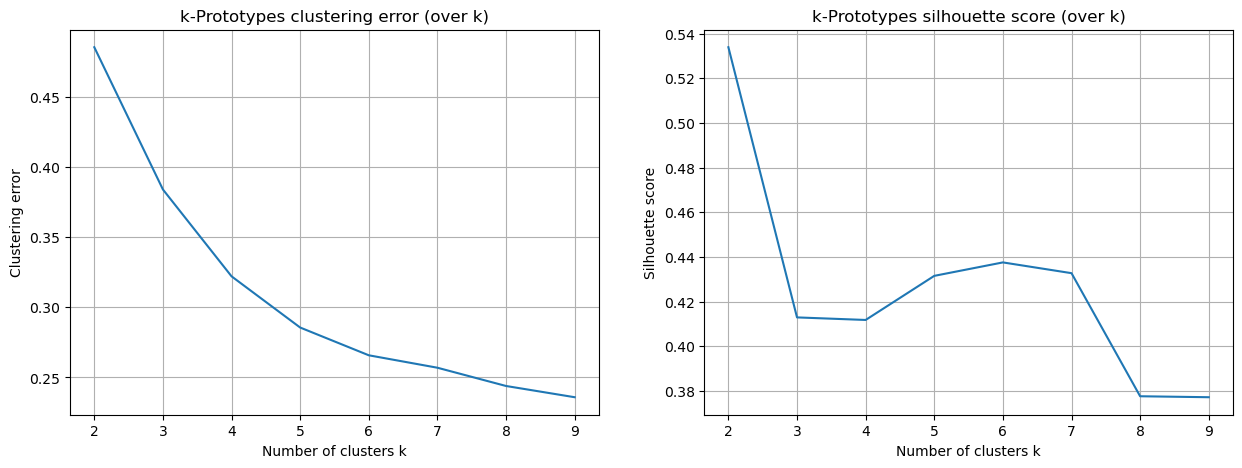

In [121]:
kmeans_sizes = list(range(2,10))
kmeans_errors = []
kmeans_silhouettes = []

for k in kmeans_sizes:
    kprot = KPrototypes(n_clusters=k, num_dissim=euclidean_dissim, cat_dissim=jaccard_dissim_binary, gamma=_gamma, n_jobs=-1)
    kprot.fit(clustering_X, categorical=_categorical_indexer)
    kmeans_errors.append(kprot.cost_ / len(df_processed))
    kmeans_silhouettes.append(silhouette_score(_distance_matrix, kprot.labels_, metric='precomputed'))
    
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].plot(kmeans_sizes, kmeans_errors)
axs[0].set_title('k-Prototypes clustering error (over k)')
axs[0].set_xlabel('Number of clusters k')
axs[0].set_ylabel('Clustering error')
axs[0].grid()
axs[1].plot(kmeans_sizes, kmeans_silhouettes)
axs[1].set_title('k-Prototypes silhouette score (over k)')
axs[1].set_xlabel('Number of clusters k')
axs[1].set_ylabel('Silhouette score')
axs[1].grid()
plt.show()

Best number of clusters maximizing silhouette and minimizing the clustering error is $k = 6$

k-Prototypes - n_clusters=6
Cluster 0 (66) - 0.79 purity of 1
Cluster 1 (89) - 0.64 purity of 1
Cluster 2 (138) - 0.70 purity of 1
Cluster 3 (163) - 0.75 purity of 1
Cluster 4 (241) - 0.69 purity of 1
Cluster 5 (303) - 0.68 purity of 1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  # This is added back by InteractiveShellApp.init_path()


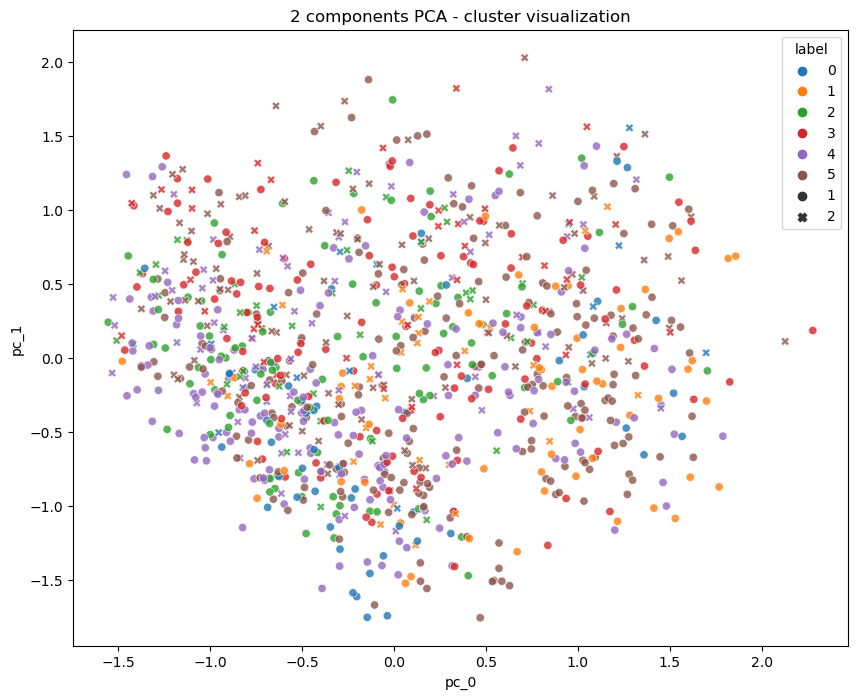

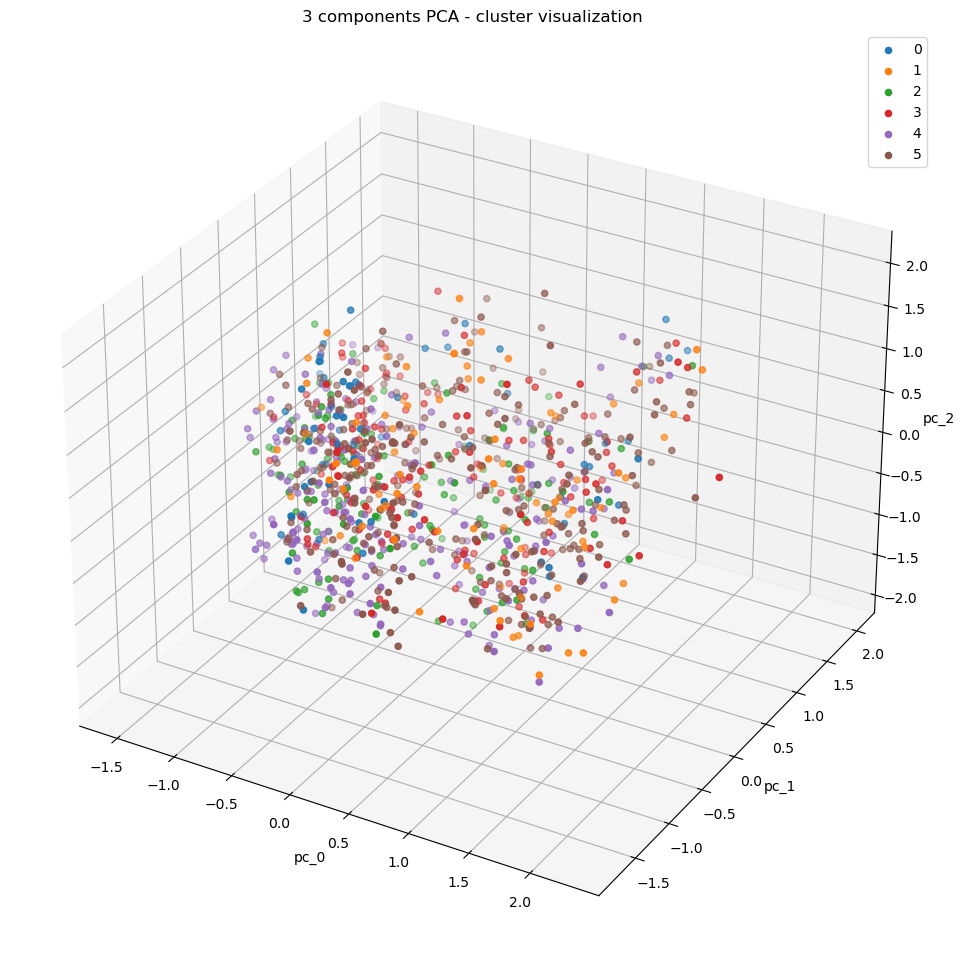

In [127]:
print(f"k-Prototypes - n_clusters=6")
kp = KPrototypes(n_clusters=6, num_dissim=euclidean_dissim, cat_dissim=jaccard_dissim_binary, gamma=_gamma, n_jobs=-1)
kp.fit(clustering_X, categorical=_categorical_indexer)

cluster_sizes = np.bincount(kp.labels_)
purity = np.bincount(kp.labels_[df_processed['label'] == 1]) / cluster_sizes
print("\n".join(["Cluster %d (%d) - %.2f purity of 1" % (i,cluster_sizes[i],_) for i,_ in enumerate(purity)]))

# 2d visualization (over PCA)
plt.figure(figsize=(10,8))
sns.scatterplot(_pca_clustering_X, x='pc_0', y='pc_1', hue=kp.labels_, style=df_processed['label'], alpha=.8, palette=sns.color_palette())
plt.title('2 components PCA - cluster visualization')
plt.xlabel('pc_0')
plt.ylabel('pc_1')
plt.show()

# 3d visualization (over PCA)
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')
for k in set(kp.labels_):
    ax.scatter(_pca_clustering_X.loc[kp.labels_ == k, 'pc_0'],_pca_clustering_X.loc[kp.labels_ == k, 'pc_1'],_pca_clustering_X.loc[kp.labels_ == k, 'pc_2'],label=k)
ax.legend()
ax.set_xlabel('pc_0')
ax.set_ylabel('pc_1')
ax.set_zlabel('pc_2')
ax.set_title('3 components PCA - cluster visualization')
plt.show()

#### DBSCAN clustering (on mixed data, custom distance metric)

In [76]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

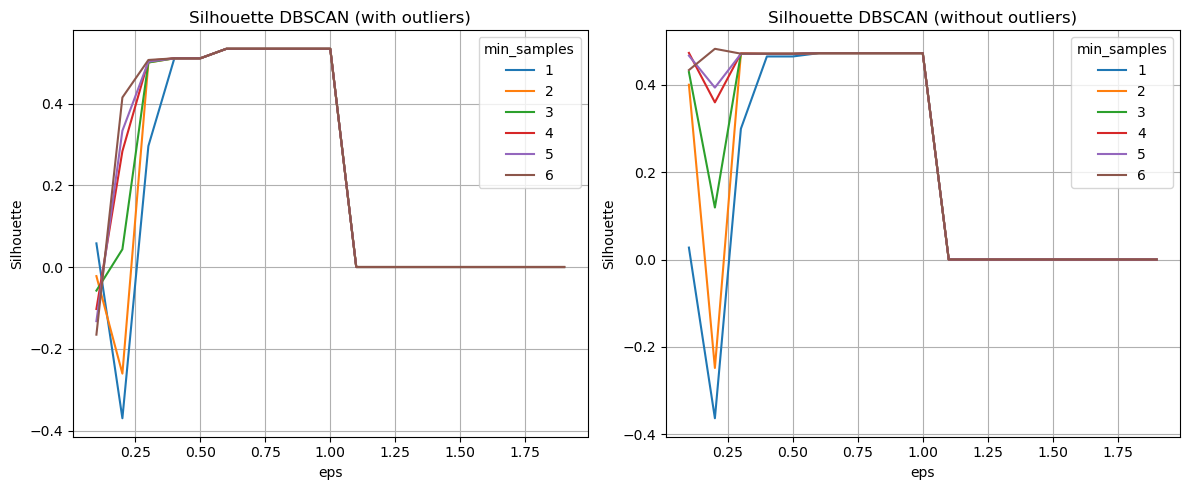

In [99]:
dbscan_nsamples_sizes = list(range(1,7))
dbscan_eps_sizes = np.arange(.1, 2, .1)
clustering_X = df_pca.loc[:, df_pca.columns != 'label']

fig, axs = plt.subplots(1,2, figsize=(12,5))
for s in dbscan_nsamples_sizes:
    dbscan_silhouettes = []
    dbscan_silhouettes_cleaned = []
    for e in dbscan_eps_sizes:
        dbscan = DBSCAN(eps=e, min_samples=s, metric='precomputed')
        dbscan.fit(_distance_matrix)
        
        dbscan_silhouettes.append(silhouette_score(_distance_matrix, dbscan.labels_, metric='precomputed') if len(set(dbscan.labels_)) > 1 else 0)
        dbscan_silhouettes_cleaned.append(silhouette_score(_distance_matrix[np.ix_(dbscan.labels_ != -1, dbscan.labels_ != -1)], dbscan.labels_[dbscan.labels_ != -1]) if len(set(dbscan.labels_[dbscan.labels_ != -1])) > 1 else 0 )
        
    axs[0].plot(dbscan_eps_sizes, dbscan_silhouettes, label=f'{s}')
    axs[1].plot(dbscan_eps_sizes, dbscan_silhouettes_cleaned, label=f'{s}')

axs[0].set_title('Silhouette DBSCAN (with outliers)')
axs[0].set_xlabel('eps')
axs[0].set_ylabel('Silhouette')
axs[0].legend(title='min_samples')
axs[0].grid()
axs[1].set_title('Silhouette DBSCAN (without outliers)')
axs[1].set_xlabel('eps')
axs[1].set_ylabel('Silhouette')
axs[1].legend(title='min_samples')
axs[1].grid()
plt.tight_layout()
plt.show()

DBSCAN - eps=.75, min_samples=3
Cluster 1 (845) - 0.70 purity of 1
Cluster 2 (155) - 0.70 purity of 1
Outliers: 0 - nan purity of 1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  del sys.path[0]


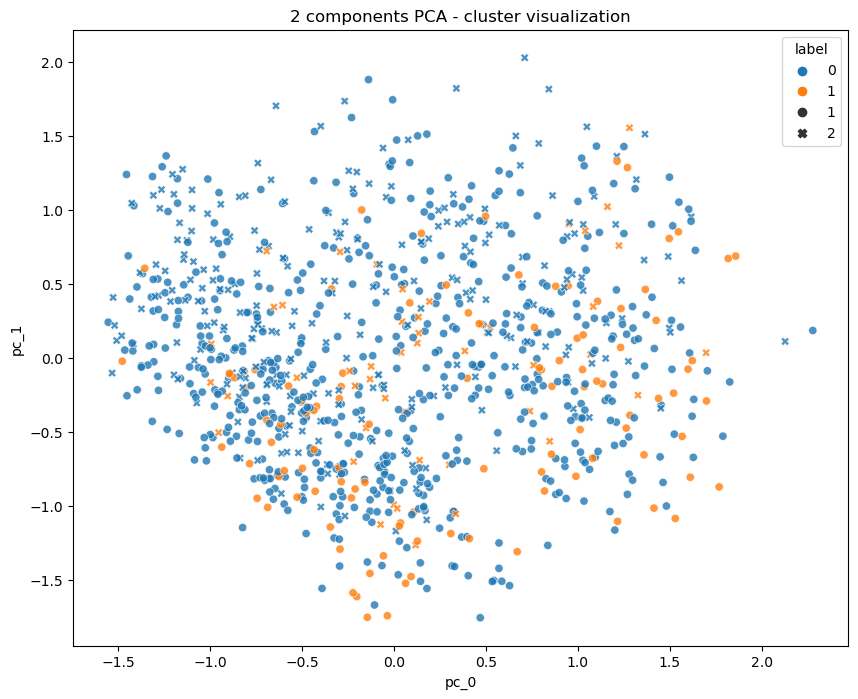

In [102]:
print(f"DBSCAN - eps=.75, min_samples=3")
dbscan = DBSCAN(eps=.75, min_samples=3, metric='precomputed')
dbscan.fit(_distance_matrix)

cluster_sizes = np.bincount(dbscan.labels_[dbscan.labels_ != -1])
outliers = (dbscan.labels_ == -1).sum()
purity = np.bincount(dbscan.labels_[(dbscan.labels_ != -1) & (df_processed['label'] == 1)]) / cluster_sizes
print("\n".join(["Cluster %d (%d) - %.2f purity of 1" % (i+1,cluster_sizes[i],_) for i,_ in enumerate(purity)]))
print("Outliers: %d - %.2f purity of 1" % (outliers, abs(dbscan.labels_[(dbscan.labels_ == -1) & (df_processed['label'] == 1)].sum()) / outliers))

# 2d visualization
plt.figure(figsize=(10,8))
sns.scatterplot(_pca_clustering_X, x='pc_0', y='pc_1', hue=dbscan.labels_, style=df_pca['label'], alpha=.8, palette=sns.color_palette())
plt.title('2 components PCA - cluster visualization')
plt.xlabel('pc_0')
plt.ylabel('pc_1')
plt.show()

## 3 Supervised Data analysis

### 3.1 Classifier Selection

We are going to experiment with the following classifiers to get a first overview of the most promising models to further select for the cross-validation step
- Support Vector Machine [SVM] (linear model with regularized Hinge loss)
- Logistic Regression [LR] (linear model with logistic loss)
- Decision Tree [DT] / Random Forest [RF] (non linear model)
- k-Nearest Neighbours [kNN]
- Multi-Layer Perceptron [MLP]

In [8]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, zero_one_loss

In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    train_size=.85,
    stratify=y,
    random_state=RANDOM_STATE
)

CLASS_WEIGHT = {1: 0.17, 2: 0.83}
CLASS_WEIGHT_NN = {0: 0.17, 1: 0.83}

In [ ]:
Xpca_train = pd.DataFrame(pca.transform(X_train), columns=[f"pc_{i}" for i in range(43)])
Xpca_val = pd.DataFrame(pca.transform(X_val), columns=[f"pc_{i}" for i in range(43)])

In [12]:
def plot_confusion_matrix(y_true, y_pred, title_ext=None):
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_true, y_pred), xticklabels=["1","2"], yticklabels=["1","2"], fmt=".3g", cmap='Blues', annot=True, cbar_kws={'label':'Occurrences'})
    plt.tick_params(axis='both', labelbottom=False, bottom=False, top=True, labeltop=True)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion matrix' + (f' {title_ext}' if title_ext else ''))
    plt.show()

#### 3.1.1 Support Vector Machine

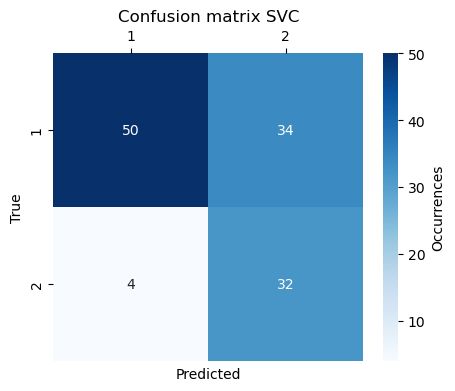

[680 TRAIN POINTS - 120 VALIDATION POINTS]
Train accuracy: 0.68 - Validation accuracy: 0.68
Train accuracy (balanced): 0.75 - Validation accuracy (balanced): 0.74


In [175]:
svc = LinearSVC(class_weight=CLASS_WEIGHT)
svc.fit(X_train, y_train)

preds = svc.predict(X_train)
bal_acc_train = balanced_accuracy_score(y_train, preds)
acc_train = accuracy_score(y_train, preds)
preds = svc.predict(X_val)
bal_acc_val = balanced_accuracy_score(y_val, preds)
acc_val = accuracy_score(y_val, preds)
plot_confusion_matrix(y_val, preds, 'SVC')
print(f'[{len(y_train)} TRAIN POINTS - {len(y_val)} VALIDATION POINTS]')
print(f'Train accuracy: {acc_train:.2f} - Validation accuracy: {acc_val:.2f}')
print(f'Train accuracy (balanced): {bal_acc_train:.2f} - Validation accuracy (balanced): {bal_acc_val:.2f}')

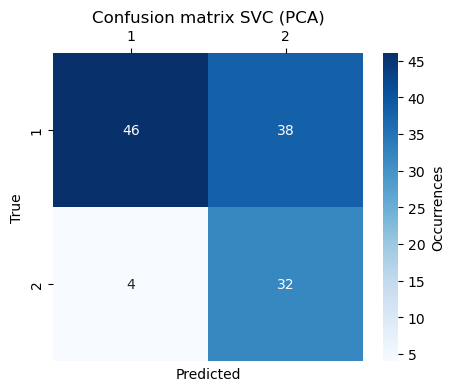

[680 TRAIN POINTS - 120 VALIDATION POINTS]
Train accuracy: 0.68 - Validation accuracy: 0.65
Train accuracy (balanced): 0.74 - Validation accuracy (balanced): 0.72


In [176]:
svc = LinearSVC(class_weight=CLASS_WEIGHT)
svc.fit(Xpca_train, y_train)

preds = svc.predict(Xpca_train)
bal_acc_train = balanced_accuracy_score(y_train, preds)
acc_train = accuracy_score(y_train, preds)
preds = svc.predict(Xpca_val)
bal_acc_val = balanced_accuracy_score(y_val, preds)
acc_val = accuracy_score(y_val, preds)
plot_confusion_matrix(y_val, preds, 'SVC (PCA)')
print(f'[{len(y_train)} TRAIN POINTS - {len(y_val)} VALIDATION POINTS]')
print(f'Train accuracy: {acc_train:.2f} - Validation accuracy: {acc_val:.2f}')
print(f'Train accuracy (balanced): {bal_acc_train:.2f} - Validation accuracy (balanced): {bal_acc_val:.2f}')

#### 3.1.2 Logistic Regression

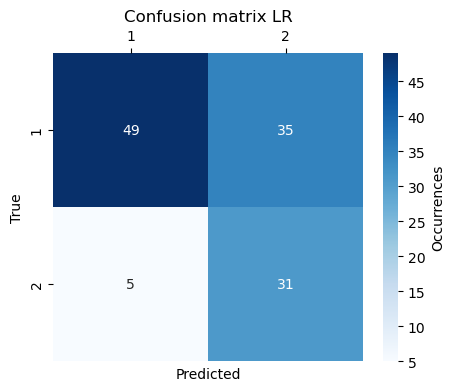

[680 TRAIN POINTS - 120 VALIDATION POINTS]
Train accuracy: 0.66 - Validation accuracy: 0.67
Train accuracy (balanced): 0.74 - Validation accuracy (balanced): 0.72


In [173]:
lr = LogisticRegression(class_weight=CLASS_WEIGHT)
lr.fit(X_train, y_train)

preds = lr.predict(X_train)
bal_acc_train = balanced_accuracy_score(y_train, preds)
acc_train = accuracy_score(y_train, preds)
preds = lr.predict(X_val)
bal_acc_val = balanced_accuracy_score(y_val, preds)
acc_val = accuracy_score(y_val, preds)
plot_confusion_matrix(y_val, preds, 'LR')
print(f'[{len(y_train)} TRAIN POINTS - {len(y_val)} VALIDATION POINTS]')
print(f'Train accuracy: {acc_train:.2f} - Validation accuracy: {acc_val:.2f}')
print(f'Train accuracy (balanced): {bal_acc_train:.2f} - Validation accuracy (balanced): {bal_acc_val:.2f}')

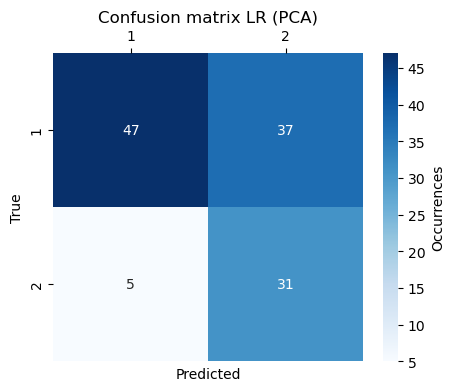

[680 TRAIN POINTS - 120 VALIDATION POINTS]
Train accuracy: 0.66 - Validation accuracy: 0.65
Train accuracy (balanced): 0.73 - Validation accuracy (balanced): 0.71


In [174]:
lr = LogisticRegression(class_weight=CLASS_WEIGHT)
lr.fit(Xpca_train, y_train)

preds = lr.predict(Xpca_train)
bal_acc_train = balanced_accuracy_score(y_train, preds)
acc_train = accuracy_score(y_train, preds)
preds = lr.predict(Xpca_val)
bal_acc_val = balanced_accuracy_score(y_val, preds)
acc_val = accuracy_score(y_val, preds)
plot_confusion_matrix(y_val, preds, 'LR (PCA)')
print(f'[{len(y_train)} TRAIN POINTS - {len(y_val)} VALIDATION POINTS]')
print(f'Train accuracy: {acc_train:.2f} - Validation accuracy: {acc_val:.2f}')
print(f'Train accuracy (balanced): {bal_acc_train:.2f} - Validation accuracy (balanced): {bal_acc_val:.2f}')

#### 3.1.3 Decision Tree

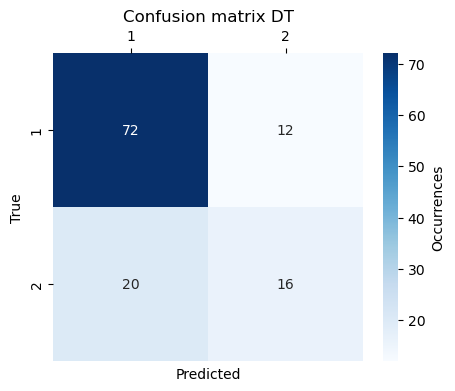

[680 TRAIN POINTS - 120 VALIDATION POINTS]
Train accuracy: 1.00 - Validation accuracy: 0.73
Train accuracy (balanced): 1.00 - Validation accuracy (balanced): 0.65


In [167]:
dt = DecisionTreeClassifier(class_weight=CLASS_WEIGHT)
dt.fit(X_train, y_train)

preds = dt.predict(X_train)
bal_acc_train = balanced_accuracy_score(y_train, preds)
acc_train = accuracy_score(y_train, preds)
preds = dt.predict(X_val)
bal_acc_val = balanced_accuracy_score(y_val, preds)
acc_val = accuracy_score(y_val, preds)
plot_confusion_matrix(y_val, preds, 'DT')
print(f'[{len(y_train)} TRAIN POINTS - {len(y_val)} VALIDATION POINTS]')
print(f'Train accuracy: {acc_train:.2f} - Validation accuracy: {acc_val:.2f}')
print(f'Train accuracy (balanced): {bal_acc_train:.2f} - Validation accuracy (balanced): {bal_acc_val:.2f}')

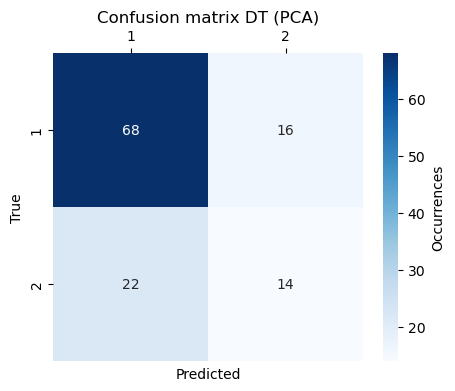

[680 TRAIN POINTS - 120 VALIDATION POINTS]
Train accuracy: 1.00 - Validation accuracy: 0.68
Train accuracy (balanced): 1.00 - Validation accuracy (balanced): 0.60


In [172]:
dt = DecisionTreeClassifier(class_weight=CLASS_WEIGHT)
dt.fit(Xpca_train, y_train)

preds = dt.predict(Xpca_train)
bal_acc_train = balanced_accuracy_score(y_train, preds)
acc_train = accuracy_score(y_train, preds)
preds = dt.predict(Xpca_val)
bal_acc_val = balanced_accuracy_score(y_val, preds)
acc_val = accuracy_score(y_val, preds)
plot_confusion_matrix(y_val, preds, 'DT (PCA)')
print(f'[{len(y_train)} TRAIN POINTS - {len(y_val)} VALIDATION POINTS]')
print(f'Train accuracy: {acc_train:.2f} - Validation accuracy: {acc_val:.2f}')
print(f'Train accuracy (balanced): {bal_acc_train:.2f} - Validation accuracy (balanced): {bal_acc_val:.2f}')

#### 3.1.4 Random Forest

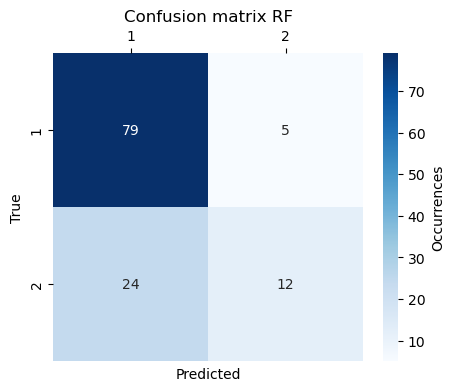

[680 TRAIN POINTS - 120 VALIDATION POINTS]
Train accuracy: 1.00 - Validation accuracy: 0.76
Train accuracy (balanced): 1.00 - Validation accuracy (balanced): 0.64


In [157]:
rf = RandomForestClassifier(class_weight=CLASS_WEIGHT)
rf.fit(X_train, y_train)

preds = rf.predict(X_train)
bal_acc_train = balanced_accuracy_score(y_train, preds)
acc_train = accuracy_score(y_train, preds)
preds = rf.predict(X_val)
bal_acc_val = balanced_accuracy_score(y_val, preds)
acc_val = accuracy_score(y_val, preds)
plot_confusion_matrix(y_val, preds, 'RF')
print(f'[{len(y_train)} TRAIN POINTS - {len(y_val)} VALIDATION POINTS]')
print(f'Train accuracy: {acc_train:.2f} - Validation accuracy: {acc_val:.2f}')
print(f'Train accuracy (balanced): {bal_acc_train:.2f} - Validation accuracy (balanced): {bal_acc_val:.2f}')

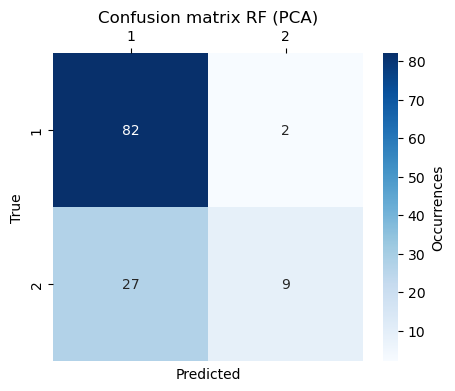

[680 TRAIN POINTS - 120 VALIDATION POINTS]
Train accuracy: 1.00 - Validation accuracy: 0.76
Train accuracy (balanced): 1.00 - Validation accuracy (balanced): 0.61


In [164]:
rf = RandomForestClassifier(class_weight=CLASS_WEIGHT)
rf.fit(Xpca_train, y_train)

preds = rf.predict(Xpca_train)
bal_acc_train = balanced_accuracy_score(y_train, preds)
acc_train = accuracy_score(y_train, preds)
preds = rf.predict(Xpca_val)
bal_acc_val = balanced_accuracy_score(y_val, preds)
acc_val = accuracy_score(y_val, preds)
plot_confusion_matrix(y_val, preds, 'RF (PCA)')
print(f'[{len(y_train)} TRAIN POINTS - {len(y_val)} VALIDATION POINTS]')
print(f'Train accuracy: {acc_train:.2f} - Validation accuracy: {acc_val:.2f}')
print(f'Train accuracy (balanced): {bal_acc_train:.2f} - Validation accuracy (balanced): {bal_acc_val:.2f}')

#### 3.1.5 k-NN

In [ ]:
from kmodes.util.dissim import euclidean_dissim, jaccard_dissim_binary

def custom_distance_metric(a_num, a_cat, b_num, b_cat, g):
    return euclidean_dissim(a_num, b_num) + g * jaccard_dissim_binary(a_cat, b_cat)

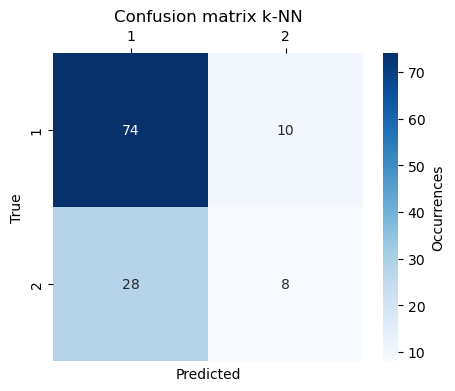

[680 TRAIN POINTS - 120 VALIDATION POINTS]
Train accuracy: 0.79 - Validation accuracy: 0.68
Train accuracy (balanced): 0.68 - Validation accuracy (balanced): 0.55


In [138]:
_non_categorical_indexer = X_train.columns.get_indexer(non_categorical_features).tolist()
_categorical_indexer = X_train.columns.get_indexer(categorical_features_hotencoded).tolist()
_gamma = 0.5 * np.mean(X_train.loc[:,non_categorical_features].std(axis=0))
X_train_distances = np.array([custom_distance_metric(
    X_train.to_numpy()[:,_non_categorical_indexer],
    X_train.to_numpy()[:,_categorical_indexer].astype(int),
    X_train.to_numpy()[i,_non_categorical_indexer],
    X_train.to_numpy()[i,_categorical_indexer].astype(int),
    _gamma
) for i in range(len(X_train))])
X_val_distances = np.array([custom_distance_metric(
    X_train.to_numpy()[:,_non_categorical_indexer],
    X_train.to_numpy()[:,_categorical_indexer].astype(int),
    X_val.to_numpy()[i,_non_categorical_indexer],
    X_val.to_numpy()[i,_categorical_indexer].astype(int),
    _gamma
) for i in range(len(X_val))])

knn = KNeighborsClassifier(metric='precomputed')
knn.fit(X_train_distances, y_train)

preds = knn.predict(X_train_distances)
bal_acc_train = balanced_accuracy_score(y_train, preds)
acc_train = accuracy_score(y_train, preds)
preds = knn.predict(X_val_distances)
bal_acc_val = balanced_accuracy_score(y_val, preds)
acc_val = accuracy_score(y_val, preds)
plot_confusion_matrix(y_val, preds, 'k-NN')
print(f'[{len(y_train)} TRAIN POINTS - {len(y_val)} VALIDATION POINTS]')
print(f'Train accuracy: {acc_train:.2f} - Validation accuracy: {acc_val:.2f}')
print(f'Train accuracy (balanced): {bal_acc_train:.2f} - Validation accuracy (balanced): {bal_acc_val:.2f}')

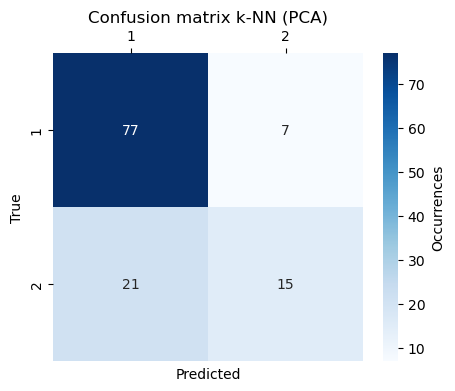

[680 TRAIN POINTS - 120 VALIDATION POINTS]
Train accuracy: 0.81 - Validation accuracy: 0.77
Train accuracy (balanced): 0.72 - Validation accuracy (balanced): 0.67


In [139]:
knn = KNeighborsClassifier()
knn.fit(Xpca_train, y_train)

preds = knn.predict(Xpca_train)
bal_acc_train = balanced_accuracy_score(y_train, preds)
acc_train = accuracy_score(y_train, preds)
preds = knn.predict(Xpca_val)
bal_acc_val = balanced_accuracy_score(y_val, preds)
acc_val = accuracy_score(y_val, preds)
plot_confusion_matrix(y_val, preds, 'k-NN (PCA)')
print(f'[{len(y_train)} TRAIN POINTS - {len(y_val)} VALIDATION POINTS]')
print(f'Train accuracy: {acc_train:.2f} - Validation accuracy: {acc_val:.2f}')
print(f'Train accuracy (balanced): {bal_acc_train:.2f} - Validation accuracy (balanced): {bal_acc_val:.2f}')

#### 3.1.6 Neural Network

In [13]:
import tqdm.keras as tk

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.special import expit

def plot_roc_curve(fpr, tpr, optimal_idx):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label='optimal')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
    
def plot_validation_curve(nn_history):
    x = list(range(len(nn_history.history['loss'])))
    plt.plot(x, nn_history.history['loss'], label='training loss')
    plt.plot(x, nn_history.history['val_loss'], label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Weighted Binary Cross-Entropy Loss')
    plt.title('Validation Curve')
    plt.legend()
    plt.show()


def get_model_threshold(model, X, y):
    y_pred = expit(np.squeeze(nn.predict(X)))
    fpr, tpr, thresholds = roc_curve(y,y_pred)
    return thresholds[np.argmax(tpr-fpr)]

Fit model on training data


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

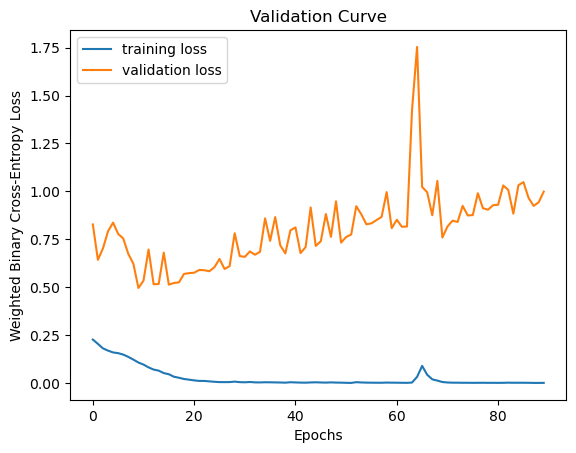

In [100]:
nn = keras.Sequential([
    keras.layers.Input(shape=(X.shape[1],), name='input'),
    keras.layers.Dense(200, activation='relu'),
    keras.layers.Dense(120, activation='relu'),
    keras.layers.Dense(40, activation='sigmoid'),
    keras.layers.Dense(1, name='output')
])
nn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
        'accuracy'
    ]
)

print("Fit model on training data")
nn_history = nn.fit(
    X_train,
    y_train-1,
    batch_size=30,
    epochs=200,
    validation_data=(X_val, y_val-1),
    class_weight=CLASS_WEIGHT_NN,
    callbacks=[
        tk.TqdmCallback(),
        keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, start_from_epoch=50)
    ],
    verbose=0
)
plot_validation_curve(nn_history)

4/4 [==============================] - 0s 4ms/step


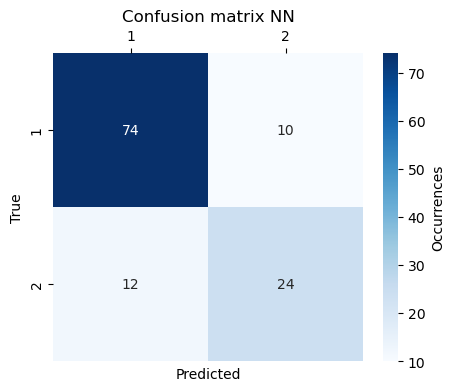

[680 TRAIN POINTS - 120 VALIDATION POINTS]
Train accuracy: 1.00 - Validation accuracy: 0.82


In [101]:
optimal_threshold = get_model_threshold(nn, X, y-1)

preds = (expit(nn.predict(X_train)) > optimal_threshold).astype(int) + 1
acc_train = accuracy_score(y_train, preds)
preds = (expit(nn.predict(X_val)) > optimal_threshold).astype(int) + 1
acc_val = accuracy_score(y_val, preds)
plot_confusion_matrix(y_val, preds, 'NN')
print(f'[{len(y_train)} TRAIN POINTS - {len(y_val)} VALIDATION POINTS]')
print(f'Train accuracy: {acc_train:.2f} - Validation accuracy: {acc_val:.2f}')

#### **Observations**

The most promising models to be further investigated and tuned are the following:
  - Support Vector Machine (with linear kernel) [LinearSVC]
  - Decision Tree [DT]
  - Neural Network [NN]

### 3.2 Cross Validation

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_validate, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import classification_report

In [20]:
# Define common grid-search with cross-validation and performance evaluation process
def hyperparam_tuning_process(model, param_grid, X, y, model_name, scoring='accuracy'):
    gscv = GridSearchCV(model, param_grid=param_grid, scoring=scoring, return_train_score=True, n_jobs=-1, cv=StratifiedShuffleSplit(train_size=.85, random_state=RANDOM_STATE))
    gscv.fit(X, y)
    
    best_param_set = gscv.best_params_
    
    param_names = param_grid.keys()
    params_x = [str([_p[pname] for pname in param_names]) for _p in gscv.cv_results_['params']]

    plt.figure(figsize=(15,8))
    plt.plot(params_x, gscv.cv_results_['mean_train_score'], color='blue', label='train')
    plt.fill_between(
        params_x,
        gscv.cv_results_['mean_train_score'] - gscv.cv_results_['std_train_score'],
        gscv.cv_results_['mean_train_score'] + gscv.cv_results_['std_train_score'],
        color='blue', alpha=.3
    )
    plt.plot(params_x, gscv.cv_results_['mean_test_score'], color='red', label='val')
    plt.fill_between(
        params_x,
        gscv.cv_results_['mean_test_score'] - gscv.cv_results_['std_test_score'],
        gscv.cv_results_['mean_test_score'] + gscv.cv_results_['std_test_score'],
        color='red', alpha=.3
    )
    plt.legend()
    plt.grid()
    plt.xlabel('Parameter combinations')
    plt.xticks(rotation=90)
    plt.ylabel(scoring)
    plt.ylim(0, 1)
    plt.title(f'Grid search - `{model_name}`')
    plt.show()
    
    return gscv.best_params_, gscv.best_score_

#### 3.2.1 Decision Tree

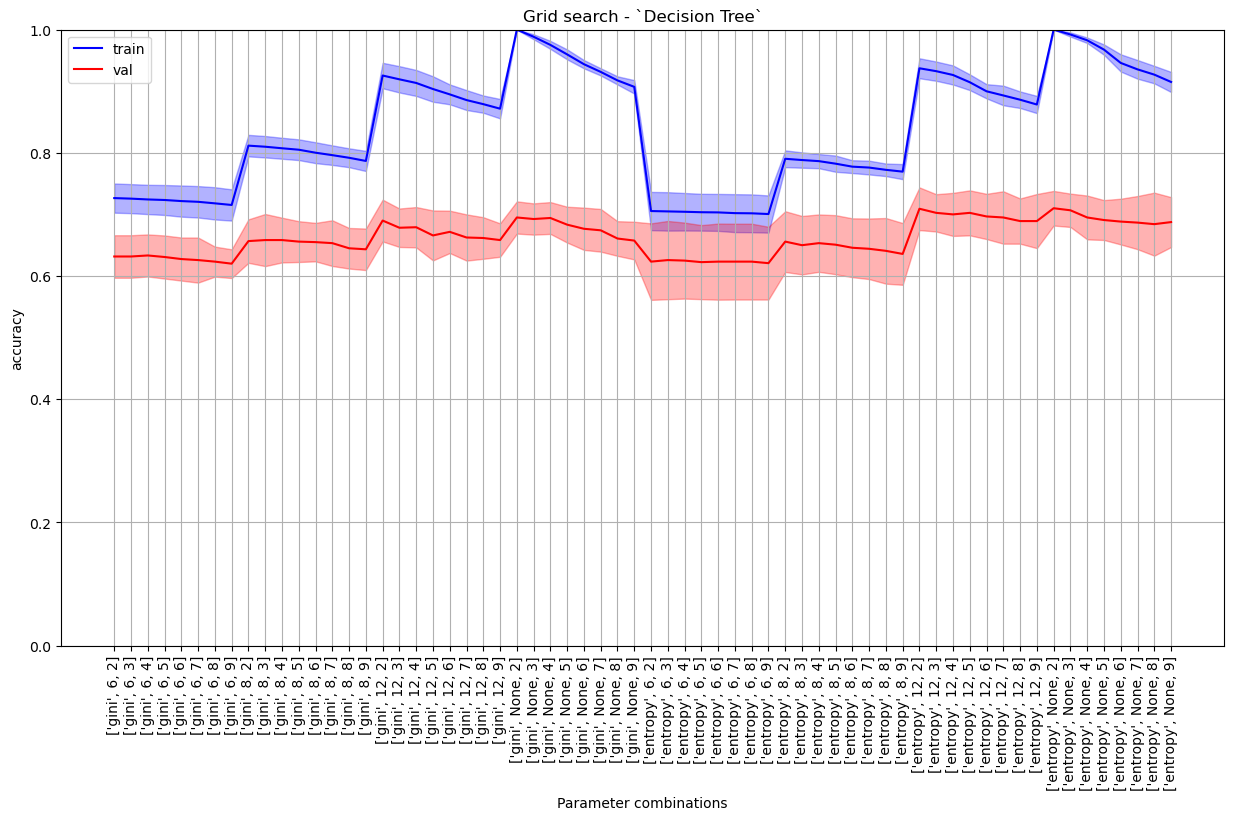

Decision Tree - Grid search results
Best set of params is:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2}
With validation score of 0.7100000000000001


In [218]:
param_grid = {
    "criterion": ['gini', 'entropy'],
    "max_depth": [6,8,12,None],
    "min_samples_split": np.arange(2,10,1)
}
dt = DecisionTreeClassifier(class_weight=CLASS_WEIGHT, random_state=RANDOM_STATE)
best_p_dt, score = hyperparam_tuning_process(dt, param_grid, X, y, 'Decision Tree', scoring='accuracy')

print('Decision Tree - Grid search results')
print('Best set of params is:')
print(best_p_dt)
print(f'With validation score of {score}')

              precision    recall  f1-score   support

           1       0.82      0.88      0.85        84
           2       0.67      0.56      0.61        36

    accuracy                           0.78       120
   macro avg       0.74      0.72      0.73       120
weighted avg       0.78      0.78      0.78       120



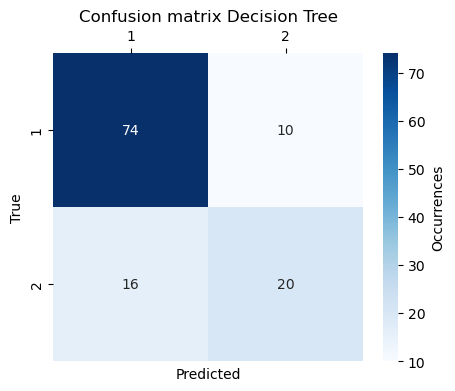

In [219]:
dt = DecisionTreeClassifier(class_weight=CLASS_WEIGHT, **best_p_dt, random_state=RANDOM_STATE)
dt.fit(X_train,y_train)
preds = dt.predict(X_val)

print(classification_report(y_val, preds))
plot_confusion_matrix(y_val, preds, 'Decision Tree')

#### 3.2.2 LinearSVC

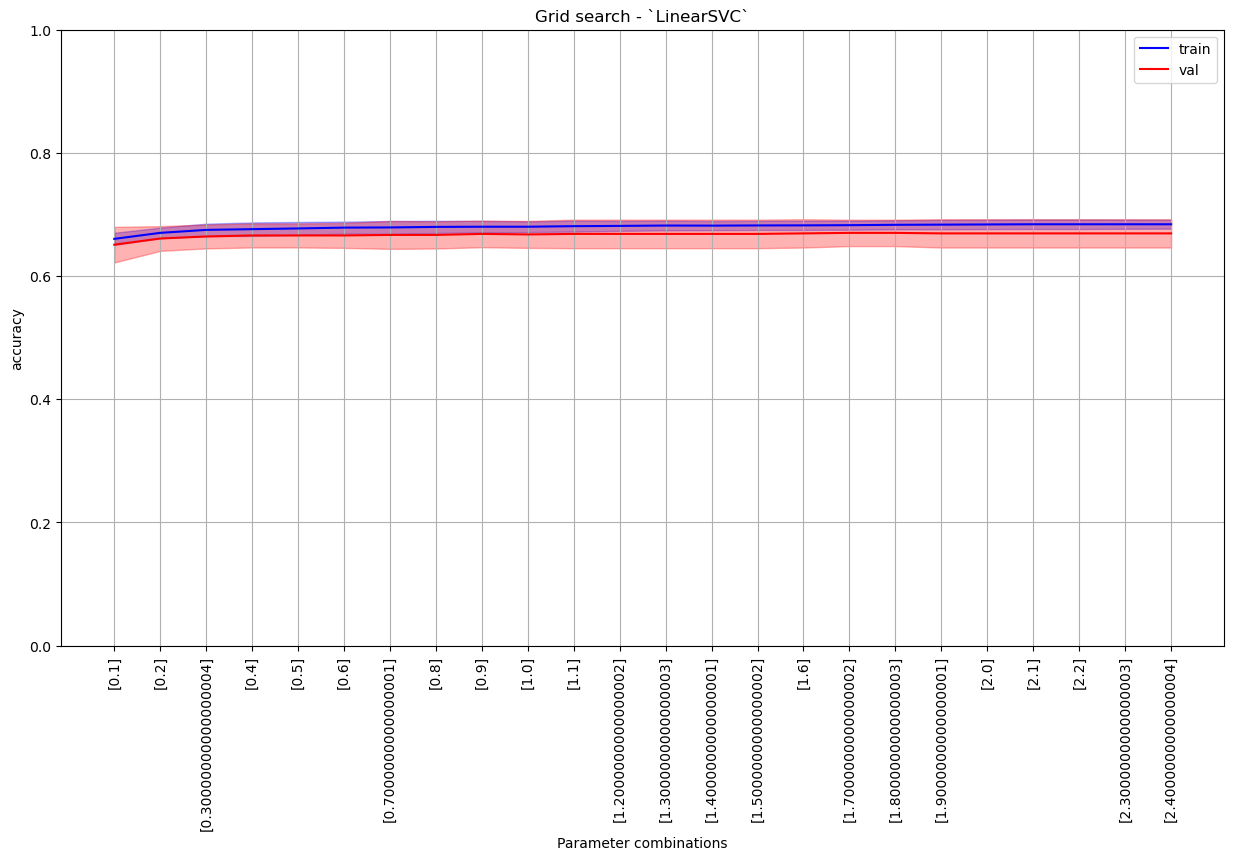

LinearSVC - Grid search results
Best set of params is:
{'C': 0.1}
With validation score of 0.67


In [225]:
param_grid = {
    "C": np.arange(0.1,2.5,0.1)
}
svc = LinearSVC(class_weight=CLASS_WEIGHT)
best_p_svc, score = hyperparam_tuning_process(svc, param_grid, X, y, 'LinearSVC', scoring='accuracy')

print('LinearSVC - Grid search results')
print('Best set of params is:')
print(best_p)
print(f'With validation score of {score}')

              precision    recall  f1-score   support

           1       0.82      0.88      0.85        84
           2       0.67      0.56      0.61        36

    accuracy                           0.78       120
   macro avg       0.74      0.72      0.73       120
weighted avg       0.78      0.78      0.78       120



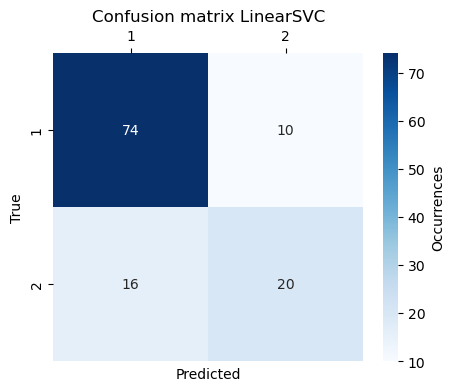

In [226]:
svc = LinearSVC(class_weight=CLASS_WEIGHT, **best_p_svc)
svc.fit(X_train,y_train)
preds = dt.predict(X_val)

print(classification_report(y_val, preds))
plot_confusion_matrix(y_val, preds, 'LinearSVC')

#### 3.2.3 Neural Network

In [74]:
from scipy.special import expit
import keras_tuner as kt

In [99]:
def model_builder(hp):
    hp_l1_units = hp.Int('l1_units', min_value=20, max_value=200, step=20)  # 9
    hp_l2_units = hp.Int('l2_units', min_value=10, max_value=110, step=20)  # 5
    hp_l3_units = hp.Int('l3_units', min_value=10, max_value=40, step=5)    # 6
    model = keras.Sequential([
        keras.layers.Input(shape=(X.shape[1],), name='input'),
        keras.layers.Dense(units=hp_l1_units, activation='relu'),
        keras.layers.Dense(units=hp_l2_units, activation='relu'),
        keras.layers.Dense(units=hp_l3_units, activation='sigmoid'),
        keras.layers.Dense(1, name='output')
    ])
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])  # 2
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

class GridSearchKerasCV(kt.GridSearch):
    def __init__(self,
        hypermodel=None,
        objective=None,
        max_trials=None,
        seed=None,
        hyperparameters=None,
        tune_new_entries=True,
        allow_new_entries=True,
        max_retries_per_trial=0,
        max_consecutive_failed_trials=3,
        cv = None,
        **kwargs,
    ):
        self.cv = cv
        self.objective = objective
        super().__init__(
            **kwargs
        )
        
    def run_trial(self, trial, *fit_args, **fit_kwargs):
        obj_results = []
        for i, (train_index, test_index) in enumerate(self.cv.split(fit_kwargs.get("x"), fit_kwargs.get("y"))):
            trainX = fit_kwargs.get("x").iloc[train_index]
            trainy = fit_kwargs.get("y").iloc[train_index]
            valX = fit_kwargs.get("x").iloc[test_index]
            valy = fit_kwargs.get("y").iloc[test_index]
            copied_kwargs = copy.copy(fit_kwargs)
            copied_kwargs["x"] = trainX
            copied_kwargs["y"] = trainy
            copied_kwargs["validation_data"] = (valX,valy)
            copied_kwargs["verbose"] = 0
            
            model = model_builder(trial.hyperparameters)
            history = model.fit(**copied_kwargs)
            
            res = model.evaluate(valX,valy)[model.metrics_names.index(self.objective.split('_')[1])]
            obj_results.append(res)
            
        return [np.mean(obj_results)]

tuner = GridSearchKerasCV(
    model_builder,
    objective='val_loss',
    seed=RANDOM_STATE,
    #max_trials=250
    project_name='nn_tuning',
    cv=StratifiedShuffleSplit(n_splits=5, train_size=.85, random_state=RANDOM_STATE)
)

In [98]:
tuner.search(
    x=X,
    y=y-1,
    batch_size=30,
    epochs=150,
    class_weight=CLASS_WEIGHT_NN,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, start_from_epoch=35)
    ]
)

Trial 9 Complete [00h 01m 09s]
default_objective: 0.7055119276046753

Best default_objective So Far: 0.596351158618927
Total elapsed time: 00h 06m 26s

Search: Running Trial #10

Value             |Best Value So Far |Hyperparameter
20                |20                |l1_units
10                |10                |l2_units
25                |15                |l3_units
0.01              |0.001             |learning_rate

4/4 [==============================] - 0s 4ms/step - loss: 1.1604 - accuracy: 0.7333


KeyboardInterrupt: 

In [30]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{}

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 40)                2480      
                                                                 
 dense_19 (Dense)            (None, 50)                2050      
                                                                 
 dense_20 (Dense)            (None, 50)                2550      
                                                                 
 output (Dense)              (None, 1)                 51        
                                                                 
Total params: 7,131
Trainable params: 7,131
Non-trainable params: 0
_________________________________________________________________


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

4/4 [==============================] - 0s 3ms/step


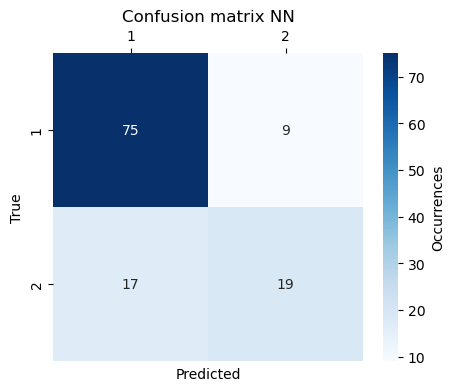

[680 TRAIN POINTS - 120 VALIDATION POINTS]
Train accuracy: 0.99 - Validation accuracy: 0.78
              precision    recall  f1-score   support

           1       0.82      0.89      0.85        84
           2       0.68      0.53      0.59        36

    accuracy                           0.78       120
   macro avg       0.75      0.71      0.72       120
weighted avg       0.77      0.78      0.77       120



In [343]:
model = model_builder(best_hps)
model.summary()

model.fit(
    X_train,
    y_train-1,
    batch_size=30,
    epochs=150,
    validation_data=(X_val, y_val-1),
    class_weight=CLASS_WEIGHT_NN,
    callbacks=[
        tk.TqdmCallback(),
        keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5, start_from_epoch=35)
    ],
    verbose=0
)

optimal_threshold = get_model_threshold(model, X, y-1)

preds = (expit(model.predict(X_train)) > optimal_threshold).astype(int) + 1
acc_train = accuracy_score(y_train, preds)
preds = (expit(model.predict(X_val)) > optimal_threshold).astype(int) + 1
acc_val = accuracy_score(y_val, preds)
plot_confusion_matrix(y_val, preds, 'NN')
print(classification_report(y_val, preds))

## 4 Adversarial Attacks